In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp

from hypnotoad import tokamak
from hypnotoad.core.mesh import BoutMesh
from fusiondls import run_dls, file_read, file_write
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK
from fusiondls.AnalyticCoolingCurves import LfuncKallenbach
from fusiondls.Profile import Profile


onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *

from code_comparison.solps_pp import *

from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline

%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\mikek\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [4]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            # eqb[case][side][i] = unpackConfigurationMK(
            #     File = os.path.join(balance_paths[case], "balance.nc"), Type = side, sepadd=i, 
            #     resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)

            eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Read radas

In [5]:
rd = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")
# ds = ds.sel(dim_electron_density=1e20, method="nearest")

In [7]:
%matplotlib inline

# 2D plots

In [8]:
store_slc.keys()

dict_keys(['100MW_inner_arpuff', '100MW_innerar_midplanepuff'])

## Density

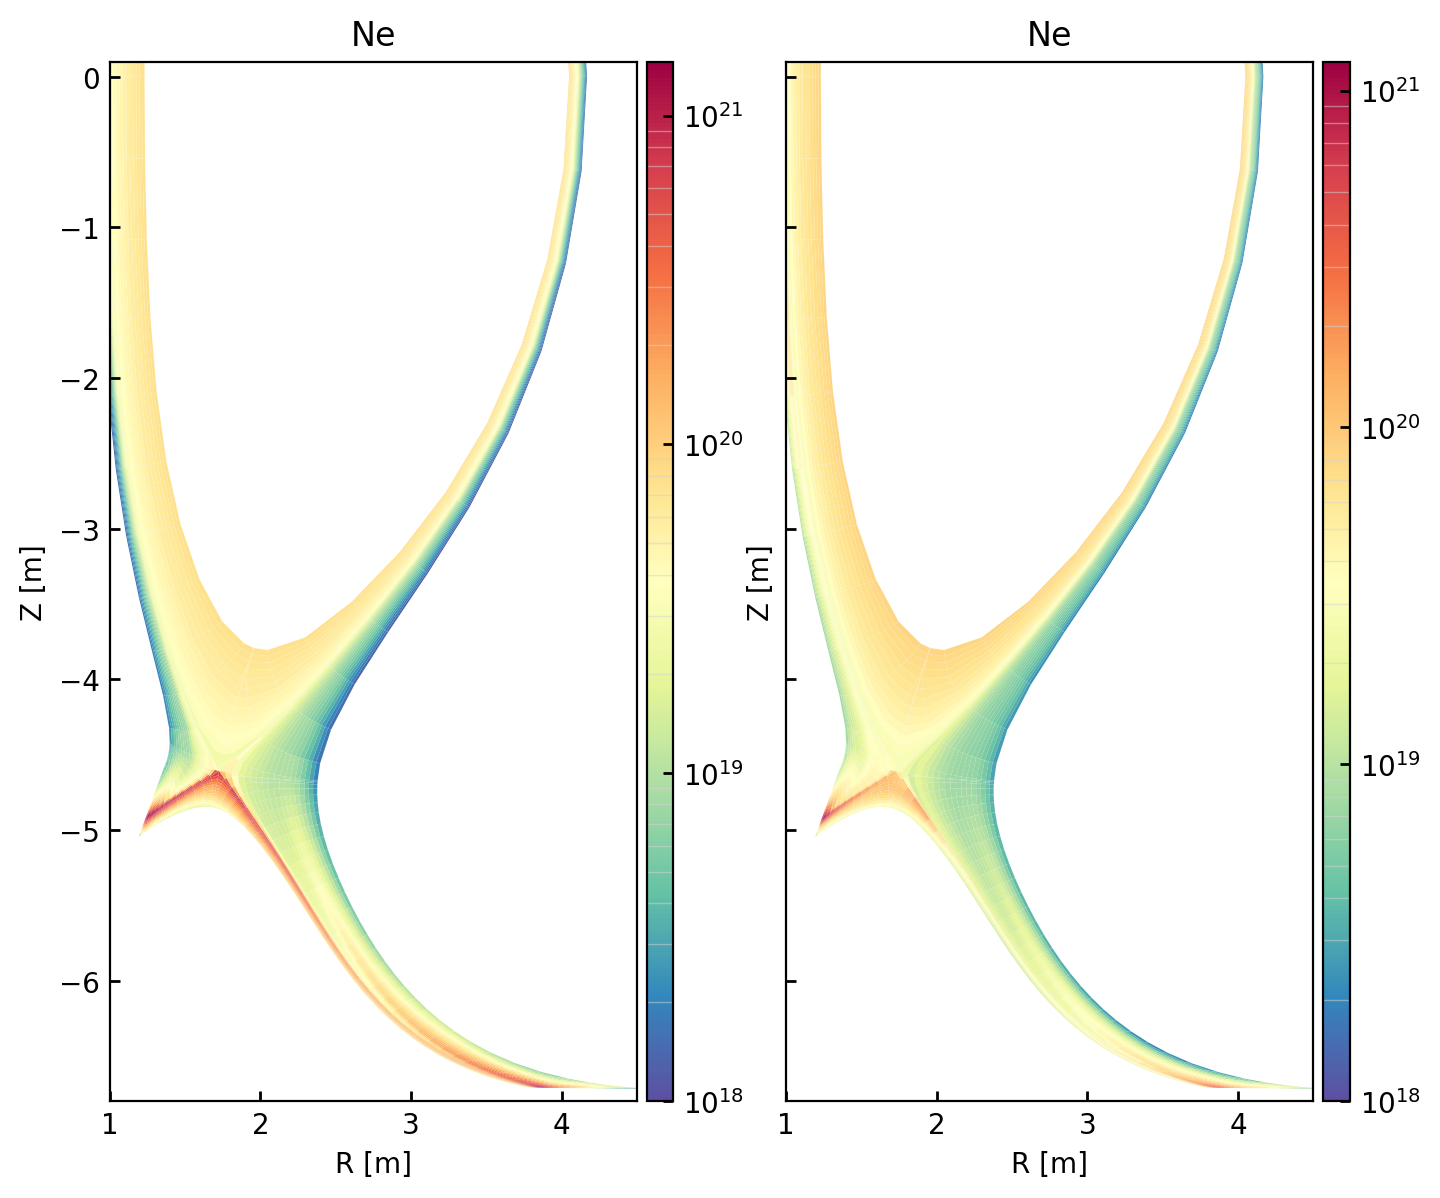

In [6]:
fig, axes = plt.subplots(1,2, dpi = 200, figsize = (8,8), sharey = True)

param = "Ne"
vmax = None
vmin = 1e18
logscale = True

store_slc["100MW_inner_arpuff"].plot_2d(param = param,  ax = axes[0], 
            linewidth = 0, antialias = True, grid_only = False, vmax = vmax, vmin = vmin, logscale = logscale, separatrix = False,
            custom_cmap = "Spectral_r", cbar = True, axis_labels = False, alpha = 1)

store_slc["100MW_innerar_midplanepuff"].plot_2d(param = param,  ax = axes[1], 
            linewidth = 0, antialias = True, grid_only = False, vmax = vmax, vmin = vmin, logscale = logscale, separatrix = False,
            custom_cmap = "Spectral_r", cbar = True, axis_labels = False, alpha = 1)

for ax in axes:
    ax.grid(False)

    # V10
    ax.set_xlim(1.0, 4.5)
    # ax.set_ylim(-7, -3)
    ax.set_ylim(-6.8, 0.1)

    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
    
fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_2D_Ne.pdf", format = "pdf")

## Mach number

Text(0.5, 0.75, 'Mach number')

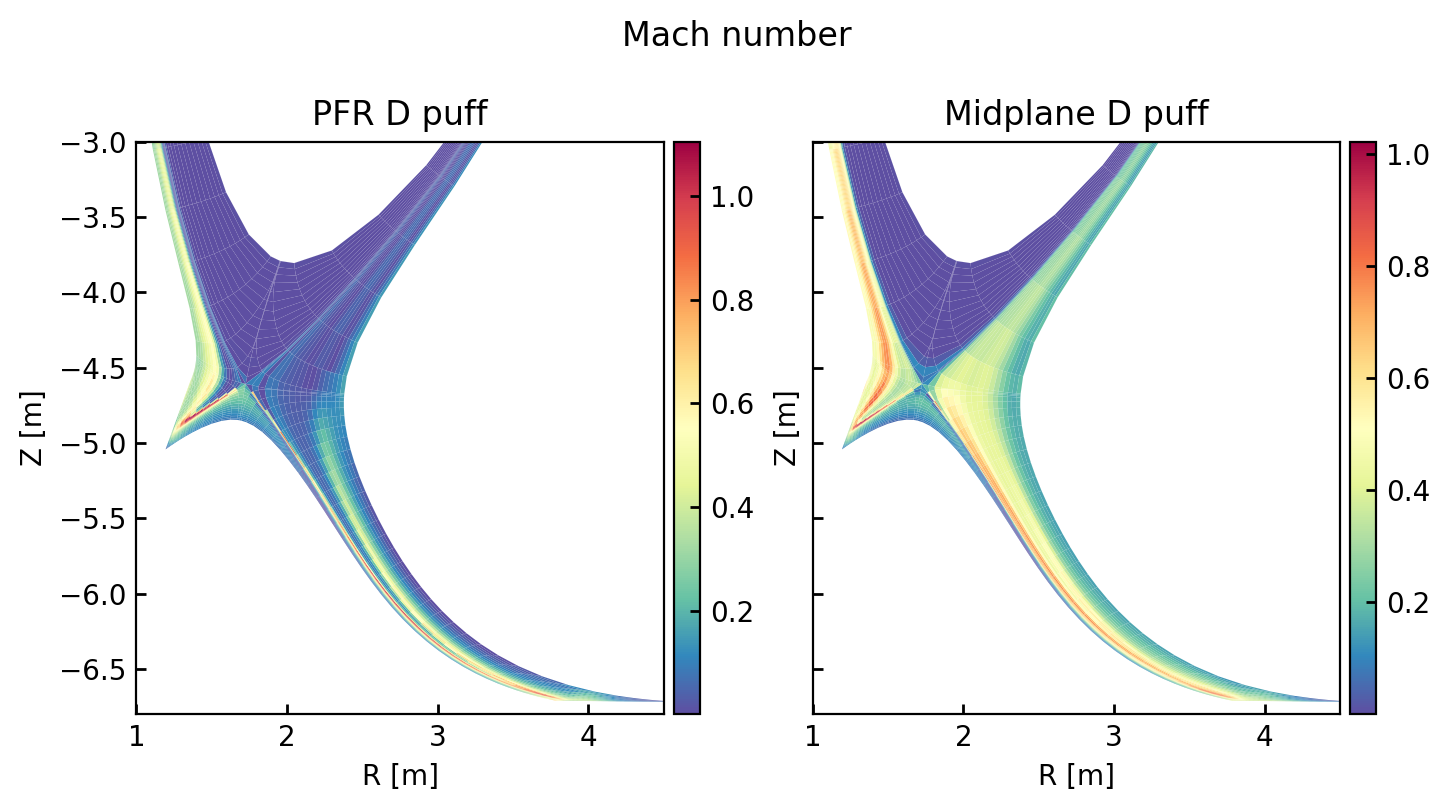

In [7]:
fig, axes = plt.subplots(1,2, dpi = 200, figsize = (8,8), sharey = True)

param = "M"
vmax = None
vmin = None
logscale = False

store_slc["100MW_inner_arpuff"].plot_2d(param = param,  ax = axes[0], 
            linewidth = 0, antialias = True, grid_only = False, vmax = vmax, vmin = vmin, logscale = logscale, separatrix = False,
            custom_cmap = "Spectral_r", cbar = True, axis_labels = False, alpha = 1)

store_slc["100MW_innerar_midplanepuff"].plot_2d(param = param,  ax = axes[1], 
            linewidth = 0, antialias = True, grid_only = False, vmax = vmax, vmin = vmin, logscale = logscale, separatrix = False,
            custom_cmap = "Spectral_r", cbar = True, axis_labels = False, alpha = 1)
axes[0].set_title("PFR D puff")
axes[1].set_title("Midplane D puff")

for ax in axes:
    ax.grid(False)

    # V10
    ax.set_xlim(1.0, 4.5)
    # ax.set_ylim(-7, -3)
    ax.set_ylim(-6.8, -3)

    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
    
fig.suptitle("Mach number", y = 0.75)
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_2D_Ne.pdf", format = "pdf")

## Impurity fraction

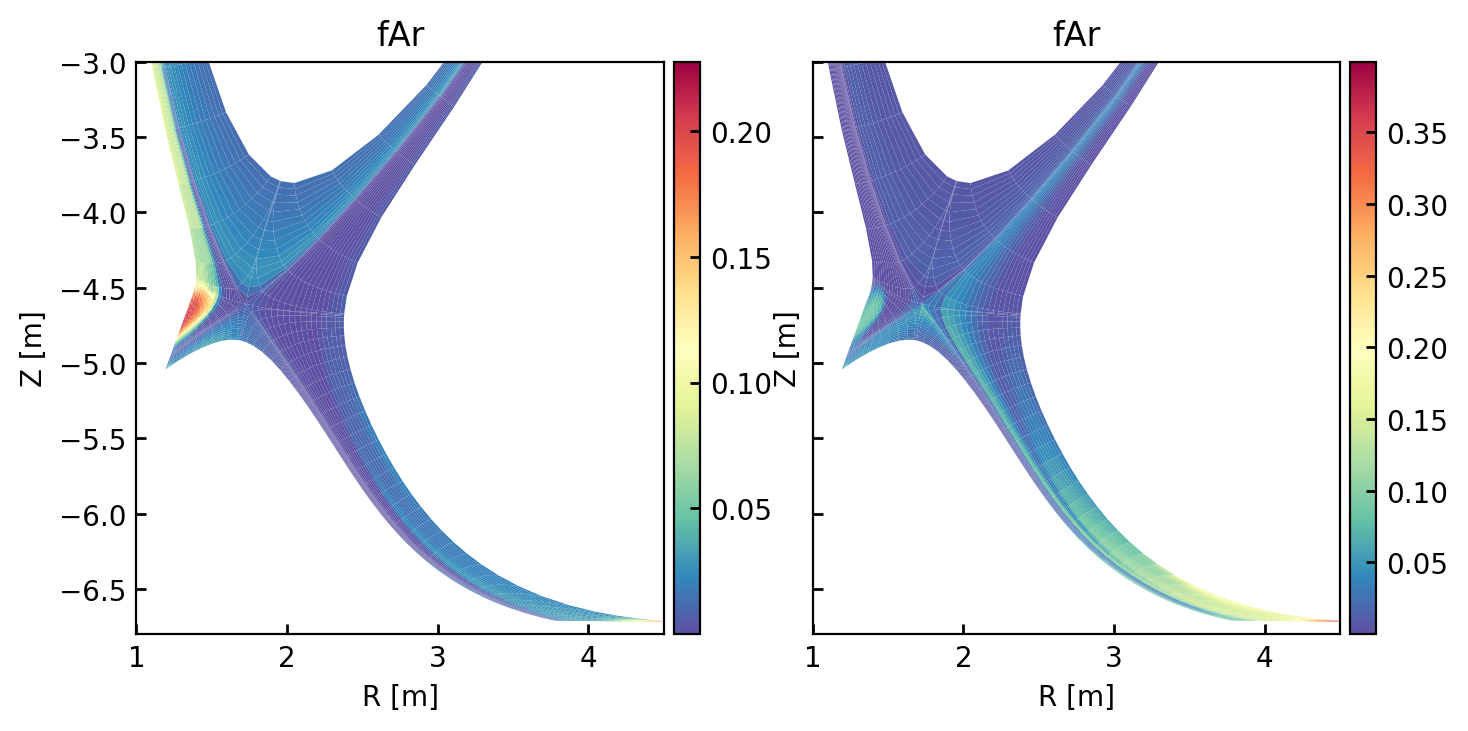

In [17]:
fig, axes = plt.subplots(1,2, dpi = 200, figsize = (8,8), sharey = True)

param = "fAr"
vmax = None
vmin = None
logscale = False

store_slc["100MW_inner_arpuff"].plot_2d(param = param,  ax = axes[0], 
            linewidth = 0, antialias = True, grid_only = False, vmax = vmax, vmin = vmin, logscale = logscale, separatrix = False,
            custom_cmap = "Spectral_r", cbar = True, axis_labels = False, alpha = 1)

store_slc["100MW_innerar_midplanepuff"].plot_2d(param = param,  ax = axes[1], 
            linewidth = 0, antialias = True, grid_only = False, vmax = vmax, vmin = vmin, logscale = logscale, separatrix = False,
            custom_cmap = "Spectral_r", cbar = True, axis_labels = False, alpha = 1)

for ax in axes:
    ax.grid(False)

    # V10
    ax.set_xlim(1.0, 4.5)
    # ax.set_ylim(-7, -3)
    ax.set_ylim(-6.8, -3)

    ax.set_xlabel("R [m]")
    ax.set_ylabel("Z [m]")
    
fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_2D_fAr.pdf", format = "pdf")

# Case comparison

## Calculate field lines

In [114]:
dfs = {}
case = '100MW_innerar_midplanepuff'

sepadds = 6

for case in ["100MW_inner_arpuff", "100MW_innerar_midplanepuff"]:
    dfs[case] = {}
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        dfs[case][region] = {}
        
        for i in range(sepadds):
            df = store_slc[case].get_1d_poloidal_data(["RAr","M", "Pe", "Te", "Ne", "fAr", "Btot", "R", "fhx_total", "fhex_cond", "Sd+_iz", "vol"], sepadd = i, region = region, target_first = True)   
            cumR = sp.integrate.cumulative_trapezoid(y = df["RAr"] / df["Btot"], x = df["Spar"], initial = 0)    
            df["cumR"] = cumR/cumR[-1]
            df["hf_tot"] = df["fhx_total"] / df["apar"] * -1
            df["hf_cond_e"] = df["fhex_cond"] / df["apar"] * -1
            
            dfs[case][region][i] = df

colors = [plt.cm.get_cmap("rainbow", sepadds)(x) for x in range(sepadds)]
line_style = dict(lw = 0.75, marker = "o", ms = 1.5)
xpoint_style = dict(marker = "x", ms = 7)

C:\Users\mikek\AppData\Local\Temp\ipykernel_48580\2888085358.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap("rainbow", sepadds)(x) for x in range(sepadds)]


In [257]:
slc = store_slc[case]

[print(x) for x in slc.params if "hce" in x]

[]

## Front width

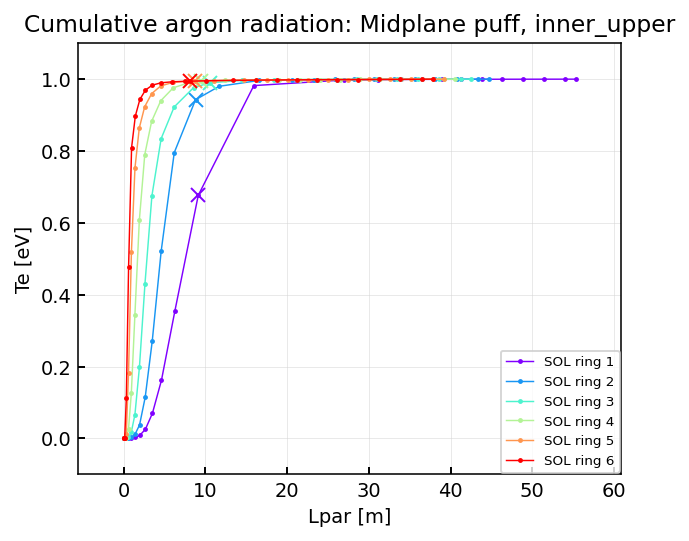

In [296]:
case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'
region = "inner_upper"

fig, ax = plt.subplots()
for i in range(sepadds):
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["cumR"], color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["cumR"], color = colors[i], **xpoint_style) 
    
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("$\int{Q_{Ar}}\ ds_{\parallel}$ (normalised)")

if case in labels.keys():
    name = labels[case]
else:
    name = case
ax.set_title(f"Cumulative argon radiation: {name}, {region}")
ax.set_ylabel("Te [eV]")
ax.legend(fontsize = "x-small")

## Total parallel heat flux weighted front width

True
yes
0.056062815234297785


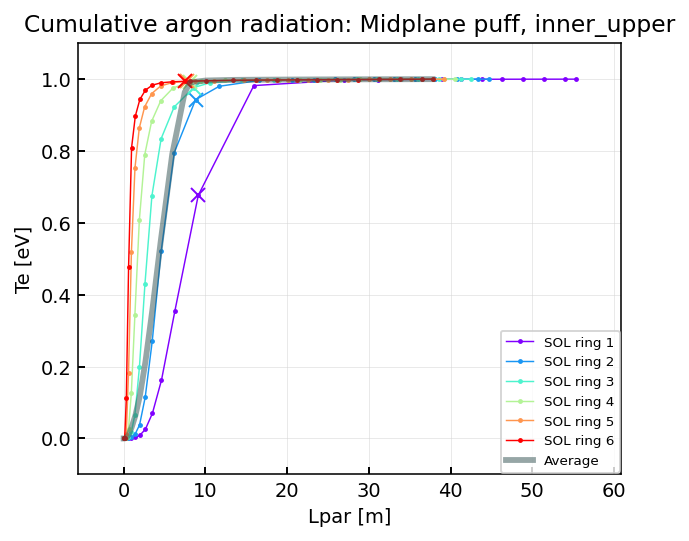

In [234]:
case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'
# region = "outer_upper"
region = "inner_upper"

fig, ax = plt.subplots()
df = slc.get_1d_radial_data(["fhex_total", "fhex_cond"], region = "omp", keep_geometry = True, guards = False)
df["hf_tot"] = df["fhex_total"] / df["apar"] * -1
df["hf_cond_e"] = df["fhex_cond"] / df["apar"] * -1

omp_hflux = df.copy()
omp_hflux = omp_hflux[omp_hflux["dist"] > 0].reset_index(drop = True)
df_weighted = pd.DataFrame()

for i in range(sepadds):
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    df_weighted[i] = df["RAr"] * omp_hflux.loc[i, "hf_tot"]
    ax.plot(df["Spar"], df["cumR"], color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["cumR"], color = colors[i], **xpoint_style) 
    
df_weighted = df_weighted / omp_hflux["hf_tot"].sum()
df_weighted = pd.DataFrame(df_weighted.sum(axis = 1), columns = ["RAr"])
cumR = sp.integrate.cumulative_trapezoid(y = df_weighted["RAr"] / df["Btot"], x = df["Spar"], initial = 0)
df_weighted["cumR"] = cumR/cumR[-1]
ax.plot(df["Spar"], df_weighted["cumR"], color = "darkslategrey", lw = 3, alpha = 0.5, ls = "-", label = "Average")

ylims = ax.get_ylim()
ax.set_ylim(ylims)
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("$\int{Q_{Ar}}\ ds_{\parallel}$ (normalised)")

if case in labels.keys():
    name = labels[case]
else:
    name = case
    
ax.set_title(f"Cumulative argon radiation: {name}, {region}")
ax.set_ylabel("Te [eV]")
ax.legend(fontsize = "x-small")

## Total radiation weighted average front width

True
yes
0.056062815234297785


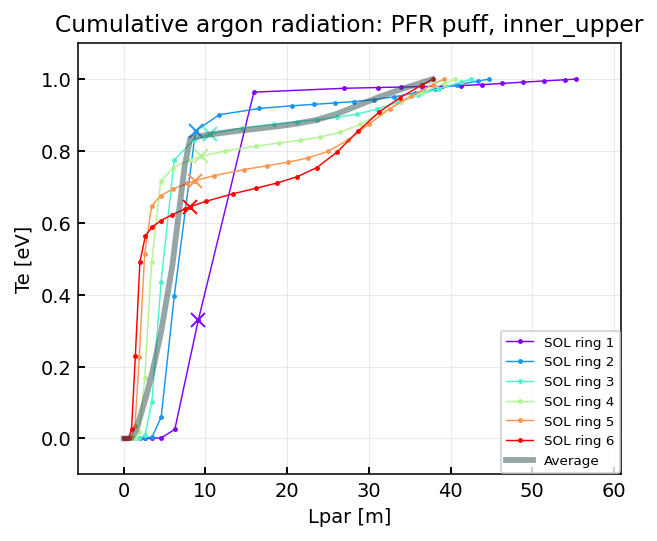

In [298]:
case = '100MW_inner_arpuff'
# case = '100MW_innerar_midplanepuff'
# region = "outer_upper"
region = "inner_upper"

fig, ax = plt.subplots()
df = slc.get_1d_radial_data(["fhex_total", "fhex_cond"], region = "omp", keep_geometry = True, guards = False)
df["hf_tot"] = df["fhex_total"] / df["apar"] * -1
df["hf_cond_e"] = df["fhex_cond"] / df["apar"] * -1

omp_hflux = df.copy()
omp_hflux = omp_hflux[omp_hflux["dist"] > 0].reset_index(drop = True)
df_weighted = pd.DataFrame()

for i in range(sepadds):
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    df_weighted[i] = df["RAr"] 
    ax.plot(df["Spar"], df["cumR"], color = colors[i], **line_style,  label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["cumR"], color = colors[i], **xpoint_style) 
    
df_weighted = pd.DataFrame(df_weighted.mean(axis = 1), columns = ["RAr"])
cumR = sp.integrate.cumulative_trapezoid(y = df_weighted["RAr"] / df["Btot"], x = df["Spar"], initial = 0)
df_weighted["cumR"] = cumR/cumR[-1]
ax.plot(df["Spar"], df_weighted["cumR"], color = "darkslategrey", lw = 3, alpha = 0.5, ls = "-", label = "Average")

ylims = ax.get_ylim()
ax.set_ylim(ylims)
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("$\int{Q_{Ar}}\ ds_{\parallel}$ (normalised)")

if case in labels.keys():
    name = labels[case]
else:
    name = case
    
ax.set_title(f"Cumulative argon radiation: {name}, {region}")
ax.set_ylabel("Te [eV]")
ax.legend(fontsize = "x-small")

In [204]:
omp_hflux["hf_tot"].sum()

96036864.97969772

## Total radiation

(10000.0, 500000000.0)

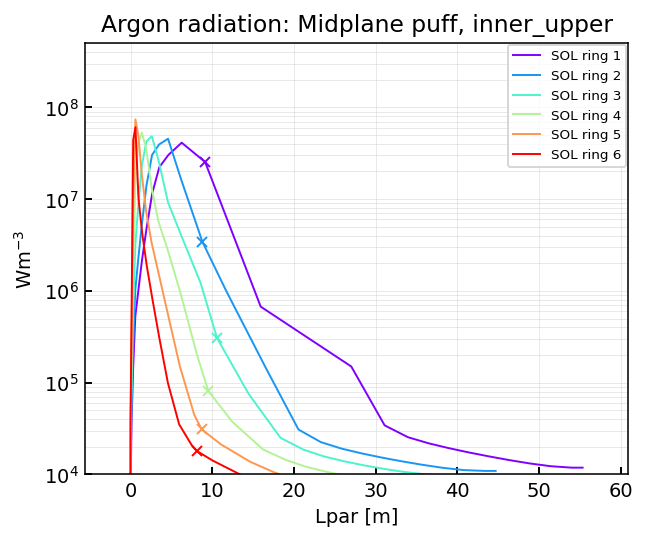

In [ ]:
# case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'
region = "inner_upper"
# region = "

fig, ax = plt.subplots()
for i in range(sepadds):
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["RAr"], color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["RAr"], color = colors[i], **xpoint_style) 
    
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("$\int{Q_{Ar}}\ ds_{\parallel}$ (normalised)")

if case in labels.keys():
    name = labels[case]
else:
    name = case
ax.set_title(f"Argon radiation: {name}, {region}")
ax.set_ylabel("$Wm^{-3}$")
ax.legend(fontsize = "x-small")
ax.set_yscale("log")
ax.set_ylim(1e4, 5e8)

## Density

In [1]:
case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'
# region = "inner_upper"
region = "outer_upper"
# region = "outer_lower"
# region = "

fig, ax = plt.subplots()
for i in range(sepadds):
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["Ne"], color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["Ne"], color = colors[i], **xpoint_style) 

if case in labels.keys():
    name = labels[case]
else:
    name = case
    
ax.set_title(f"Density: {name}, {region}")
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("$m^{-3}$")
ax.legend(fontsize = "x-small")
ax.set_yscale("log")
ax.set_ylim(5e18, 5e21)

NameError: name 'plt' is not defined

KeyError: 'Pe'

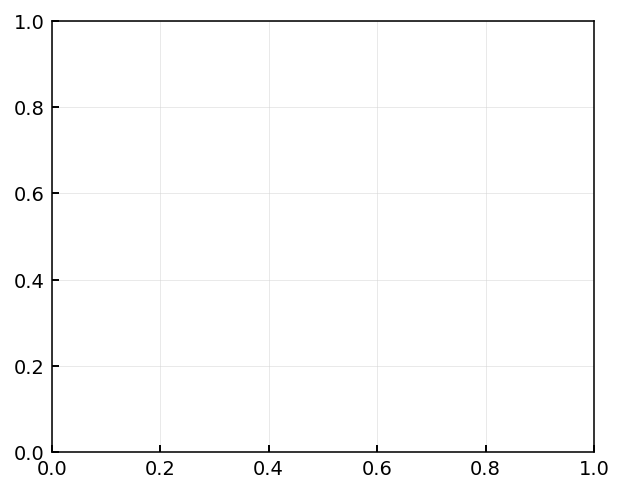

In [100]:
case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'
# region = "inner_upper"
region = "outer_upper"
# region = "outer_lower"
# region = "

fig, ax = plt.subplots()
for i in range(sepadds):
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["Pe"], color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["Pe"], color = colors[i], **xpoint_style) 

if case in labels.keys():
    name = labels[case]
else:
    name = case
    
ax.set_title(f"Density: {name}, {region}")
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("$m^{-3}$")
ax.legend(fontsize = "x-small")
ax.set_yscale("log")
# ax.set_ylim(5e18, 5e21)

## Ionisation

In [88]:
dfs["100MW_innerar_midplanepuff"].keys()

dict_keys(['outer_upper', 'inner_upper'])

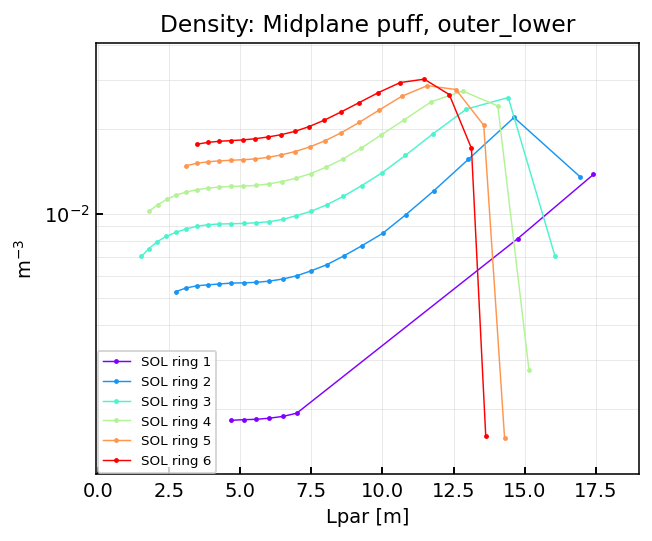

In [111]:
# case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'
# region = "inner_upper"
region = "outer_lower"

fig, ax = plt.subplots()
for i in range(sepadds):
    df = dfs[case][region][i]
    df = df.query(f"region == 'divertor' & Te > 15")
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["vol"], color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    # ax.plot(df["Spar"], df["Sd+_iz"]*df["vol"], color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    # ax.plot(dfx["Spar"], dfx["Sd+_iz"]*dfx["vol"], color = colors[i], **xpoint_style) 

if case in labels.keys():
    name = labels[case]
else:
    name = case
    
ax.set_title(f"Density: {name}, {region}")
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("$m^{-3}$")
ax.legend(fontsize = "x-small")
ax.set_yscale("log")
# ax.set_ylim(5e18, 5e21)

## Temperature

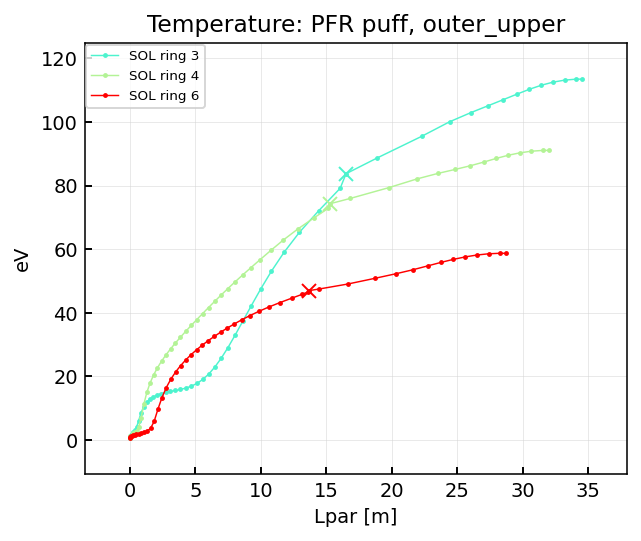

In [120]:
case = '100MW_inner_arpuff'
# case = '100MW_innerar_midplanepuff'
# region = "inner_upper"
region = "outer_upper"
# region = "

fig, ax = plt.subplots()
# for i in range(sepadds):
for i in [2,3,5]:
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["Te"], color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["Te"], color = colors[i], **xpoint_style) 

if case in labels.keys():
    name = labels[case]
else:
    name = case
    
ax.set_title(f"Temperature: {name}, {region}")
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("$eV$")
ax.legend(fontsize = "x-small")


## Mach number

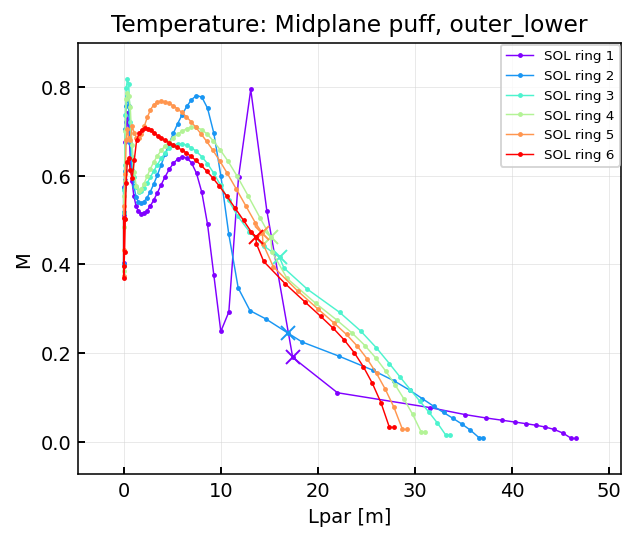

In [93]:
# case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'
region = "outer_lower"
# region = "

fig, ax = plt.subplots()
for i in range(sepadds):
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["M"], color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["M"], color = colors[i], **xpoint_style) 

if case in labels.keys():
    name = labels[case]
else:
    name = case
    
ax.set_title(f"Temperature: {name}, {region}")
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("M")
ax.legend(fontsize = "x-small")


## Heat flux

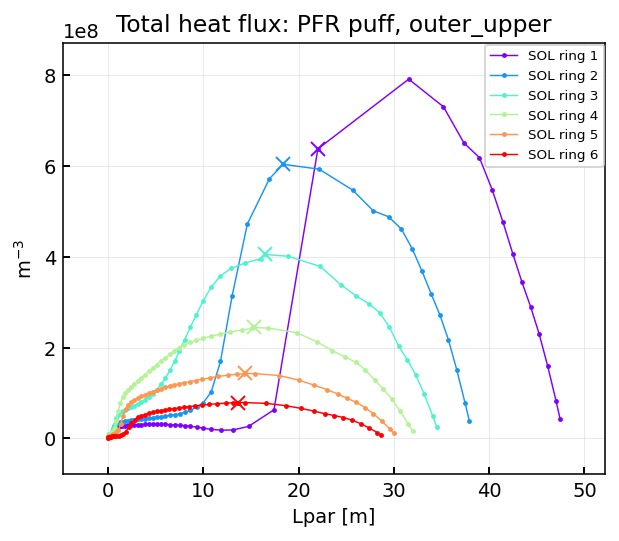

In [235]:
case = '100MW_inner_arpuff'
# case = '100MW_innerar_midplanepuff'
# region = "inner_upper"
region = "outer_upper"
# region = "
mult = -1 if "inner" in region else 1

fig, ax = plt.subplots()
for i in range(sepadds):
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["hf_tot"]*mult, color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["hf_tot"]*mult, color = colors[i], **xpoint_style) 

if case in labels.keys():
    name = labels[case]
else:
    name = case
    
ax.set_title(f"Total heat flux: {name}, {region}")
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("$m^{-3}$")
ax.legend(fontsize = "x-small")
# ax.set_yscale("log")
# ax.set_ylim(5e18, 5e21)

## Kappa0  

7283.993825749434


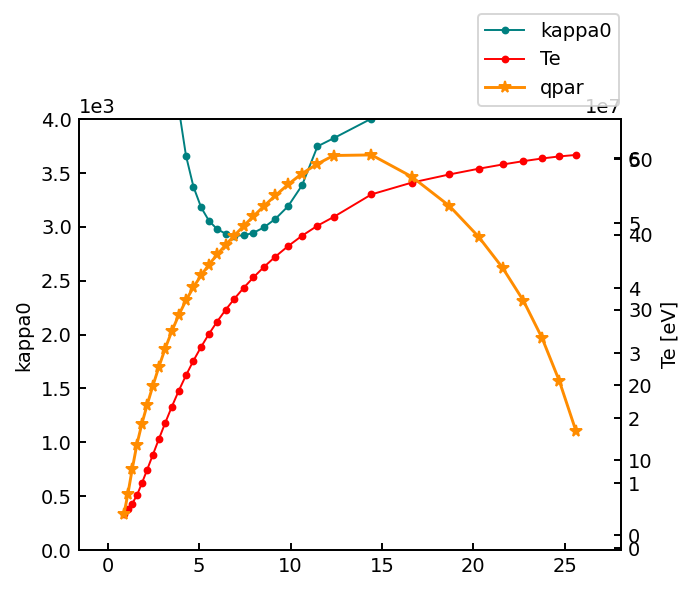

In [258]:
self = store_slc["100MW_innerar_midplanepuff"]
sepadd = 5
region = "outer_lower"
target_first = True
plot = True
total_hflux = True

df = self.get_1d_poloidal_data(["Te", "fhex_cond", "fhx_total"], 
                                  sepadd = sepadd, region = region, target_first = target_first)
                                  

if "outer_upper" in region or "inner_lower" in region:
    mult = -1
else:
    mult = 1
    
if total_hflux:
    df["qpar"] = df["fhx_total"] / df["apar"] * mult
else:
    df["qpar"] = df["fhex_cond"] / df["apar"] * mult

### TRIM FIELD LINE
df = df.iloc[1:-1] # Remove guard cells
# df = df[df["Te"]>10] # Discard below front (temp)
qpar_front_idx = df[df["qpar"] > df["qpar"].max() * 0.05].index[0]  # Discard below front (qpar)
df = df.iloc[qpar_front_idx:]
df = df.iloc[:-2]

# Skip points around X-point due to temperature gradient anomaly
xpoint_index = df[df["Xpoint"] == 1].index[0]
skip_indices = [xpoint_index-1, xpoint_index, xpoint_index+1]
df = df[~df.index.isin(skip_indices)]

### Kappa calc
df["gradT"] = np.gradient(df["Te"], df["Spar"])
df = df[df["gradT"]>0]  # Discard negative T gradient

df["kappa0"] = df["qpar"] / (df["Te"]**(5/2) * df["gradT"]) 
df["kappa0_times_qpar"] = df["kappa0"] * df["qpar"]

if plot:
    dfx = df[df["Xpoint"]==1]
    fig, ax = plt.subplots()
    ax.plot(df["Spar"], df["kappa0"], marker = "o", label = "kappa0", ms = 3, lw = 1)
    ax.plot(dfx["Spar"], dfx["kappa0"], lw = 0, marker = "x", ms = 10)
    ax2 = ax.twinx()
    ax2.plot(df["Spar"], df["Te"], c = "r", marker = "o", label = "Te", ms = 3, lw = 1)
    
    ax.set_ylabel("kappa0")
    ax2.set_ylabel("Te [eV]")
    ax3 = ax.twinx()
    ax3.plot(df["Spar"], df["qpar"], c = "darkorange", marker = "*", label = "qpar")
    
    for x in [ax, ax2, ax3]:
        x.grid(which = "both", visible = False)
    fig.legend(loc = "lower right", bbox_to_anchor = (0.9, 0.9))
    
    ax.set_ylim(0,4000)
    
kappa_weighted_mean = (df["kappa0_times_qpar"] / df["qpar"].sum()).sum()
print(kappa_weighted_mean)

2129.416307423112
3289.9129435865434
2861.09503501397
3470.835882079298
4971.166548336062


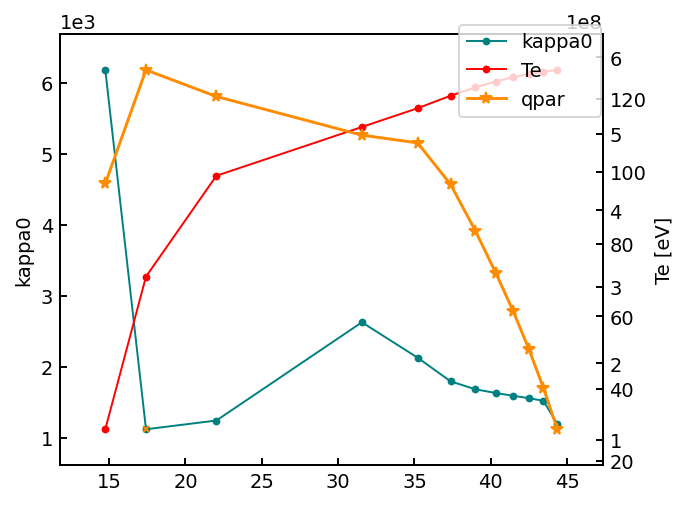

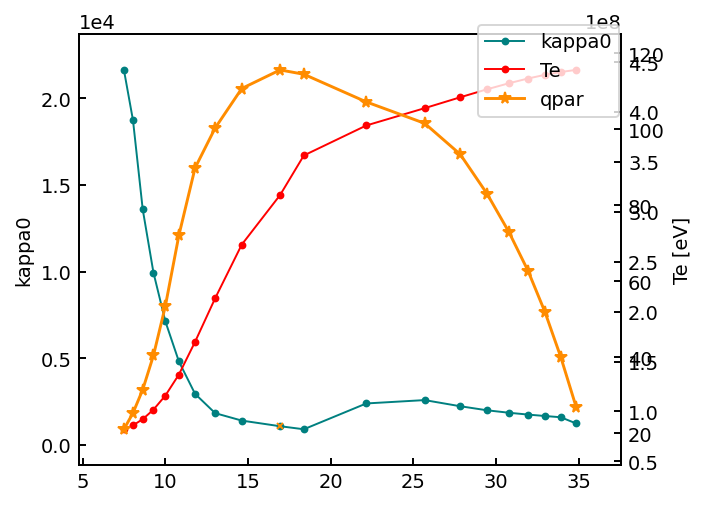

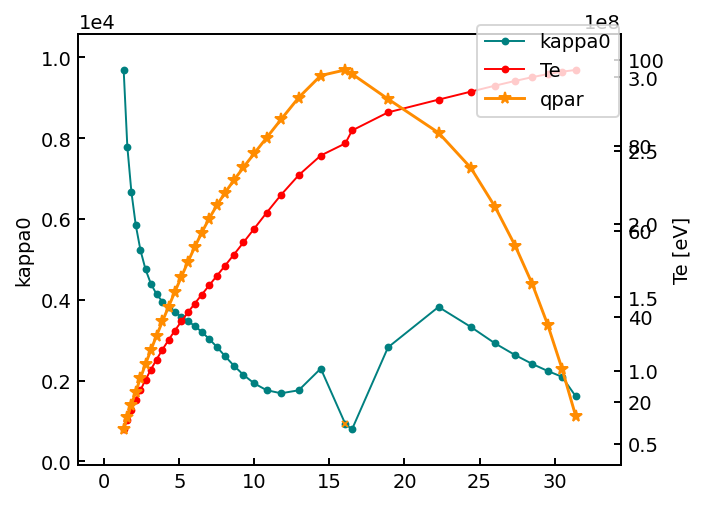

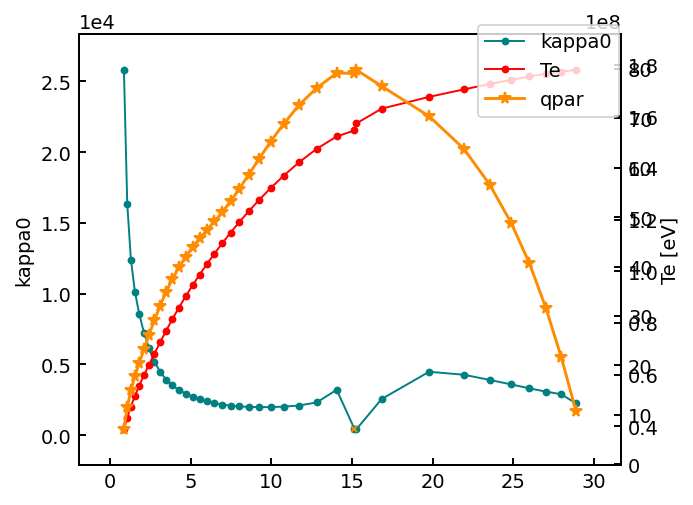

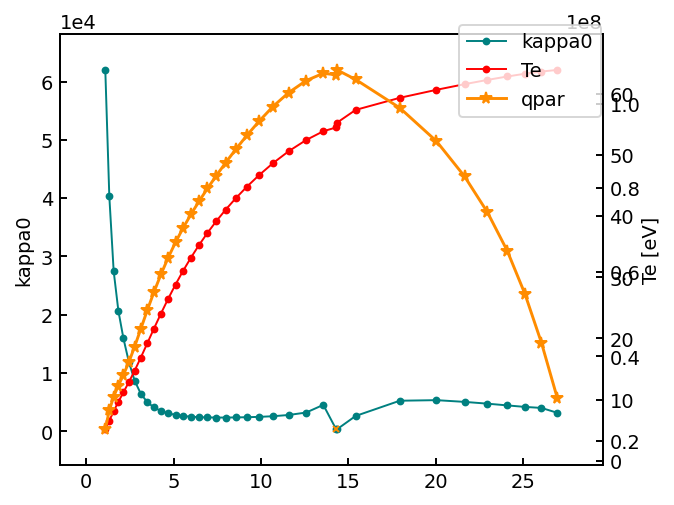

In [267]:
region = "outer_lower"

for i in range(5):
    kappa = store_slc[case].extract_kappa0(sepadd = i, region = region, plot = True, total_hflux = True, skip_xpoint = False)
    print(kappa)

## Impurity fraction

(0.0, 0.08)

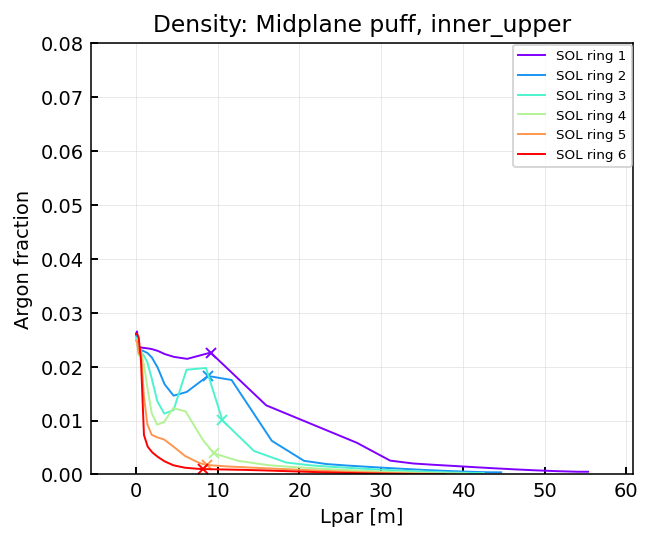

In [ ]:
case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'
# region = "inner_upper"
# region = "

fig, ax = plt.subplots()
for i in range(sepadds):
    df = dfs[case][region][i]
    dfx = df[df["Xpoint"]==1]
    ax.plot(df["Spar"], df["fAr"], color = colors[i], **line_style, label = f"SOL ring {i+1}") 
    ax.plot(dfx["Spar"], dfx["fAr"], color = colors[i], **xpoint_style) 

if case in labels.keys():
    name = labels[case]
else:
    name = case
    
ax.set_title(f"Density: {name}, {region}")
ax.set_xlabel("Lpar [m]")
ax.set_ylabel("Argon fraction")
ax.legend(fontsize = "x-small")
# ax.set_yscale("log")
ax.set_ylim(0, 0.08)

# Cooling curve work

In [12]:
rd_N = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\nitrogen.nc")
rd_Ar = xr.open_dataset(r"C:\Users\mikek\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

## ADAS interpolation

Text(0.5, 1.0, 'Interpolated N curves')

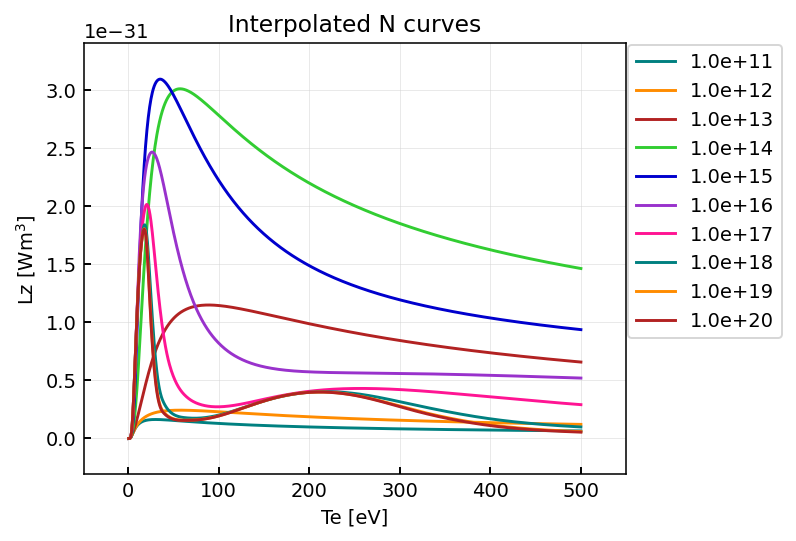

In [13]:
curves = {}
curves["Ar"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["Ar"][netau_name] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )

temps_interp = np.linspace(1, 500, 1000)

fig, ax = plt.subplots()
for netau in curves["Ar"].keys():
    ax.plot(temps_interp, [curves["Ar"][netau](T) for T in temps_interp], label = f"{netau:.1e}")
    
ax.legend(loc = "upper left", bbox_to_anchor=(1,1))
# ax.set_xlim(0,2)
# ax.set_ylim(0,1e-35)
# ax.set_yscale("log")
ax.set_xlabel("Te [eV]")
ax.set_ylabel("Lz [$Wm^{3}$]")
ax.set_title("Interpolated N curves")

### Paper plot - outer

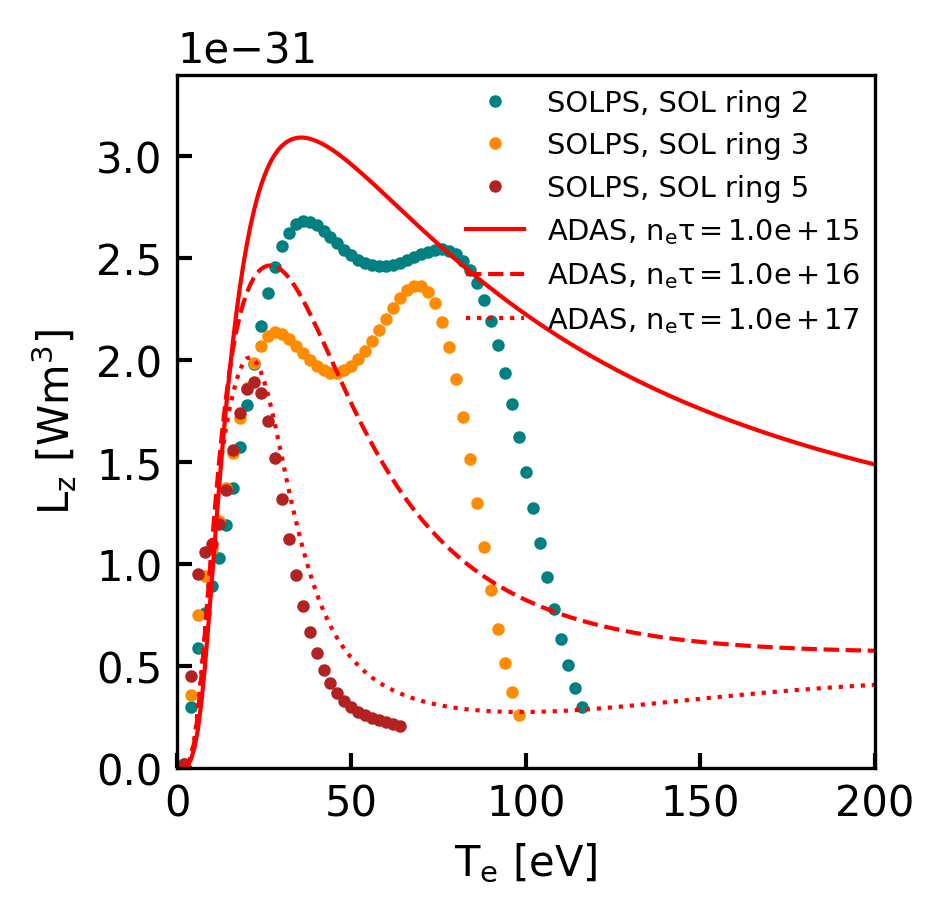

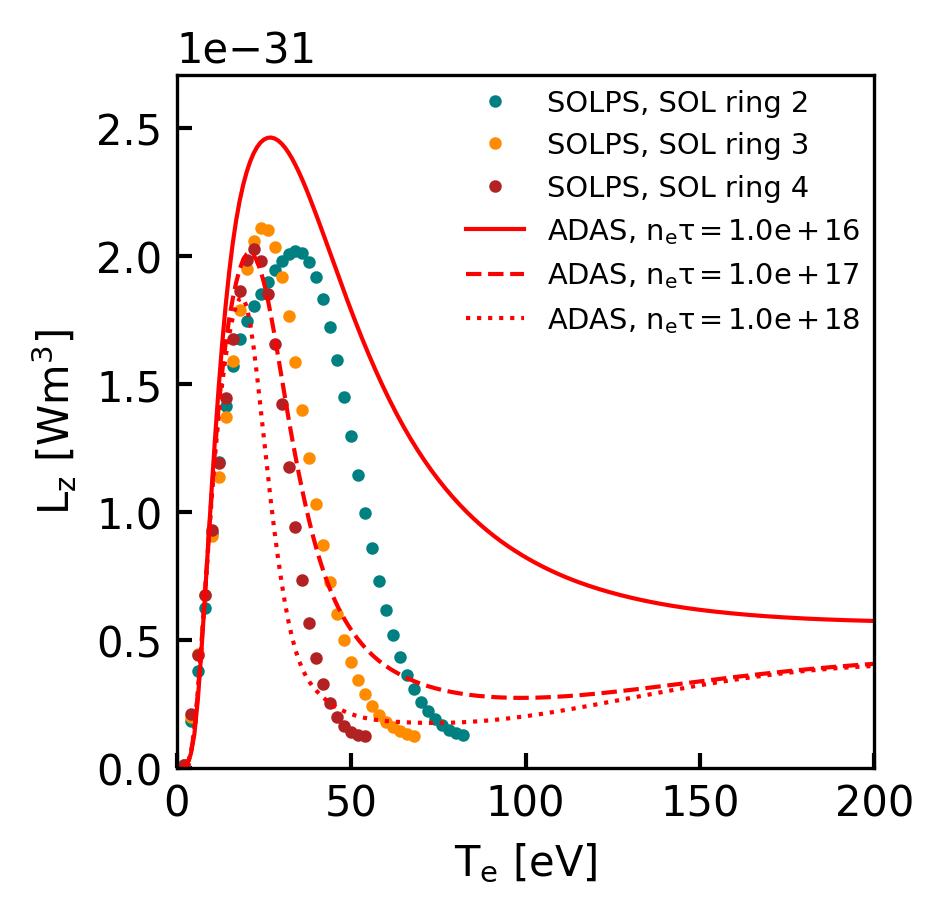

In [14]:
ring_choice = dict(outer_lower = [1,2,4], inner_lower = [1,2,3])

for region in ["outer_lower", "inner_lower"]:
# for region in ["inner_lower"]:

    species = "Ar"

    fig, ax = plt.subplots(figsize = (3,3), dpi = 300)

    Tlo = 1
    Thi = 500

    T = np.linspace(Tlo, Thi, 500)

    df_curves = []
    for i in ring_choice[region]:
        slc = store_slc[case]
        fun = slc.extract_cooling_curve(species, region, sepadd = i, order = 9, plot = False)

        Lz = [fun(temp) for temp in T]
        
        df_curve = pd.DataFrame()
        df_curve["T"] = T
        df_curve["Lz"] = Lz
        df_curve = df_curve[df_curve["Lz"] > 0]
        df_curves.append(df_curve)
        ax.plot(df_curve["T"][::2], df_curve["Lz"][::2], marker = "o", ms = 2, lw = 0, label = "SOLPS, " + "SOL ring " + str(i+1))
        
    linestyles = ["-", "--", ":"]
    
    if "inner" in region:
        netau_choice = [1e16, 1e17, 1e18]
    elif "outer" in region:
        netau_choice = [1e15, 1e16, 1e17]

    for i, netau in enumerate(netau_choice):
        ax.plot(T, [curves["Ar"][netau](temp) for temp in T], label = rf"ADAS, $n_{{e}}\tau={netau:.1e}$", c = "r", lw = 1, ls = linestyles[i])
    ax.legend(loc = "upper right", ncols = 1, bbox_to_anchor=(1, 1),fontsize = "x-small",  frameon = False)
    ax.set_xlim(0,200)
    ax.set_ylim(0,None)
    ax.set_xlabel("$T_e$ [eV]")
    ax.set_ylabel("$L_{z}$ [$Wm^{3}$]")
    ax.grid(which = "both", visible = False)
    # ax.set_title("Cross-case Lz comparison to ADAS")
    plt.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_coolingcurves_{region}.pdf", format = "pdf", bbox_inches = "tight")

# Special postprocessing

## Kink in IMP temp distribution

Text(0.5, 1.0, 'Sepadd 4')

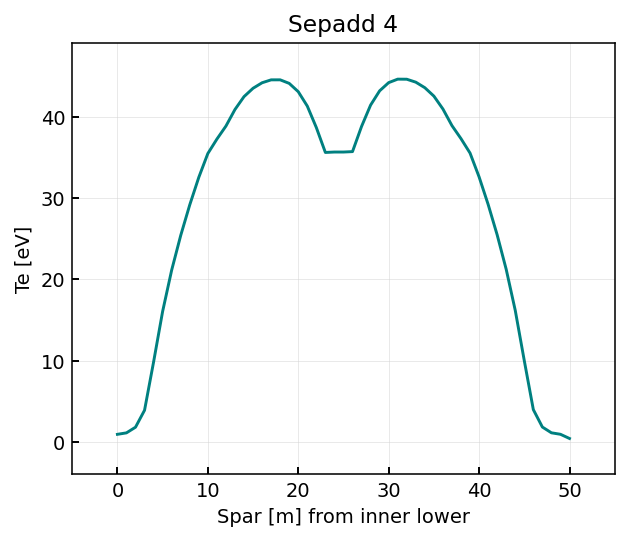

In [210]:
slc = store_slc["100MW_innerar_midplanepuff"]
sepadd = 4
il = slc.get_1d_poloidal_data(["Te"], sepadd = sepadd, region = "inner_lower", target_first = True)
iu = slc.get_1d_poloidal_data(["Te"], sepadd = sepadd, region = "inner_upper", target_first = False)
iu["Spar"] += il["Spar"].iloc[-1]

df = pd.concat([il, iu], axis = 0).reset_index(drop = True)

fig, ax = plt.subplots()
ax.plot(df.index, df["Te"])
ax.set_xlabel("Spar [m] from inner lower")
ax.set_ylabel("Te [eV]")
ax.set_title(f"Sepadd {sepadd}")
# ax.plot(solps["Spar"], solps["qpar"]*-1, marker = "o")

## Resolution

Text(0.5, 1.0, 'Sepadd 0')

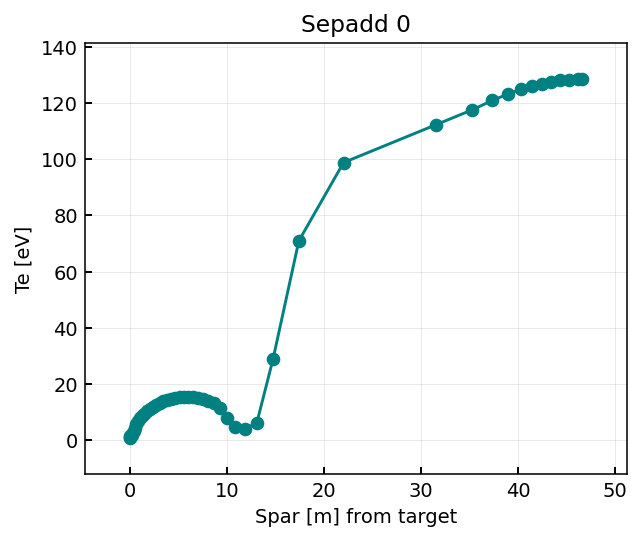

In [216]:
slc = store_slc["100MW_innerar_midplanepuff"]
sepadd = 0
df = slc.get_1d_poloidal_data(["Te"], sepadd = sepadd, region = "outer_lower", target_first = True)

fig, ax = plt.subplots()
ax.plot(df["Spar"], df["Te"], marker = "o")
ax.set_xlabel("Spar [m] from target")
ax.set_ylabel("Te [eV]")
ax.set_title(f"Sepadd {sepadd}")
# ax.plot(solps["Spar"], solps["qpar"]*-1, marker = "o")

## Role of cross-field in SOL ring choice

### Power balance

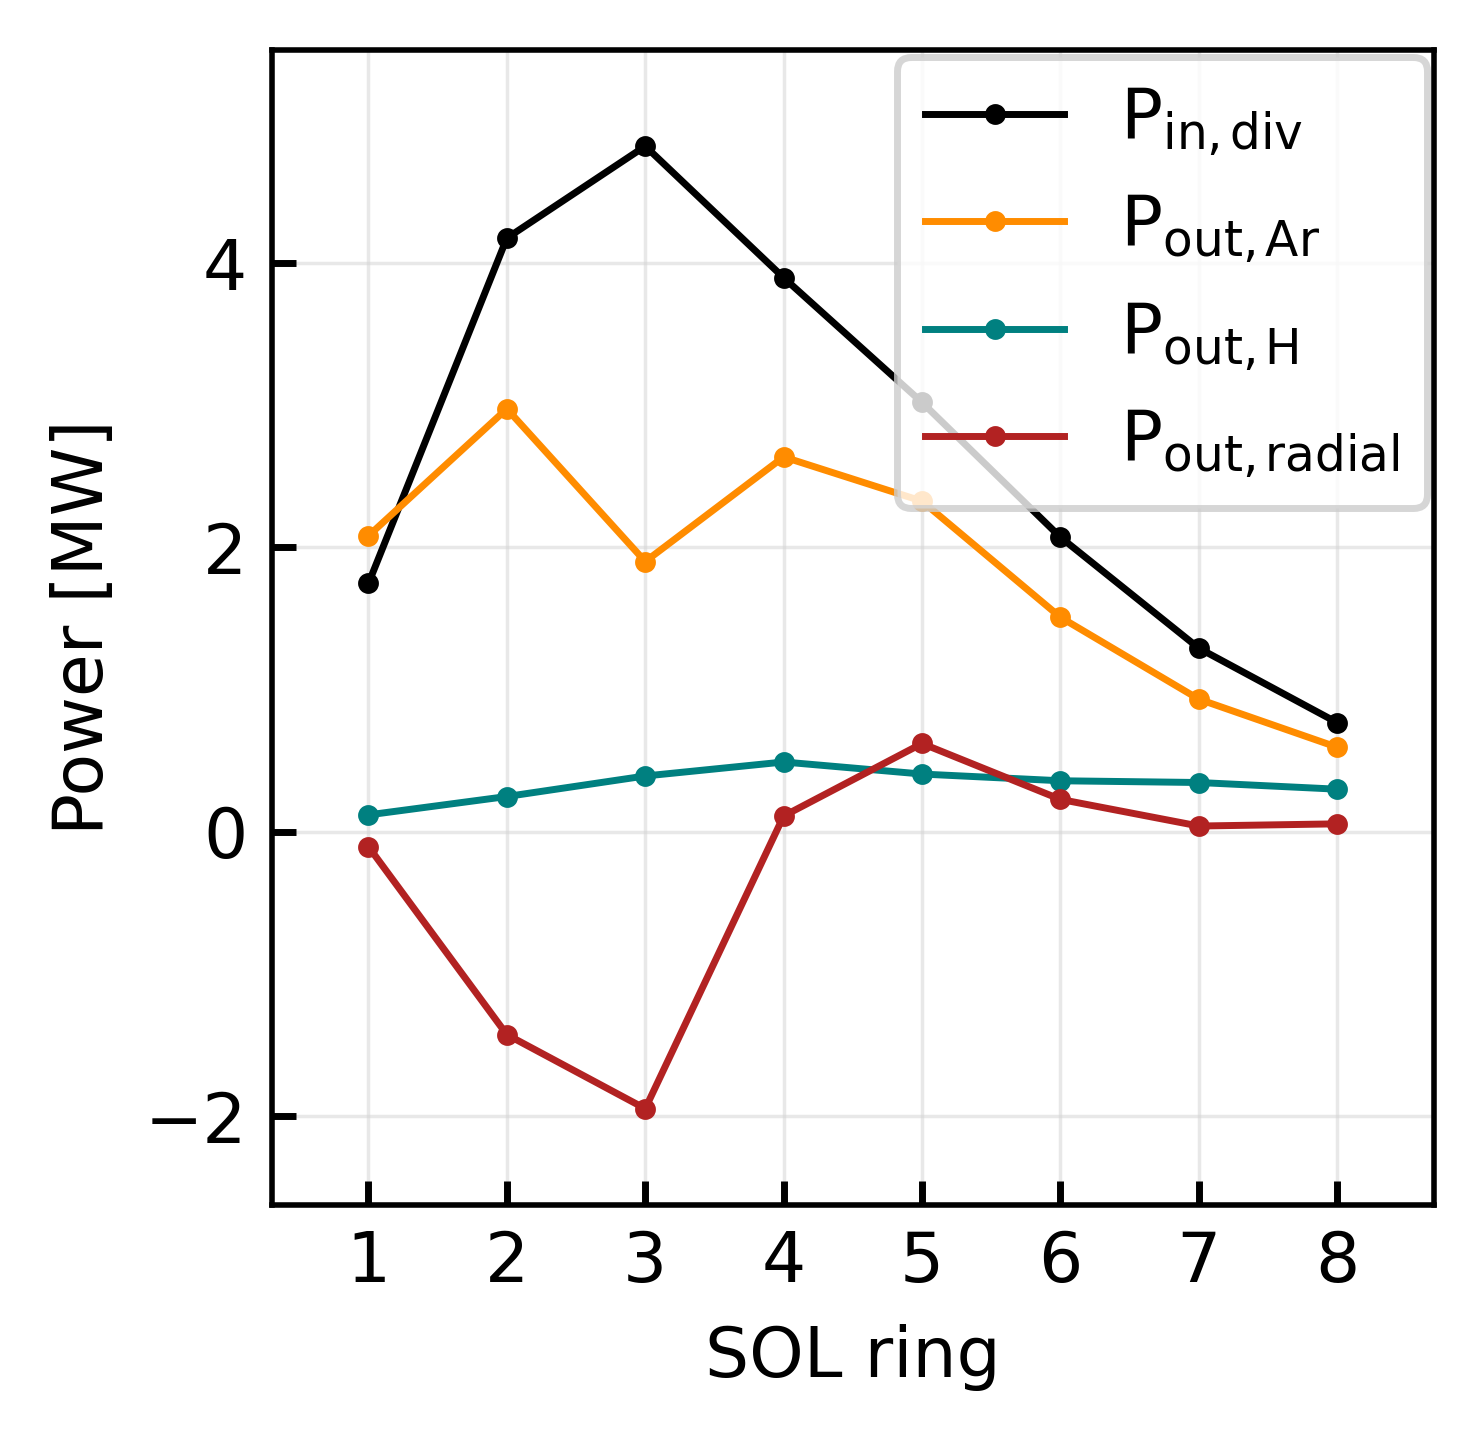

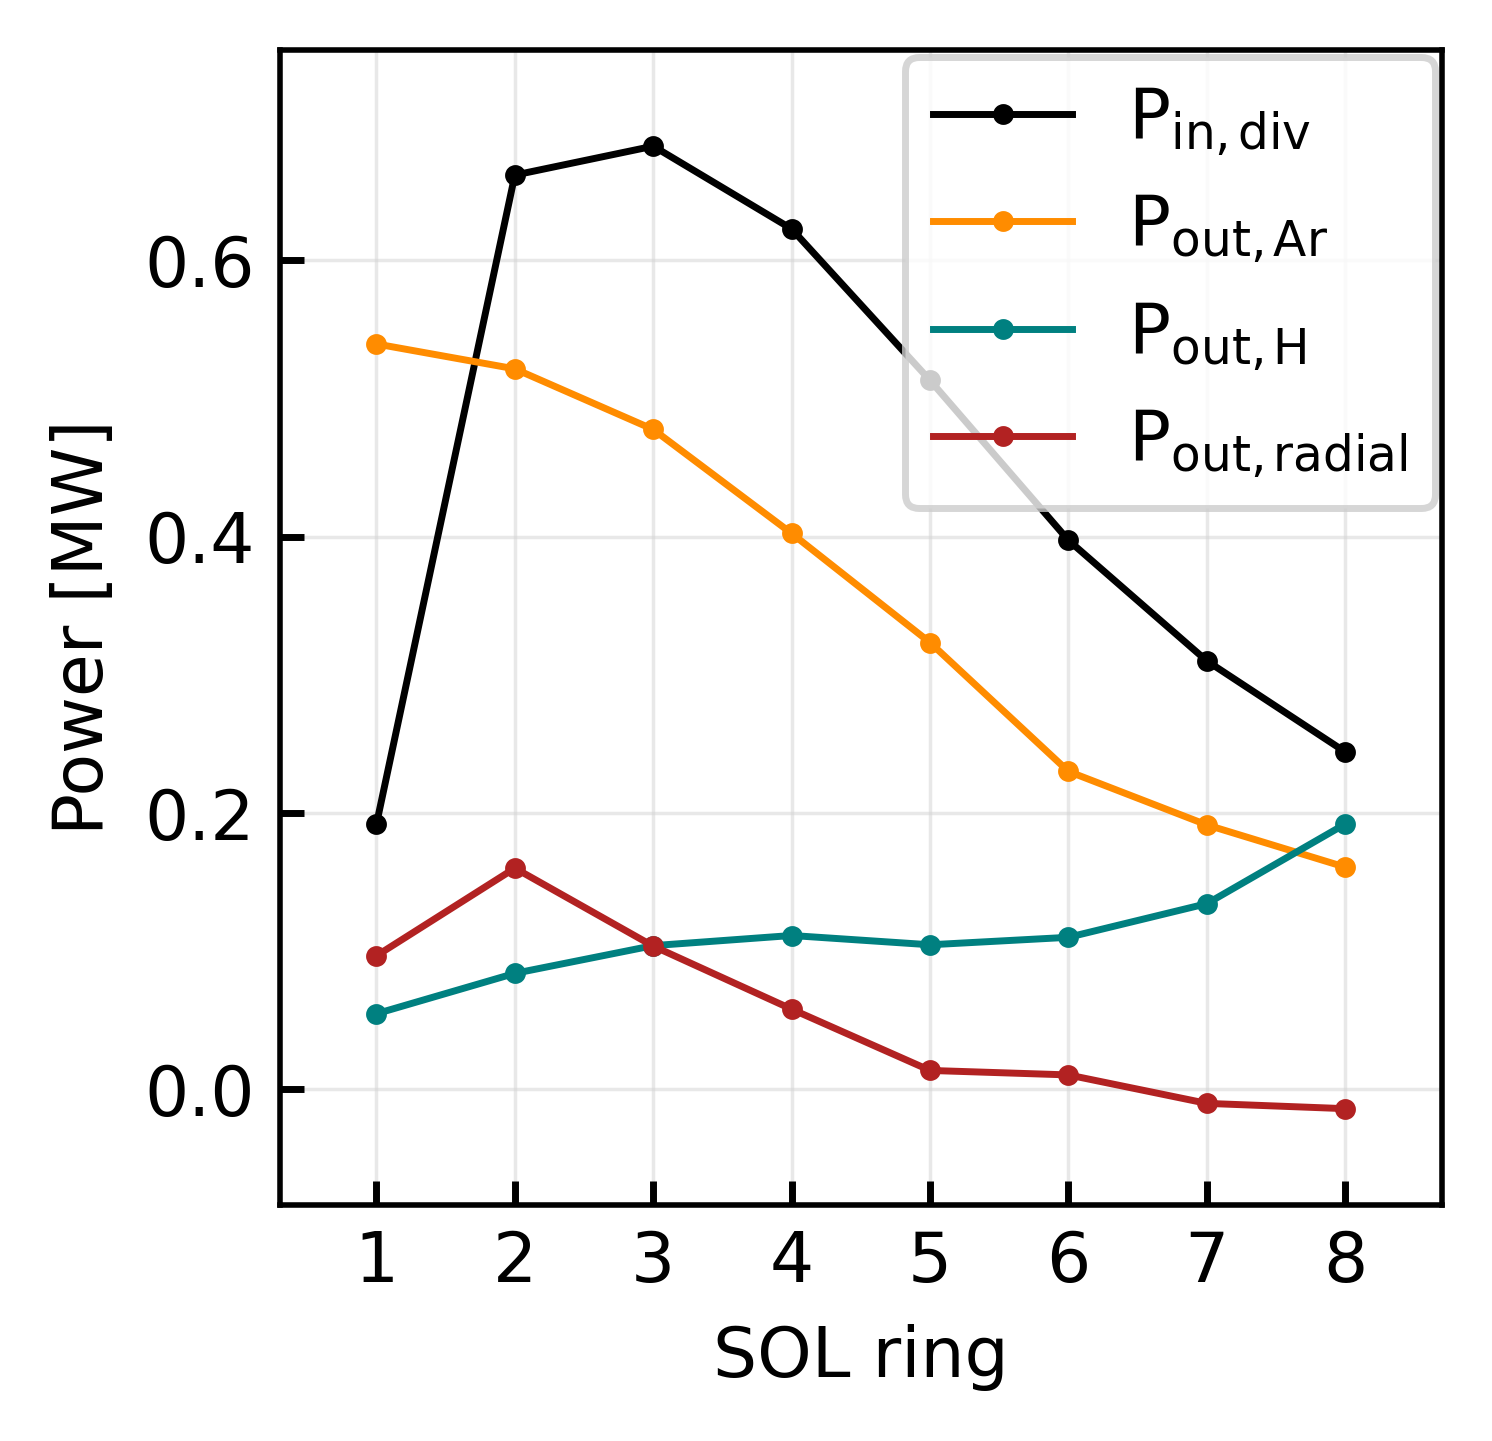

In [182]:
df = pd.DataFrame()

for region in ["outer_lower", "inner_lower"]:
    case = "100MW_innerar_midplanepuff"
    # case = "100MW_inner_arpuff"

    dfs = []
    for sepadd in range(8):
        baldict = store_slc[case].get_leg_energy_balance(
            sepadd = sepadd, region = region, impurities = ["Ar"], plot = False)
        df = pd.DataFrame.from_dict(baldict, orient = "index")
        df.columns = [sepadd+1]
        dfs.append(df)

    df = pd.concat(dfs, axis = 1).T
    df /= 1e6
    # df["Q_allsinks"] = df["Q_Ar"] + df["Q_H"] + df["Q_perp_out"]
    # df["P_radial"] = df["P_radial"].abs()
    fig, ax = plt.subplots(figsize = (3,3), dpi = 500)
    style = dict(marker = "o", ms = 2, lw = 1)
    ax.plot(df.index, abs(df["P_div"]), **style, c = "k",  label = r"$P_{in,div}$")
    ax.plot(df.index, df["P_Ar"], **style, c = "darkorange", label = r"$P_{out,Ar}$")
    ax.plot(df.index, df["P_H"], **style, c = "teal", label = r"$P_{out,H}$")
    ax.plot(df.index, df["P_radial"], **style, c = "firebrick", label = r"$P_{out,radial}$")

    # ax.plot(df.index, df["P_radial_e_bottom"], **style, c = "navy", label = r"$P_{out,radial,btm}$")
    # ax.plot(df.index, df["P_radial_e_top"], **style, c = "darkorange", label = r"$P_{out,radial,top}$")

    # df["P_allsinks"] = df["P_Ar"] + df["P_H"] + df["P_radial"]
    # ax.plot(df.index, df["P_allsinks"], c = "k", ls = ":", alpha = 0.5, label = "$P_{out,all}$")
    # ax2 = ax.twinx()
    # ax2.plot(df.index, df["qpar_mapped_to_target"], **style, ls = ":", c = "k", label = "$q_{\parallel,div}$")
    # ax2.set_ylabel("Heat flux [MW/$m^2$]")
    # ax2.grid(which = "both", visible = False)
    fig.legend(loc = "upper right", bbox_to_anchor = (0.9,0.88))
    ax.set_xlabel("SOL ring")
    ax.set_ylabel("Power [MW]")
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    plt.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_SOLring_powerbalance_{region}.pdf", format = "pdf", bbox_inches = "tight")

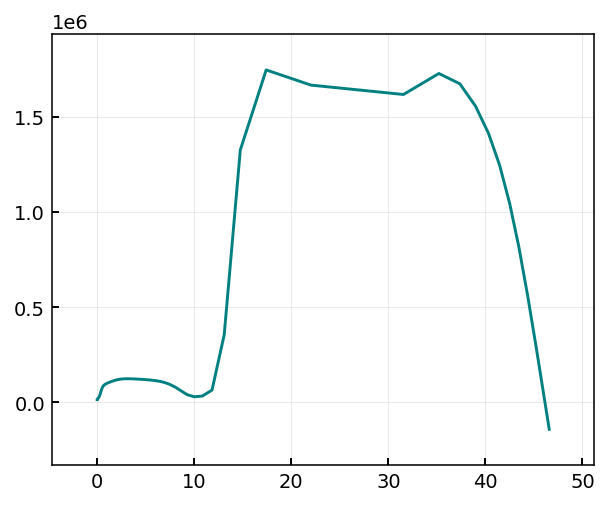

In [126]:
sepadd = 0
impurities = ["Ar"]
self = store_slc["100MW_innerar_midplanepuff"]
region = "outer_lower"

impurity_variables = [f"R{impurity}" for impurity in impurities]

fluxlist = ["fhex_total", "fhey_total", "fhix_total", "fhiy_total", "fhey_32", "fhey_cond", "fhiy_32", "fhiy_cond", "fhx_total"]
fline = self.get_1d_poloidal_data(impurity_variables + fluxlist + ["vol", "Rd+_exiz", "Rd+_mol"], sepadd = sepadd, region = region, target_first = True)
fline_right = self.get_1d_poloidal_data(fluxlist, sepadd = sepadd+1, region = region, target_first = True)
fline_x = fline.query("Xpoint == 1").squeeze()  # First cell after X-point
fline_right_x = fline_right.query("Xpoint == 1").squeeze()
fline_div = fline.query("region == 'divertor'")   # Cells below X-point
fline_right_div = fline_right.query("region == 'divertor'") 
out = {}
for impurity in impurities:
    out[f"P_{impurity}"] = (fline[f"R{impurity}"] * fline["vol"]).sum()
    
out["P_H"] = ((fline["Rd+_exiz"].abs() + fline["Rd+_mol"].abs()) * fline["vol"]).sum()
out["P_div"] = fline_x["fhex_total"] + fline_x["fhix_total"]

fig, ax = plt.subplots()
ax.plot(fline["Spar"], fline["fhx_total"])

### Particle balance

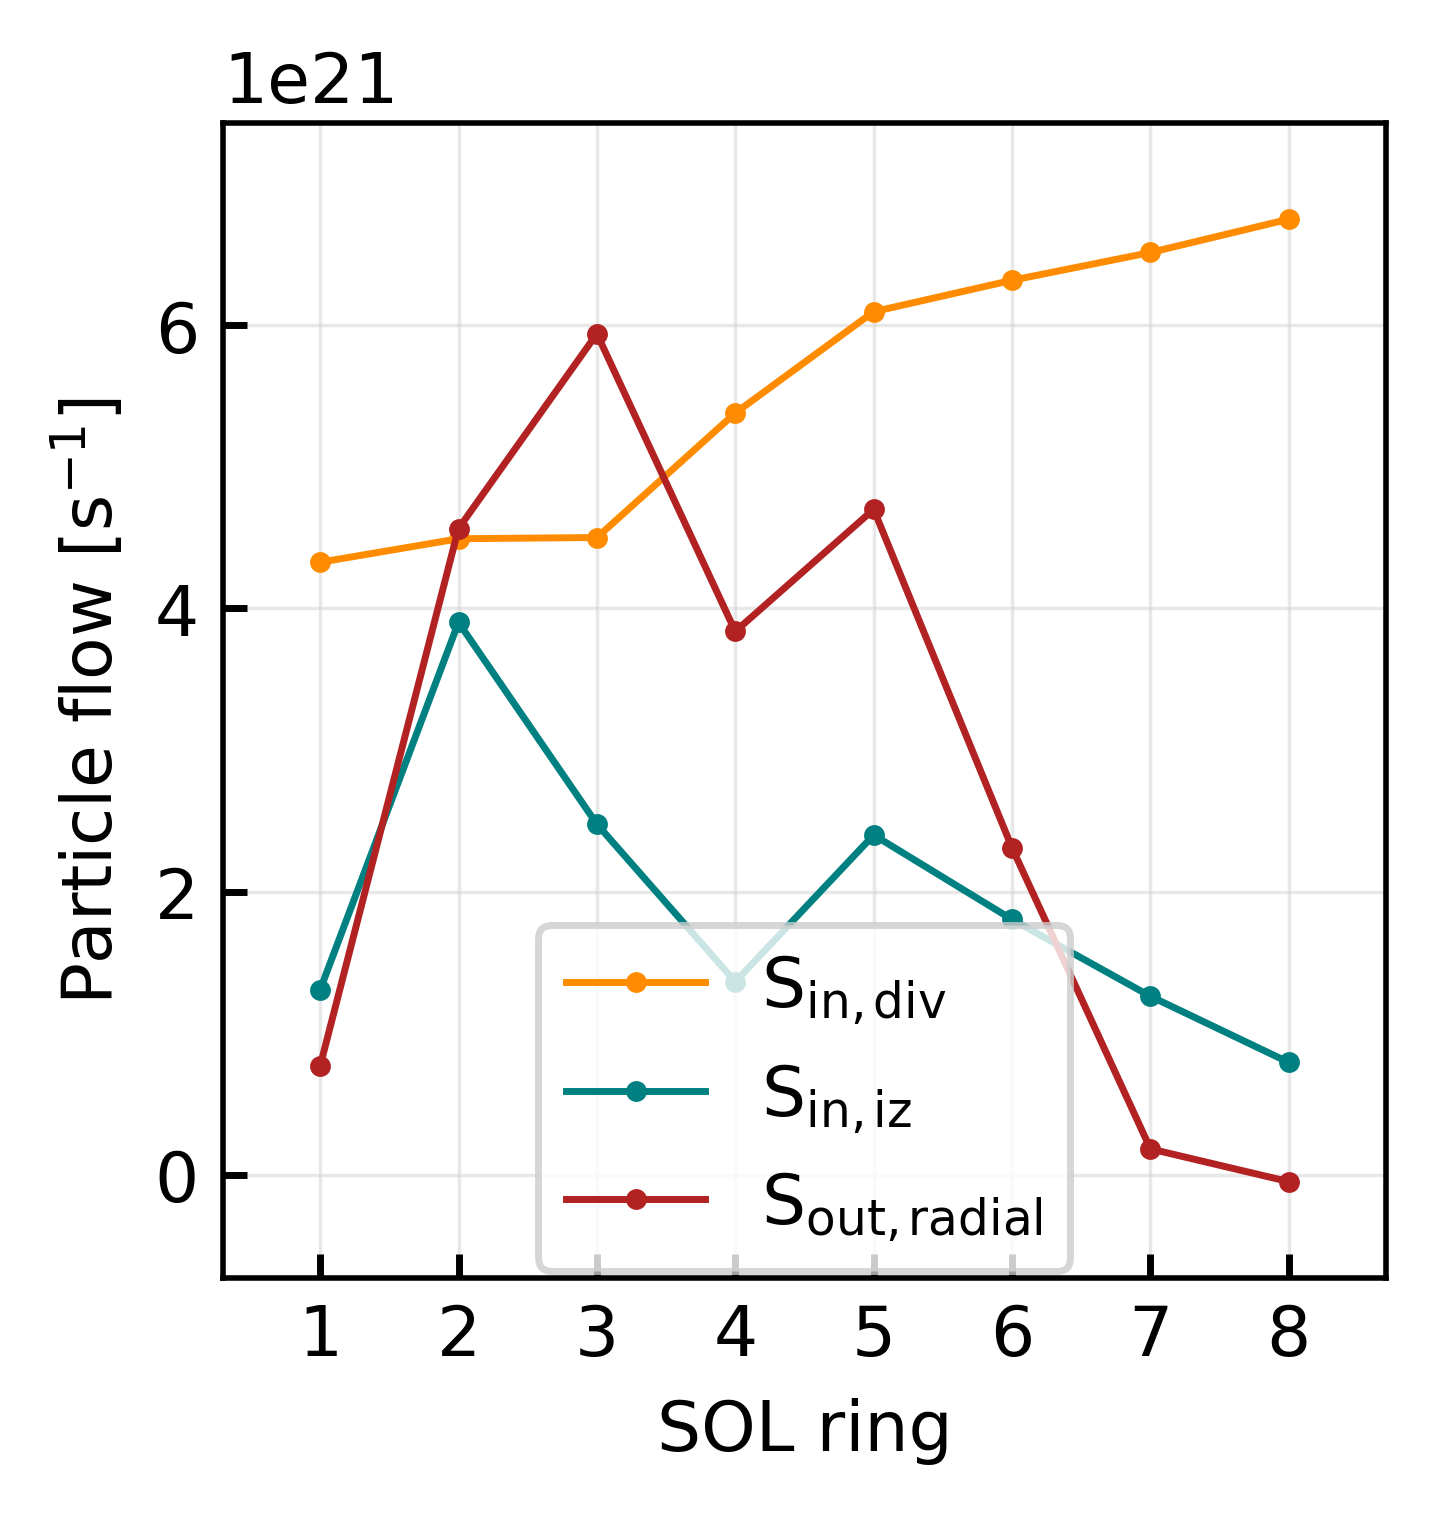

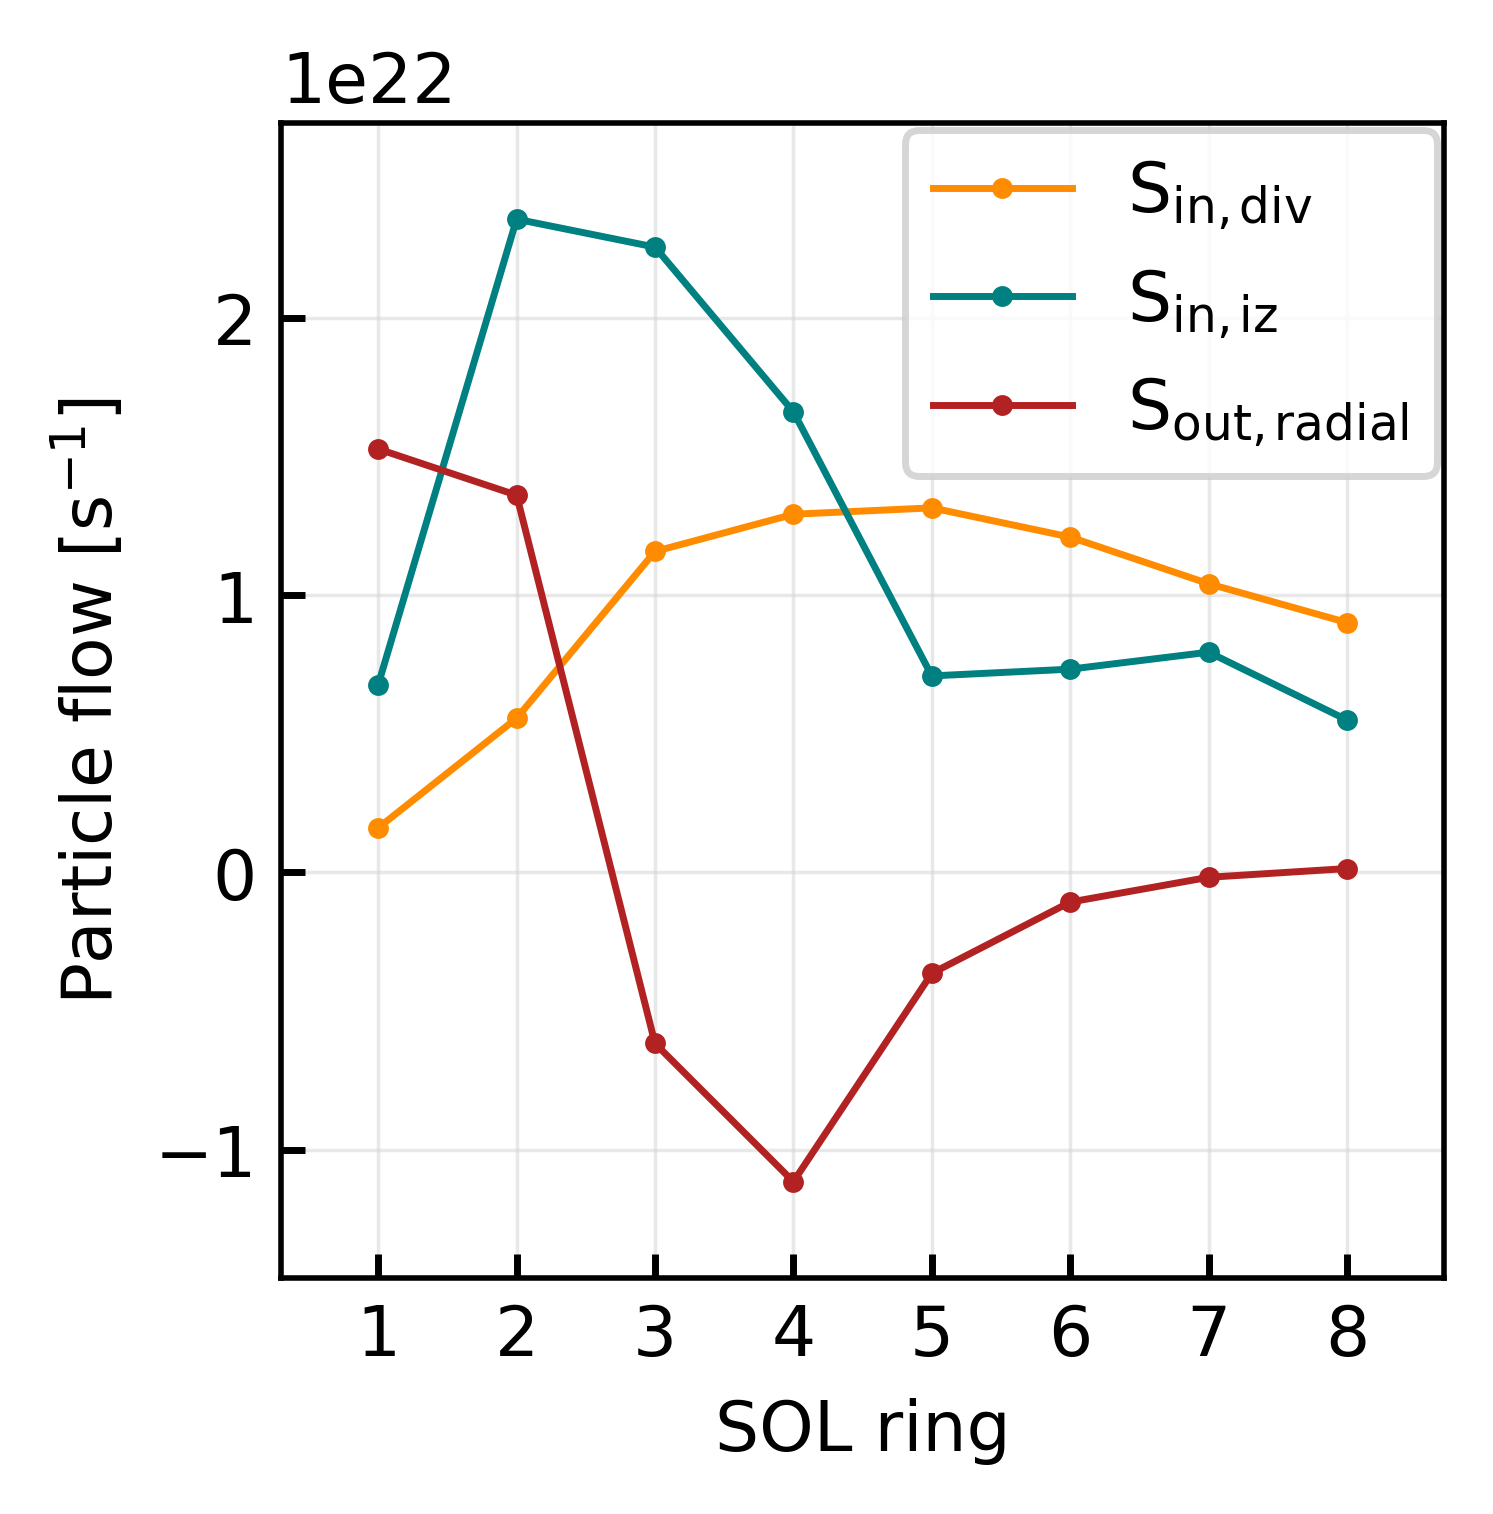

In [183]:
# for region in ["inner_lower", "outer_lower"]:
for region in ["inner_lower", "outer_lower"]:

    df = pd.DataFrame()
    # region = "outer_lower"
    case = "100MW_innerar_midplanepuff"

    dfs = []
    for sepadd in range(8):
        baldict = store_slc[case].get_leg_particle_balance(sepadd = sepadd, region = region, Te_threshold = 15)
        df = pd.DataFrame.from_dict(baldict, orient = "index")
        df.columns = [sepadd+1]
        dfs.append(df)

    df = pd.concat(dfs, axis = 1).T

    fig, ax = plt.subplots(figsize = (3,3), dpi = 500)
    style = dict(marker = "o", ms = 2, lw = 1)
    ax.plot(df.index, df["S_div"], **style, c = "darkorange",  label = r"$S_{in,div}$")
    ax.plot(df.index, df["S_iz"], **style, c = "teal", label = r"$S_{in,iz}$")
    ax.plot(df.index, df["S_radial"], **style, c = "firebrick", label = r"$S_{out,radial}$")
    # ax.set_yscale("symlog")
    ax.legend()
    ax.set_xlabel("SOL ring")
    ax.set_ylabel("Particle flow [$s^{-1}$]")
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    plt.savefig(fr"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_SOLring_particlebalance_{region}.pdf", format = "pdf", bbox_inches = "tight")

### Peak heat flux

In [48]:
store_slc.keys()

dict_keys(['100MW_inner_arpuff', '100MW_innerar_midplanepuff'])

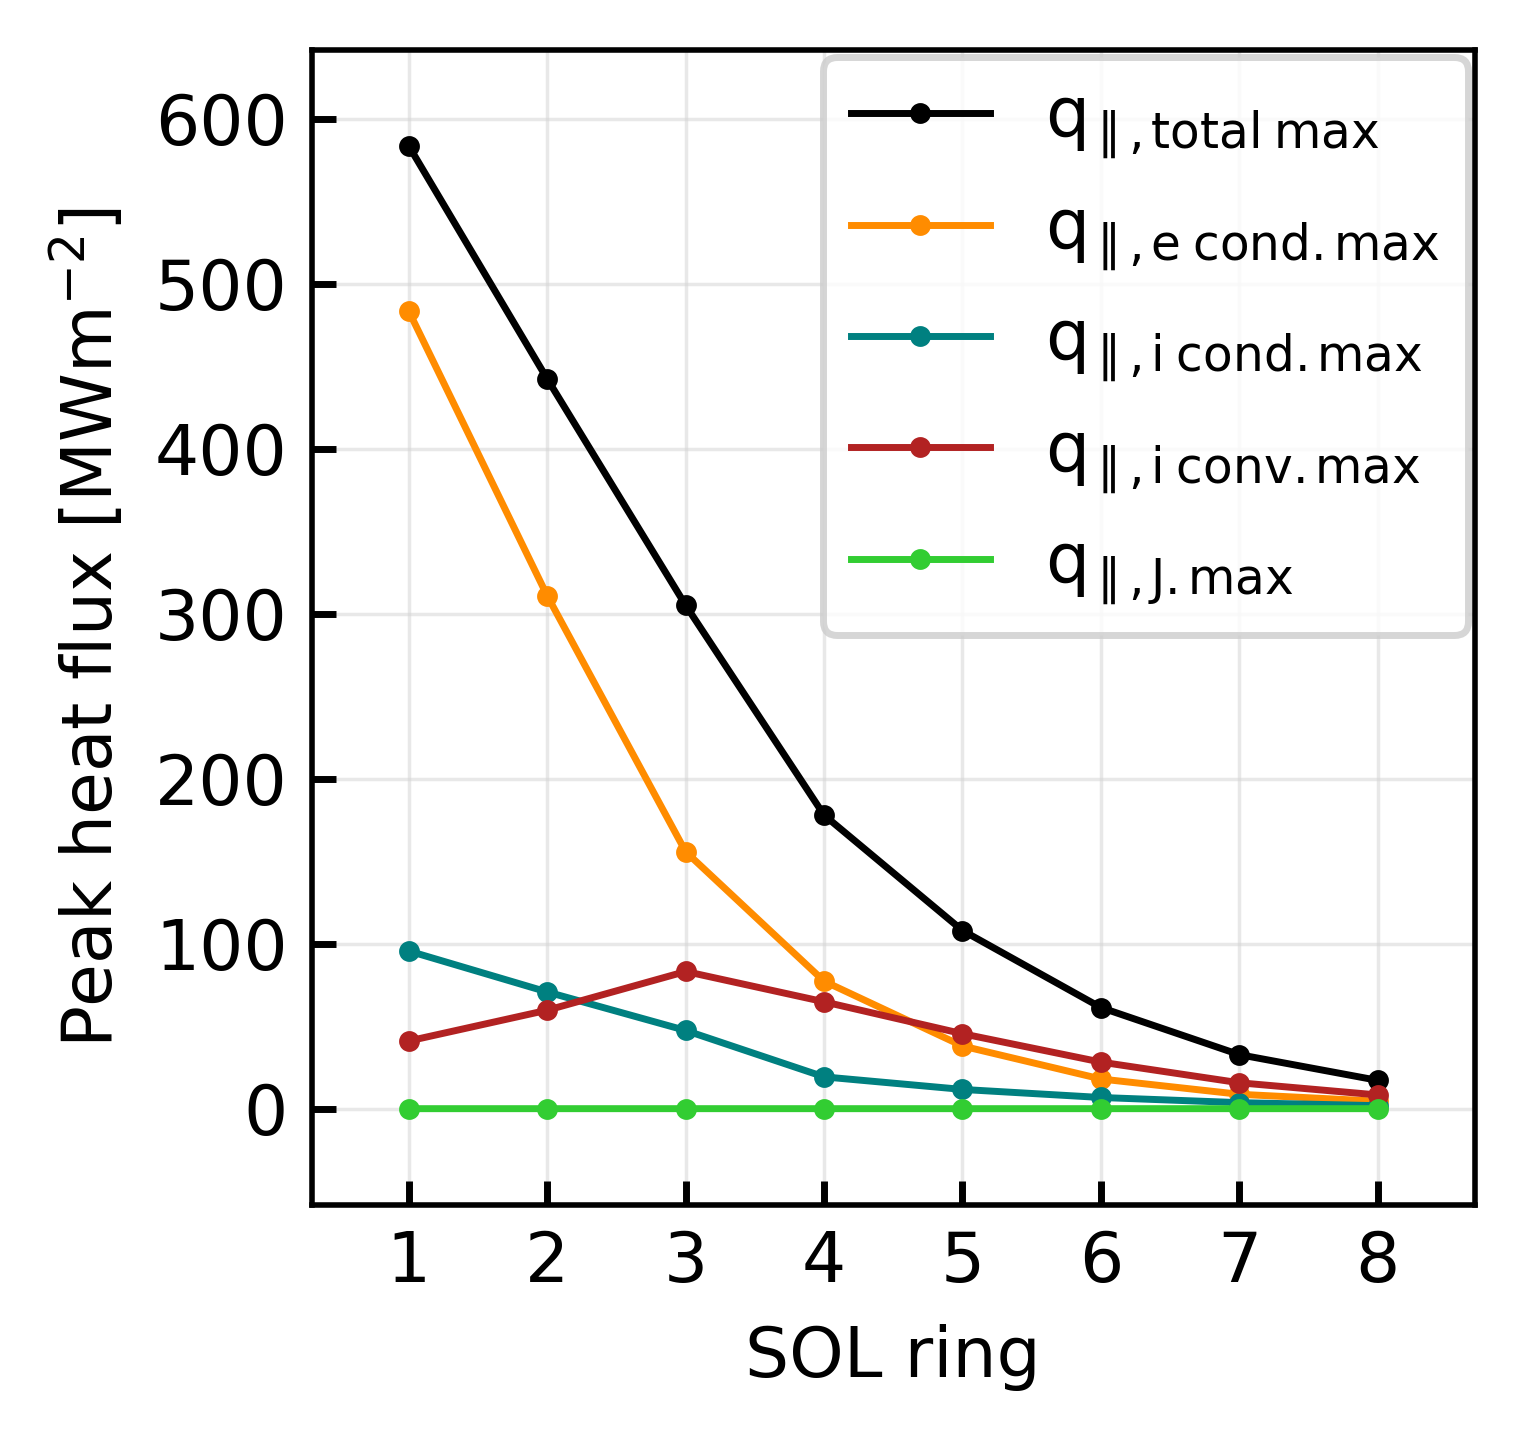

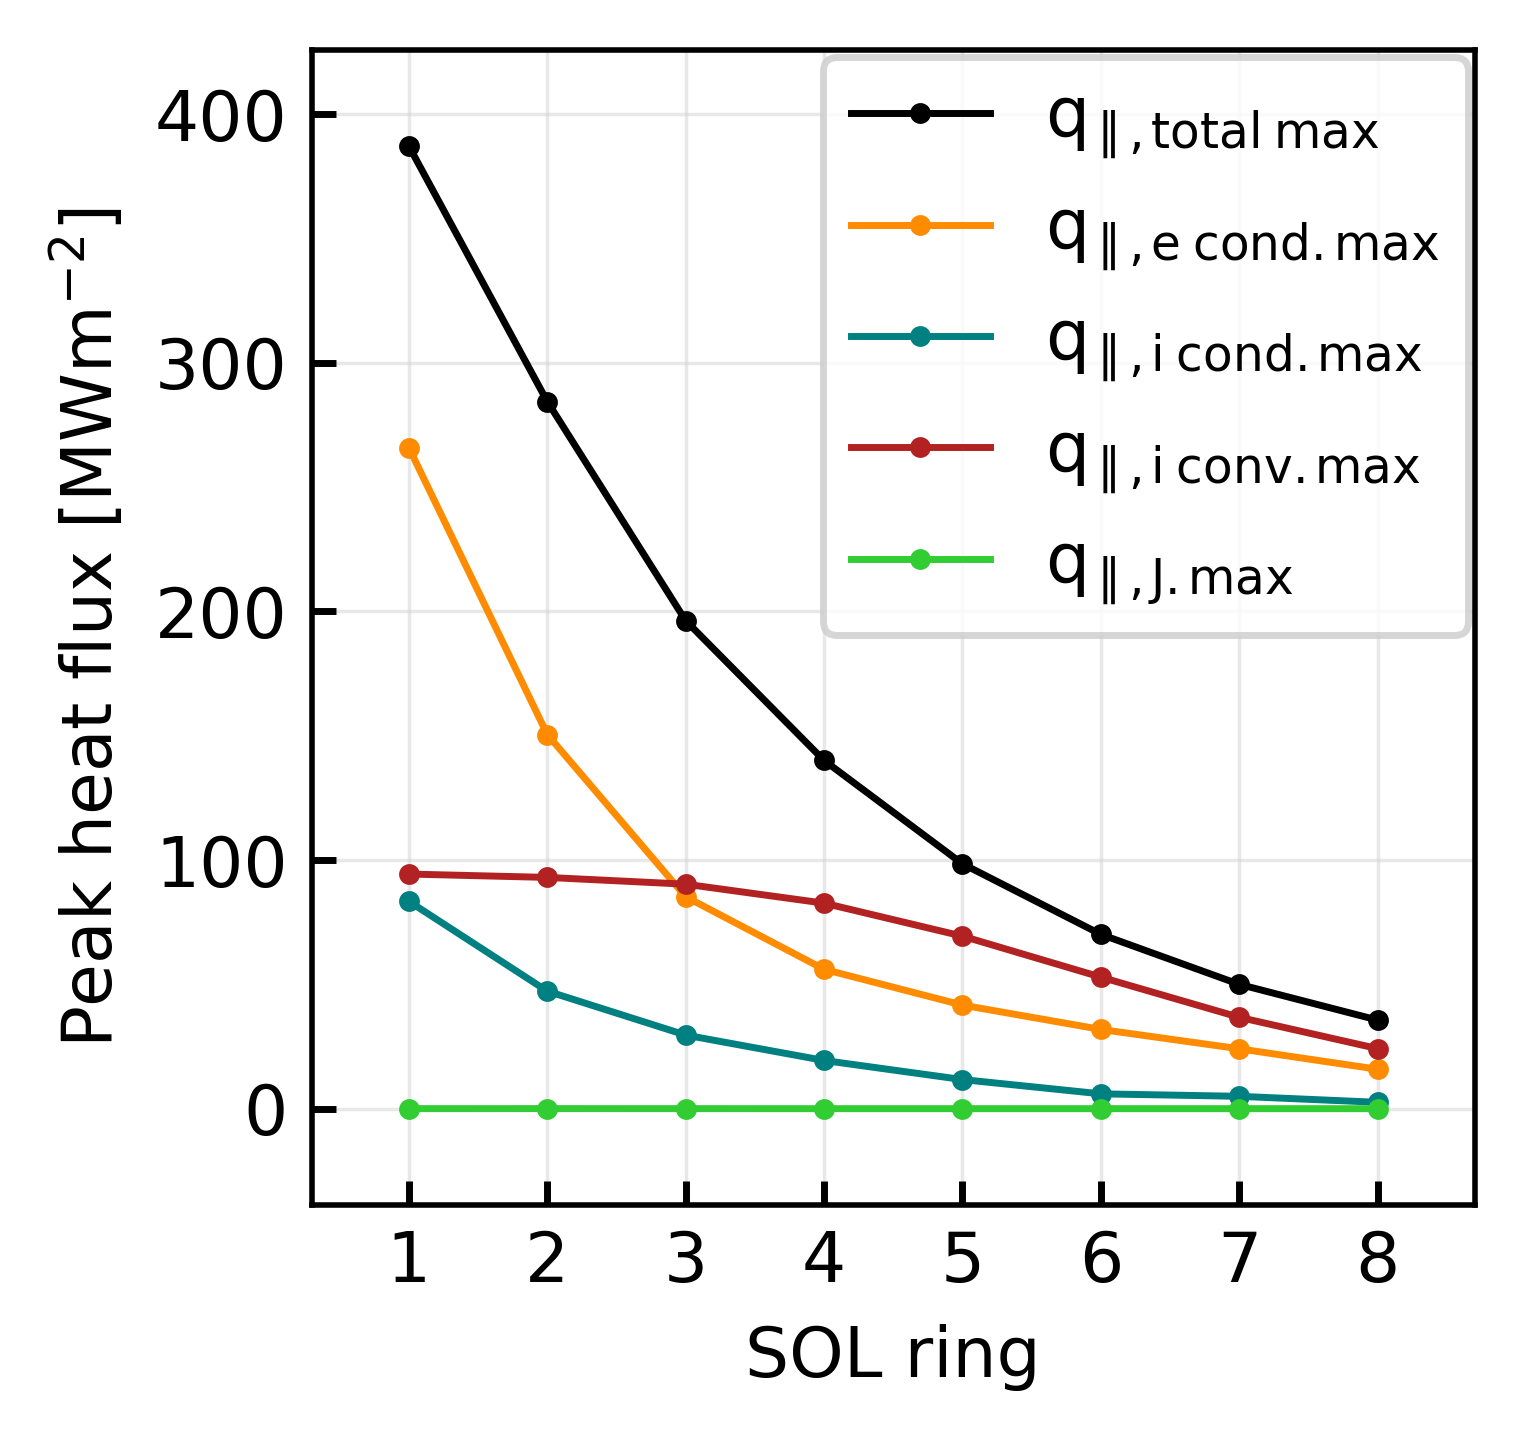

In [270]:
sepadd = 0
# region = "outer_lower"
# region = "inner_lower"
# case = '100MW_inner_arpuff'
case = '100MW_innerar_midplanepuff'

for region in ["outer_lower", "inner_lower"]:
    df = pd.DataFrame()
    slc = store_slc[case]
    for sepadd in range(8):
        fline = slc.get_1d_poloidal_data(["Te", "RAr", "ne", "fhex_cond", "fhex_32", "fhix_cond", "fhix_32", "fhex_thermj", "fhx_total"], sepadd = sepadd, region = region, target_first = True)
        
        for param in ["fhex_32", "fhix_32"]:
            fline[param] = fline[param] * 5/3

        mult = -1 if "inner_lower" in region else 1
        
        for param in fline.columns:
            if param.startswith("fh"):
                fline[param] = fline[param] / fline["apar"]
                fline[param] *= mult
        solring = sepadd + 1
        df.loc[solring, "e_cond"] = fline["fhex_cond"].max()
        df.loc[solring, "i_cond"] = fline["fhix_cond"].max()
        df.loc[solring, "i_conv"] = fline["fhix_32"].max()
        df.loc[solring, "e_curr"] = fline["fhex_thermj"].max()
        df.loc[solring, "total"] = fline["fhx_total"].max()
        
        if fline["fhx_total"].mean() < 0:
            raise Exception("Total heat flux negative, fix sign")



    df /= 1e6
    # display(df)
    fig, ax = plt.subplots(figsize = (3,3), dpi = 500)
    style = dict(marker = "o", ms = 2, lw = 1)
    ax.plot(df.index, df["total"], **style, c = "k",  label = r"$q_{\parallel,total\ max}$")
    ax.plot(df.index, df["e_cond"], **style, c = "darkorange",  label = r"$q_{\parallel,e\ cond. max}$")
    ax.plot(df.index, df["i_cond"], **style, c = "teal", label = r"$q_{\parallel,i\ cond. max}$")
    ax.plot(df.index, df["i_conv"], **style, c = "firebrick", label = r"$q_{\parallel,i\ conv. max}$")
    ax.plot(df.index, df["e_curr"], **style, c = "limegreen", label = r"$q_{\parallel,J. max}$")

    ax.legend(fontsize = "medium")
    ax.set_xlabel("SOL ring")
    ax.set_ylabel("Peak heat flux [$MWm^{-2}$]")
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
    plt.savefig(rf"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_SOLring_heatfluxes_{region}.pdf", format = "pdf", bbox_inches = "tight")

In [ ]:
## Heat flux distributions for each SOL ring

In [46]:
store_slc.keys()

dict_keys(['100MW_inner_arpuff', '100MW_innerar_midplanepuff'])

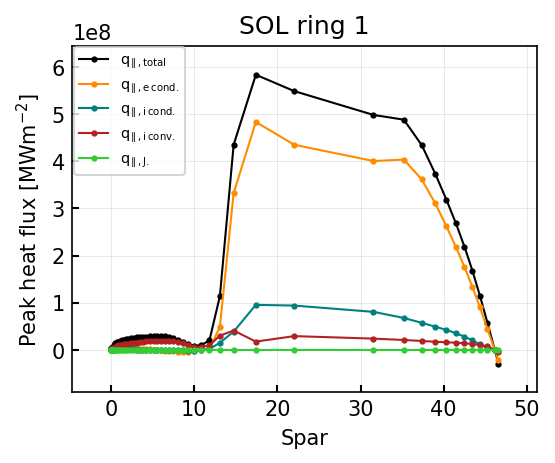

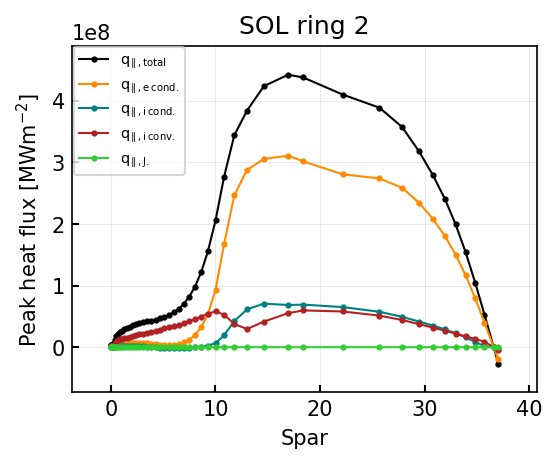

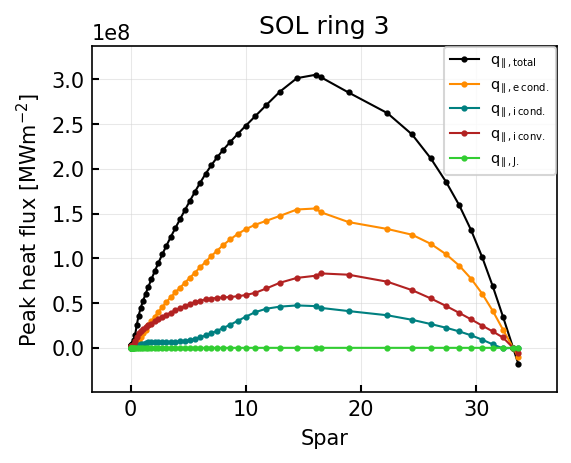

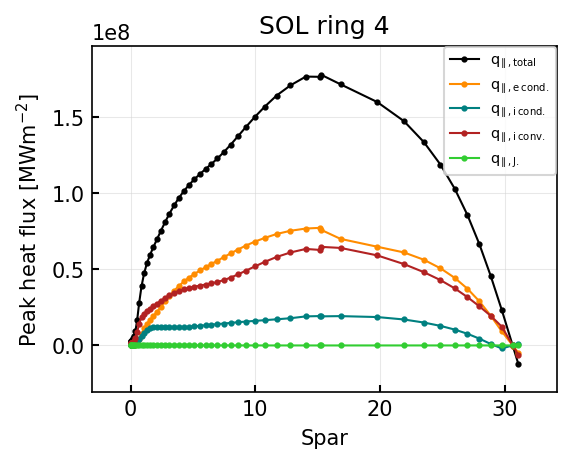

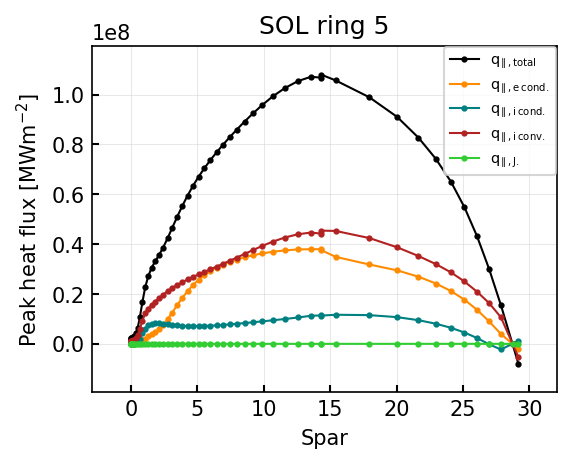

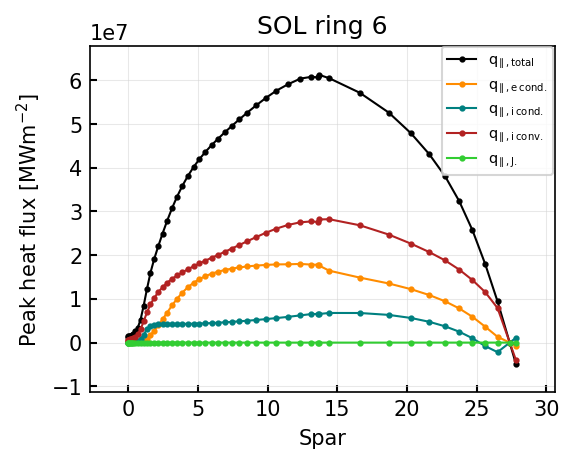

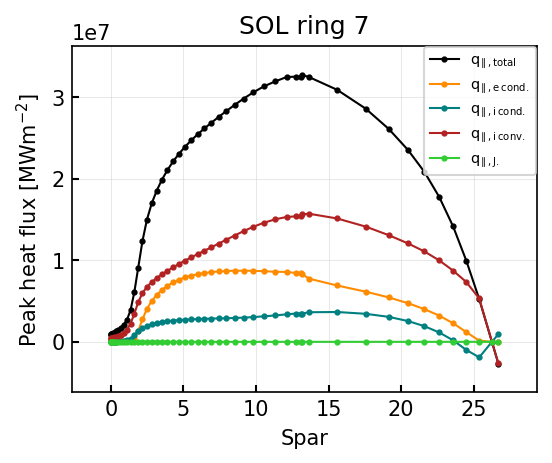

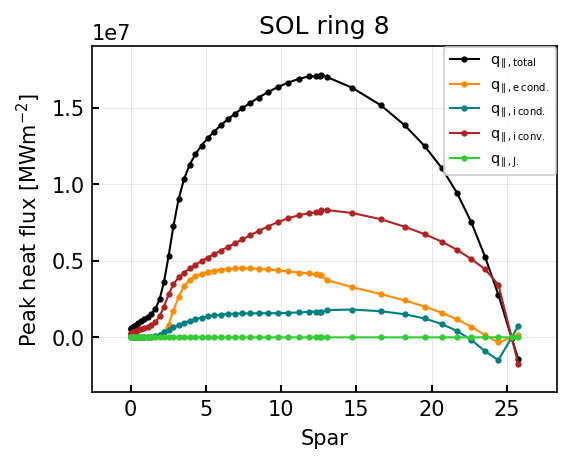

In [271]:
sepadd = 0
region = "outer_lower"
case = "100MW_innerar_midplanepuff"

df = pd.DataFrame()
slc = store_slc[case]
for sepadd in range(8):
    fline = slc.get_1d_poloidal_data(["Te", "RAr", "ne", "fhex_cond", "fhex_32", "fhix_cond", "fhix_32", "fhex_thermj", "fhx_total"], sepadd = sepadd, region = region, target_first = True)
    
    for param in ["fhex_32", "fhix_32"]:
        fline[param] = fline[param] * 5/3

    for param in fline.columns:
        if param.startswith("fh"):
            fline[param] = fline[param] / fline["apar"]

    solring = sepadd + 1

    df /= 1e6
    # display(df)
    fig, ax = plt.subplots(figsize = (4,3), dpi = 150)
    style = dict(marker = "o", ms = 2, lw = 1)
    ax.plot(fline["Spar"], fline["fhx_total"], **style, c = "k",  label = r"$q_{\parallel,total}$")
    ax.plot(fline["Spar"], fline["fhex_cond"], **style, c = "darkorange",  label = r"$q_{\parallel,e\ cond.}$")
    ax.plot(fline["Spar"], fline["fhix_cond"], **style, c = "teal", label = r"$q_{\parallel,i\ cond.}$")
    ax.plot(fline["Spar"], fline["fhix_32"], **style, c = "firebrick", label = r"$q_{\parallel,i\ conv.}$")
    ax.plot(fline["Spar"], fline["fhex_thermj"], **style, c = "limegreen", label = r"$q_{\parallel,J.}$")
    ax.set_title(f"SOL ring {solring}")
    ax.legend(fontsize = "x-small")
    ax.set_xlabel("Spar")
    ax.set_ylabel("Peak heat flux [$MWm^{-2}$]")
    # ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))


### Distribution of total heat flux

In [60]:
store_slc.keys()

dict_keys(['100MW_inner_arpuff', '100MW_innerar_midplanepuff'])

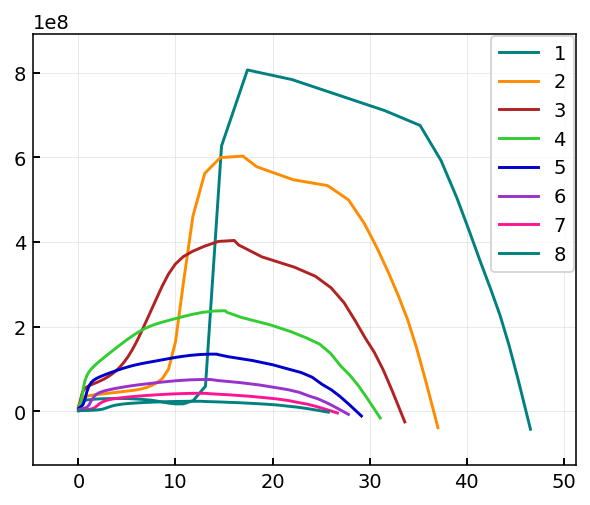

In [61]:
sepadd = 0
df = pd.DataFrame()
region = "outer_lower"
# case = "100MW_innerar_midplanepuff"
case = "100MW_inner_arpuff"

df = pd.DataFrame()
slc = store_slc[case]
fig, ax = plt.subplots()
for sepadd in range(8):
    fline = slc.get_1d_poloidal_data(["Te", "RAr", "ne", "fhex_cond", "fhex_32", "fhix_cond", "fhix_32", "fhex_thermj", "fhx_total"], sepadd = sepadd, region = region, target_first = True)
    
    for param in ["fhex_32", "fhix_32"]:
        fline[param] = fline[param] * 5/3

    for param in fline.columns:
        if param.startswith("fh"):
            fline[param] = fline[param] / fline["apar"]
            # fline[param] *= -1

    ax.plot(fline["Spar"], fline["fhx_total"], label = sepadd+1)
    ax.legend()



# plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_SOLring_particlebalance.pdf", format = "pdf", bbox_inches = "tight")

### Case comparison

In [13]:
store_slc.keys()

dict_keys(['100MW_inner_arpuff', '100MW_innerar_midplanepuff'])

In [ ]:
flines = {}
params = ["RAr","M", "Pe", "Te", "Ne", "fAr", "Btot", "R", "fhx_total", "fhex_cond", "Sd+_iz", "vol"]

flines["pfr"] = store_slc["100MW_inner_arpuff"].get_1d_poloidal_data(params, sepadd = i, region = region, target_first = True)  
flines["mp"] = store_slc["100MW_innerar_midplanepuff"].get_1d_poloidal_data(params, sepadd = i, region = region, target_first = True)  

fig, ax = plt.subplots()

for case in flines:

# Run outer target


## Setup


In [8]:
comps_outer = {}
num_sepadds = 5

In [9]:
def run_DLS(constants_input, slc, cvar, region, sepadd, hflux_corr = 1):

    # set switches
    radios_default = {
        "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
    }
    
    df = slc.get_1d_poloidal_data(params = ["fhx_total", "Ne"], sepadd = sepadd, region = region, target_first = True)
    qpar_max = (df["fhx_total"]/df["apar"]).abs().max()
    # print(f"qpar_max = {qpar_max:.1e}")
    nu = df["Ne"].iloc[-1]

    # set general run parameters
    constants_default = {
        "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
        "Tt": 0.5,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
        "qpllu0": qpar_max*hflux_corr,
        "nu": nu,  # Upstream density (if constant)
        "nu0": nu,  # Upstream density (if constant)
        "cz0": 0.05,  # Impurity fraction (if constant)
        # "Lfunc": LfuncKallenbach("N"),  # impurity cooling function. More are available in AnalyticCoolingCurves.py
        "Lfunc" : slc.extract_cooling_curve("Ar", region, sepadd = i, plot = False),
        "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region)
    }

    constants = {**constants_default, **constants_input}
    d = eqb_alt[case][region][sepadd]

    try: 
            out = run_dls(
                constants = constants, 
                radios = radios_default, 
                d = d,
                SparRange = [slc.extract_front_pos(sepadd = sepadd, region = region, impurity = "Ar", method = "qpar_tot", threshold = 0.05)],
                control_variable = cvar,
                verbosity = 0,
                Ctol = 1e-3,
                Ttol = 1e-3,
                dynamicGrid = True,
                dynamicGridRefinementRatio = 10,
                dynamicGridRefinementWidth = 2,
                dynamicGridDiagnosticPlot = False)
        
    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return compare_SOLPS_DLS(slc, out, cvar, impurity = "Ar", region = region, sepadd = sepadd)

def get_correction_factors(comp):

    fhx_solps = comp.solps[comp.solps["Xpoint"] == 1]["fhx_total"].abs().values[0]
    fhx_dls = comp.dls[comp.dls["Xpoint"] == 1]["qpar"].values[0]
    hflux_factor = fhx_solps / fhx_dls

    kappa_factor = (comp.dls["Te"].max() / comp.solps["Te"].max())**2

    return hflux_factor, kappa_factor


In [15]:
store_slc.keys()

dict_keys(['100MW_inner_arpuff', '100MW_innerar_midplanepuff'])

In [16]:
comps_outer = {}

## SOL ring 3 with different changes

qpar_max = 1.8e+08
Solving...0.52...Complete in 1.3 seconds
Hflux factor: 1.02


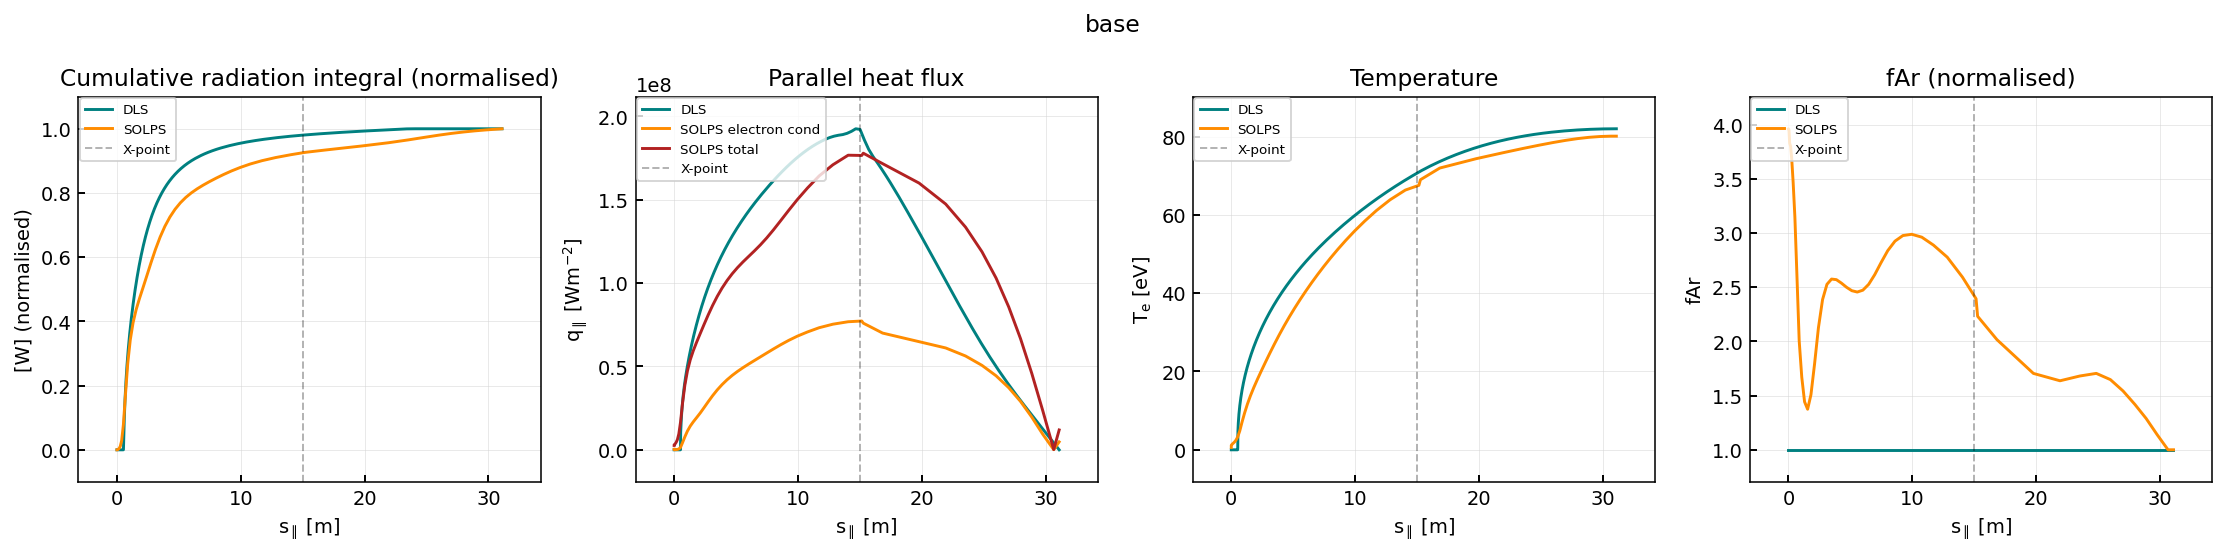

In [20]:
study = "ring3"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = [1.10, 1.11, 1.12, 1.26, 0.98]
i = 3  # Sepadd

comps_outer[study]["base"] = run_DLS(
    {"Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
    "kappa0" : 2500
    }, 
    store_slc[case],  
    cvar, region, i, hflux_corr = hflux_corrections[0])  

# comps_outer[study]["tune_kappa"] = run_DLS(
#     {"Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
#     "kappa0" : 2600
#     }, 
#     store_slc[case],  
#     cvar, region, i, hflux_corr = hflux_corrections[1])  

# comps_outer[study]["cz_effect"] = run_DLS(
#     {"Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = True),
#     "kappa0" : 2600
#     }, 
#     store_slc[case],  
#     cvar, region, i, hflux_corr = hflux_corrections[1])  

# comps_outer[study]["cz_ne_effect"] = run_DLS(
#     {"Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = True, cz_effect = True),
#     "kappa0" : 2600
#     }, 
#     store_slc[case],  
#     cvar, region, i, hflux_corr = hflux_corrections[1])  



for i, name in enumerate(comps_outer[study].keys()):
    comp = comps_outer[study][name]
    comp.plot(["Cumrad", "qpar", "Te", "cz"], normalise_radiation = True, radiation_per_area = False, title = name)

    hflux_factor = comp.solps["fhx_total"].max() / comp.dls["qpar"].max() * hflux_corrections[i]
    print(f"Hflux factor: {hflux_factor:.2f}")


## Run selected SOL rings
- With and without fitted curve

In [10]:
comps_outer = {}

### Without fitted curve

Solving...0.68...Complete in 1.0 seconds
    Hflux factor for sepadd 1: 1.09
Solving...0.38...Complete in 1.3 seconds
    Hflux factor for sepadd 2: 1.09
Solving...0.37...Complete in 0.8 seconds
    Hflux factor for sepadd 4: 1.12


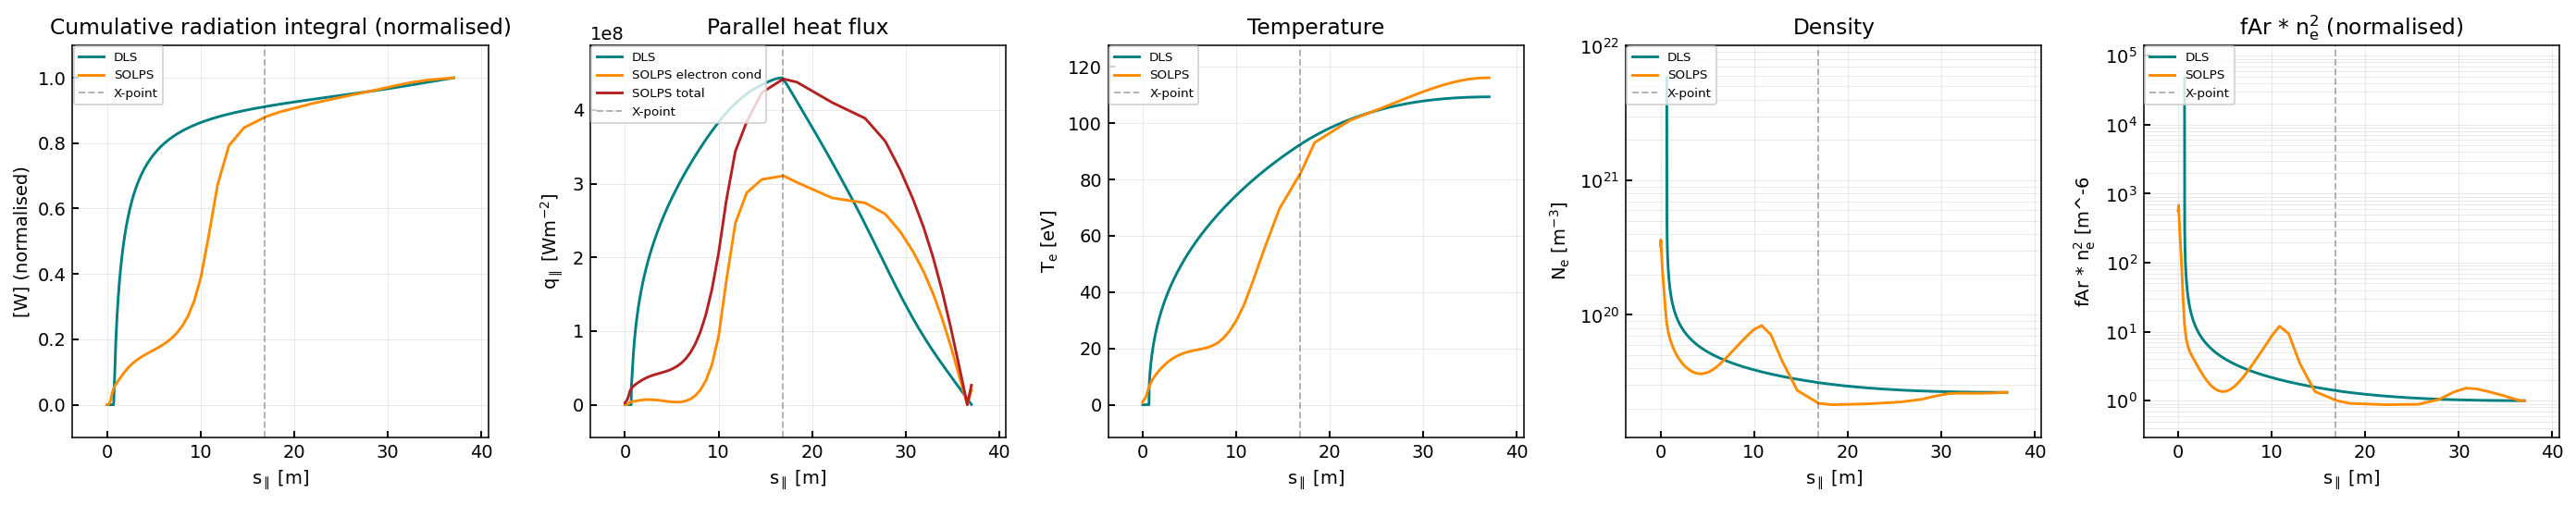

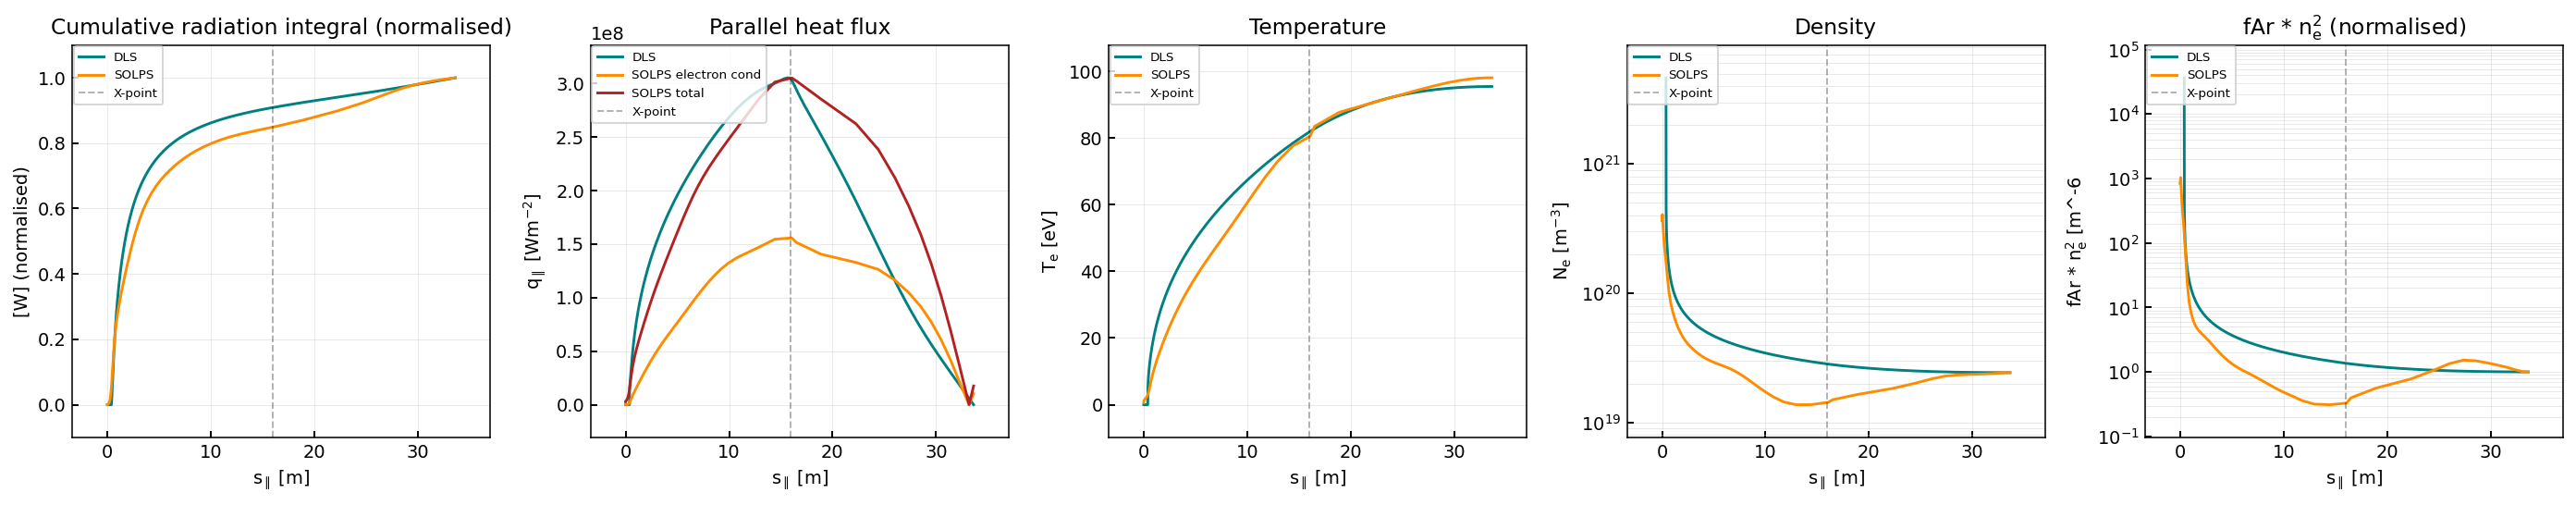

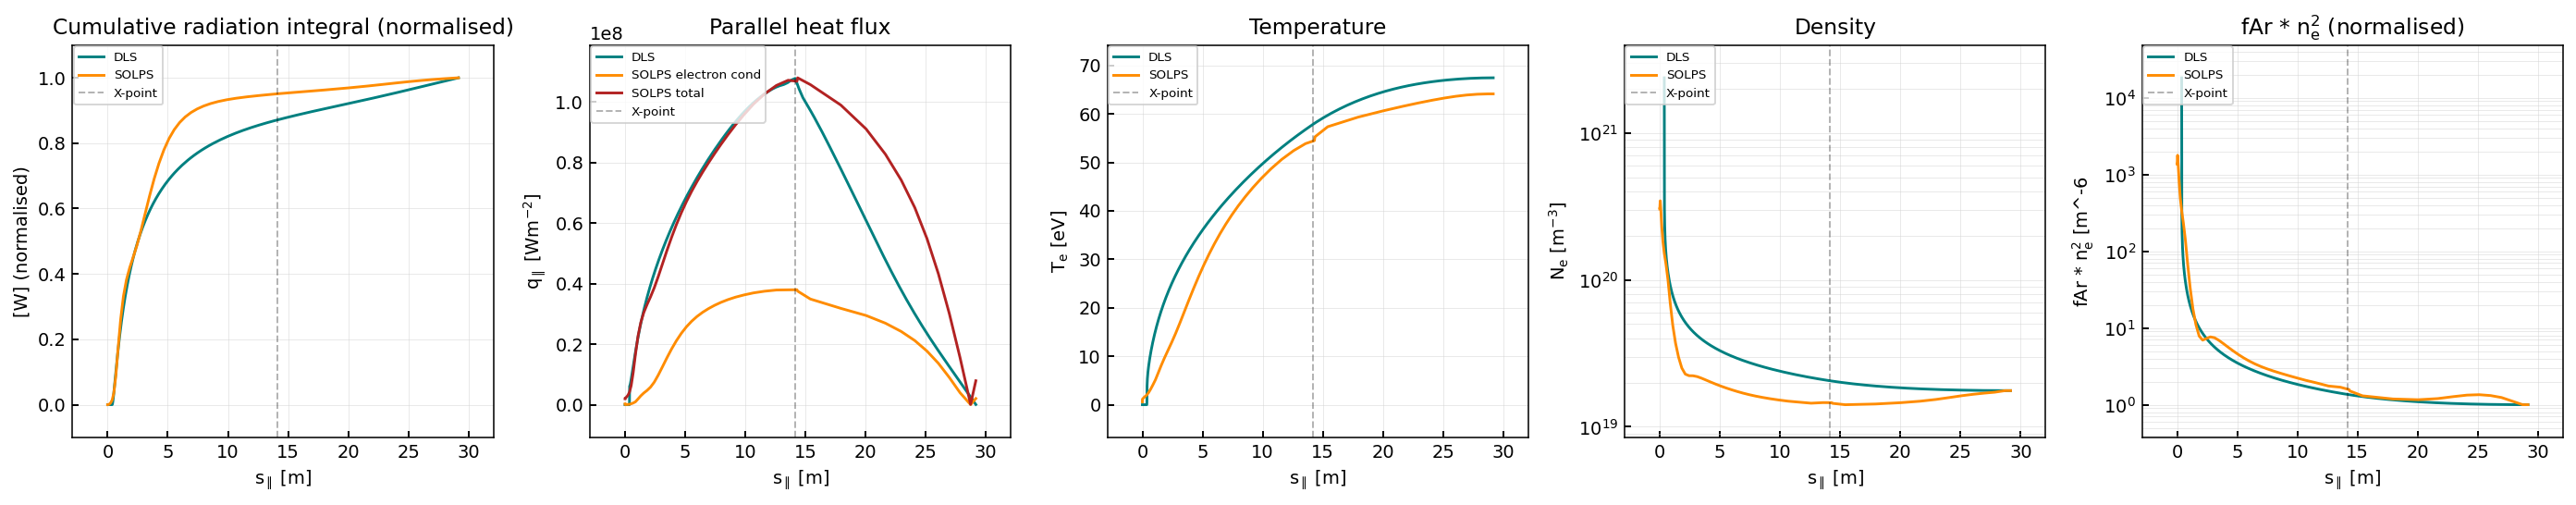

In [15]:
study = "adas_curve"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = {0: 1.40, 1: 1.09, 2: 1.09, 3: 1.03, 4: 1.13}

for i in [1,2,4]:
    input = {
        "Lfunc" : curves["Ar"][1e16],
        "kappa0" : 2500
    }

    comps_outer[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_outer[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)
    
    hflux_factor, kappa_factor = get_correction_factors(comps_outer[study][i])
    print(f"    Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### With fitted curve

Solving...0.68...Complete in 1.1 seconds
    Hflux factor for sepadd 1: 1.11
Solving...0.38...Complete in 1.2 seconds
    Hflux factor for sepadd 2: 1.08
Solving...0.37...Complete in 1.3 seconds
    Hflux factor for sepadd 4: 1.00


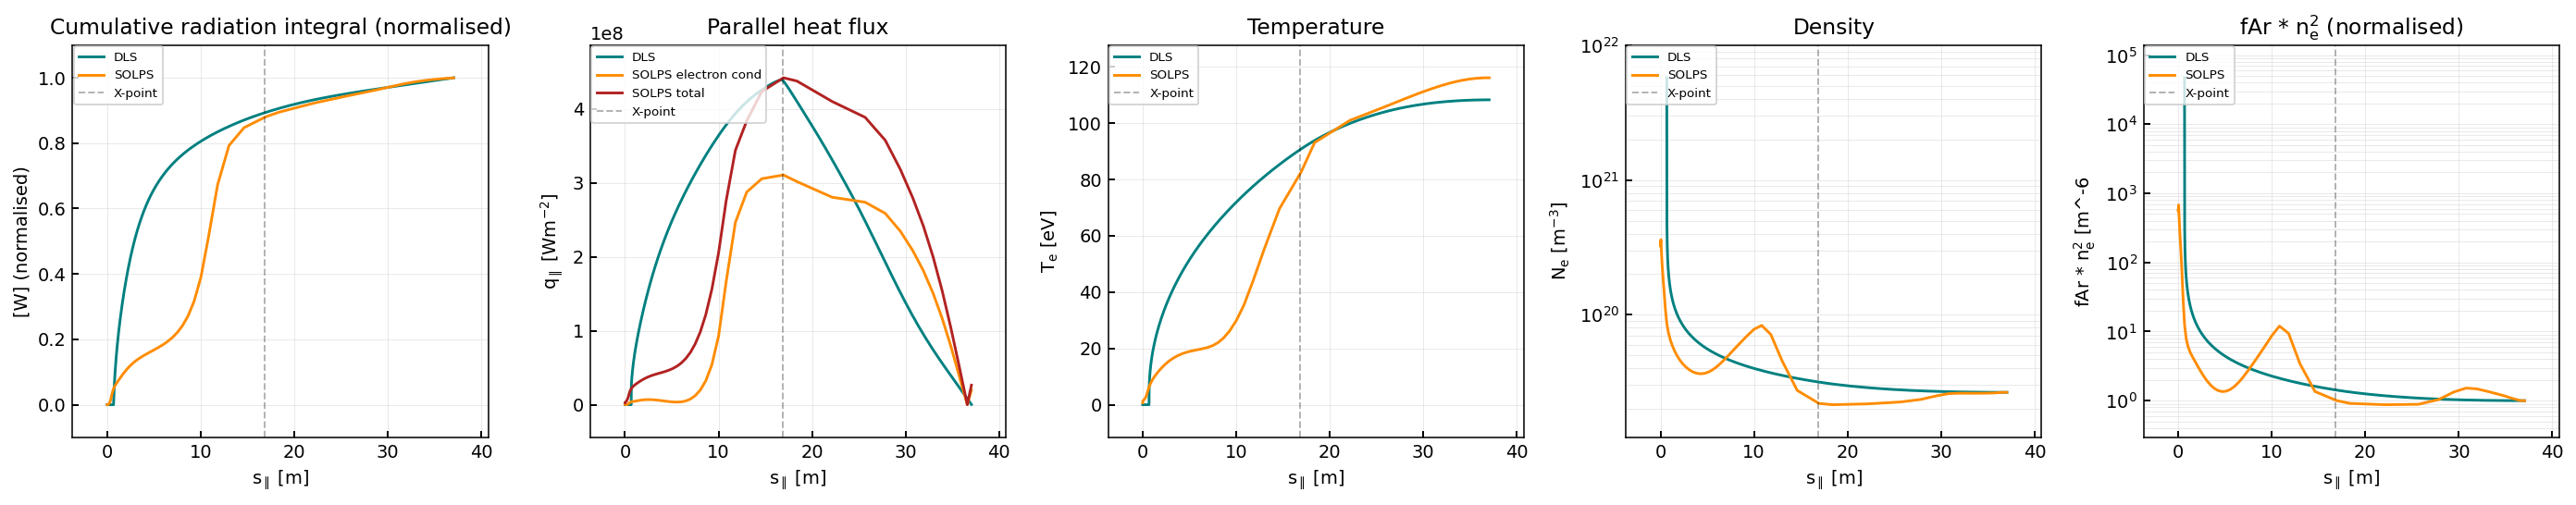

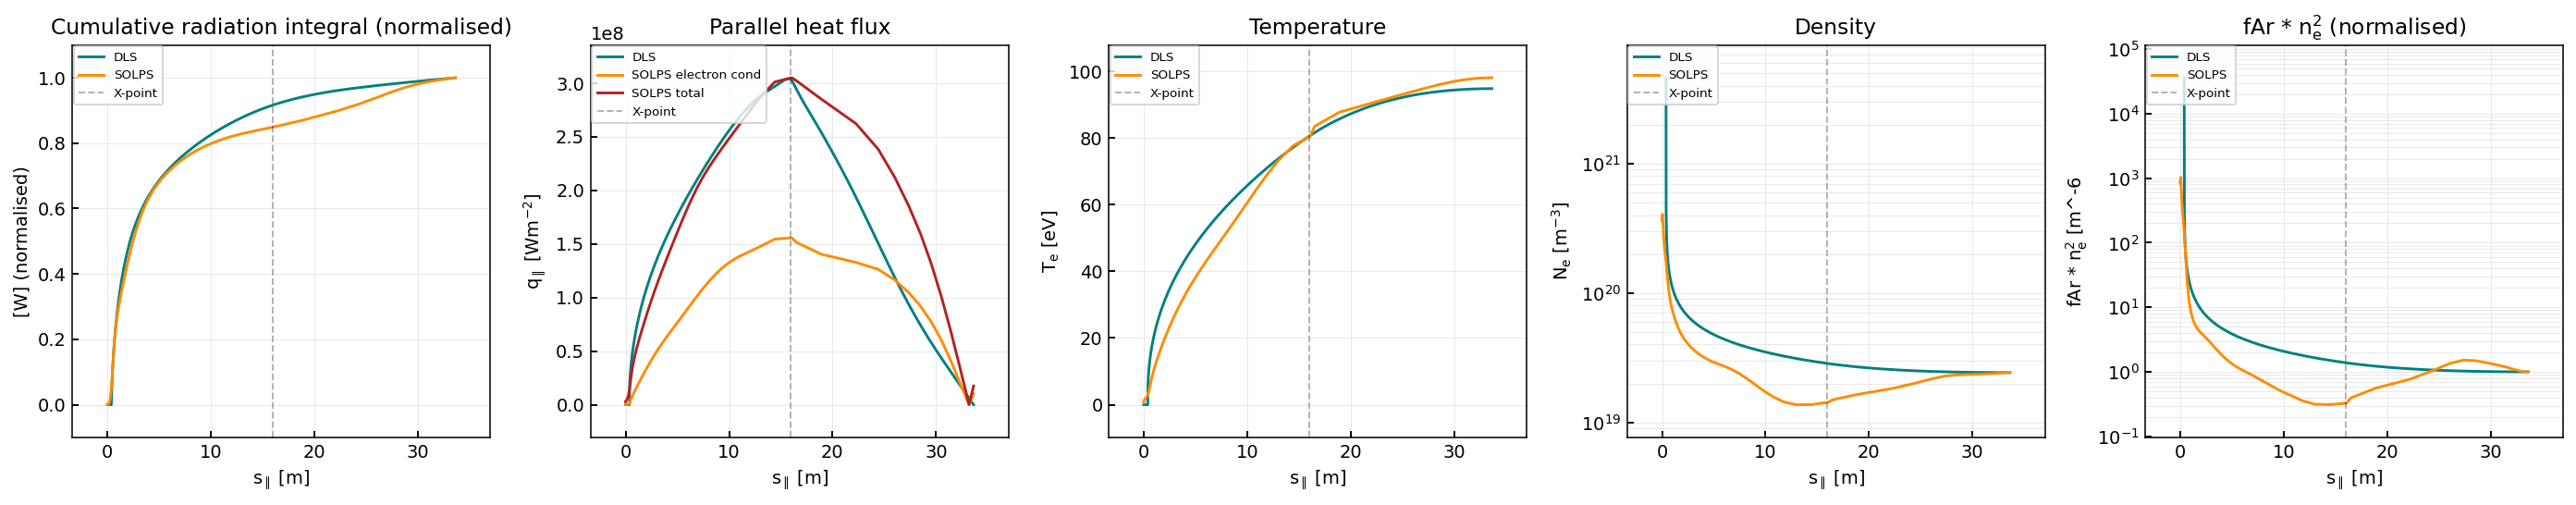

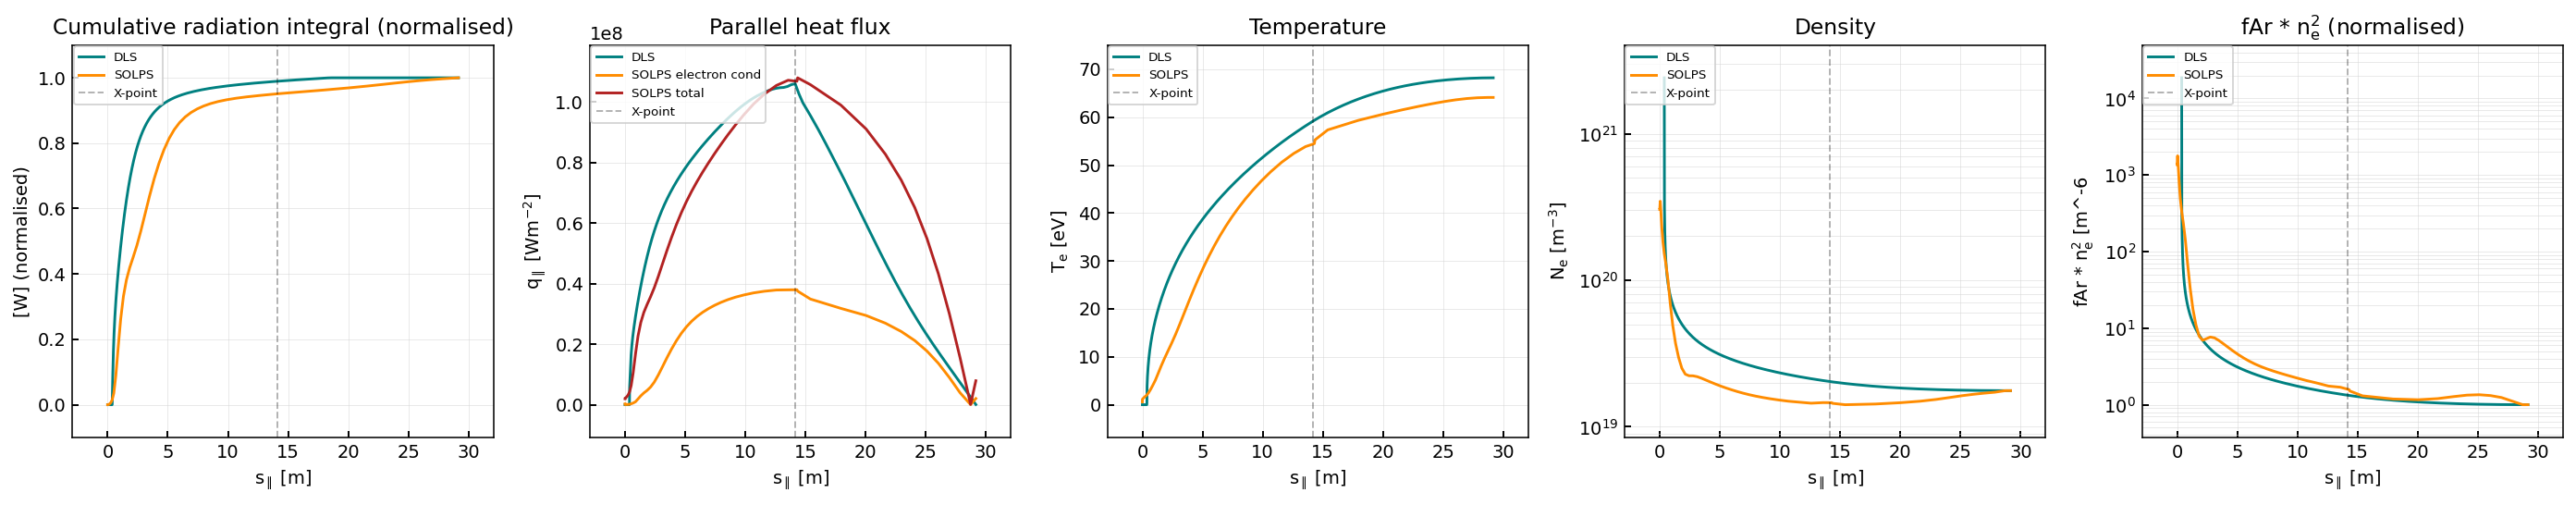

In [16]:
study = "fit_curve"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = {0: 1.40, 1: 1.10, 2: 1.08, 3: 1.00, 4: 0.99}

for i in [1,2,4]:
    input = {
        "Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "kappa0" : 2500
    }

    comps_outer[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_outer[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)
    
    hflux_factor, kappa_factor = get_correction_factors(comps_outer[study][i])
    print(f"    Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### Fit curve, fit kappa

Solving...0.68...Complete in 1.4 seconds
  Hflux factor for sepadd 1: 1.03
  Kappa factor for sepadd 1: 0.75
Solving...0.38...Complete in 1.1 seconds
  Hflux factor for sepadd 2: 1.06
  Kappa factor for sepadd 2: 0.90
Solving...0.37...Complete in 0.5 seconds
  Hflux factor for sepadd 4: 1.01
  Kappa factor for sepadd 4: 1.26


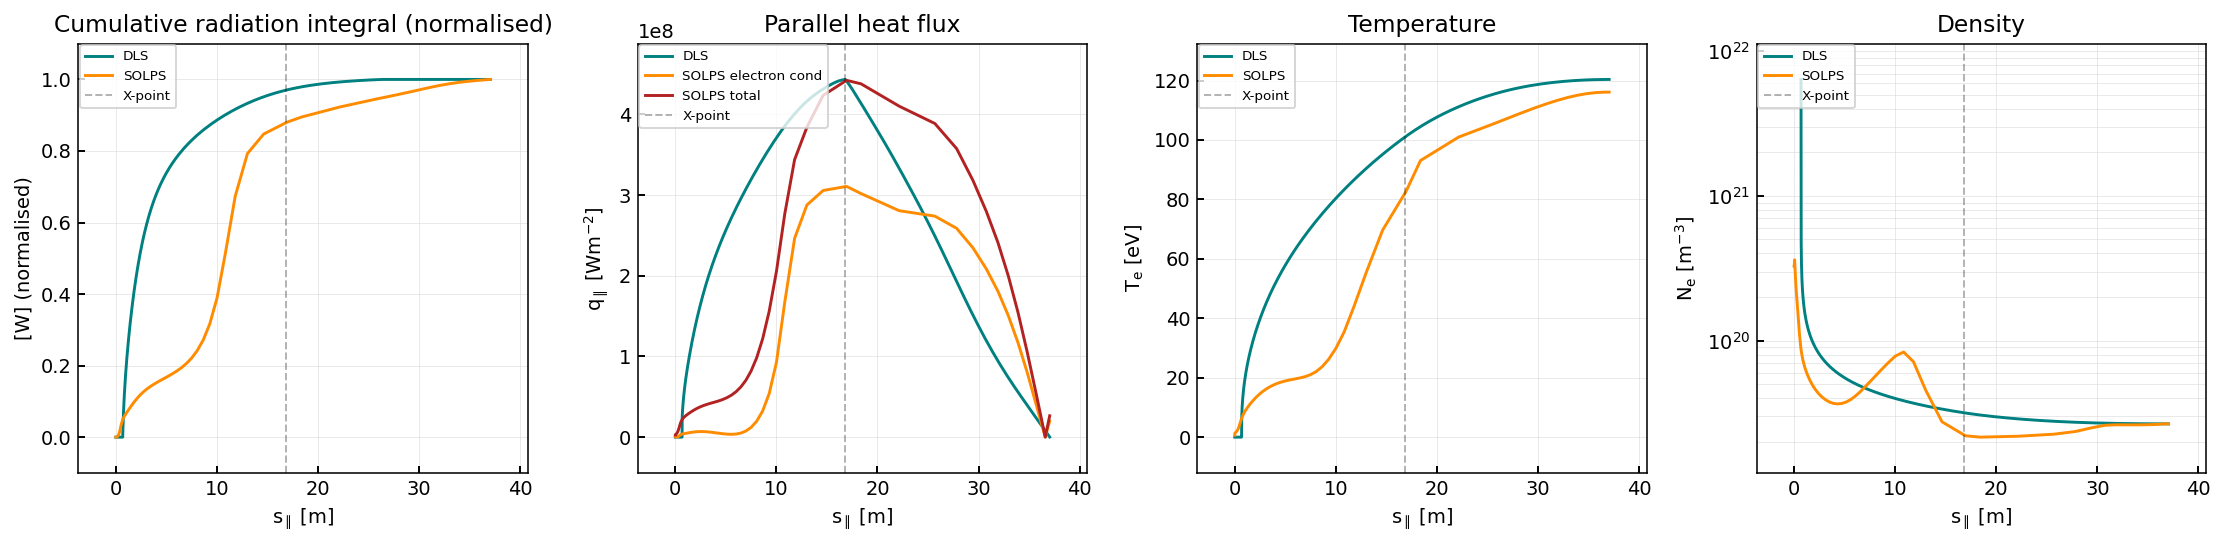

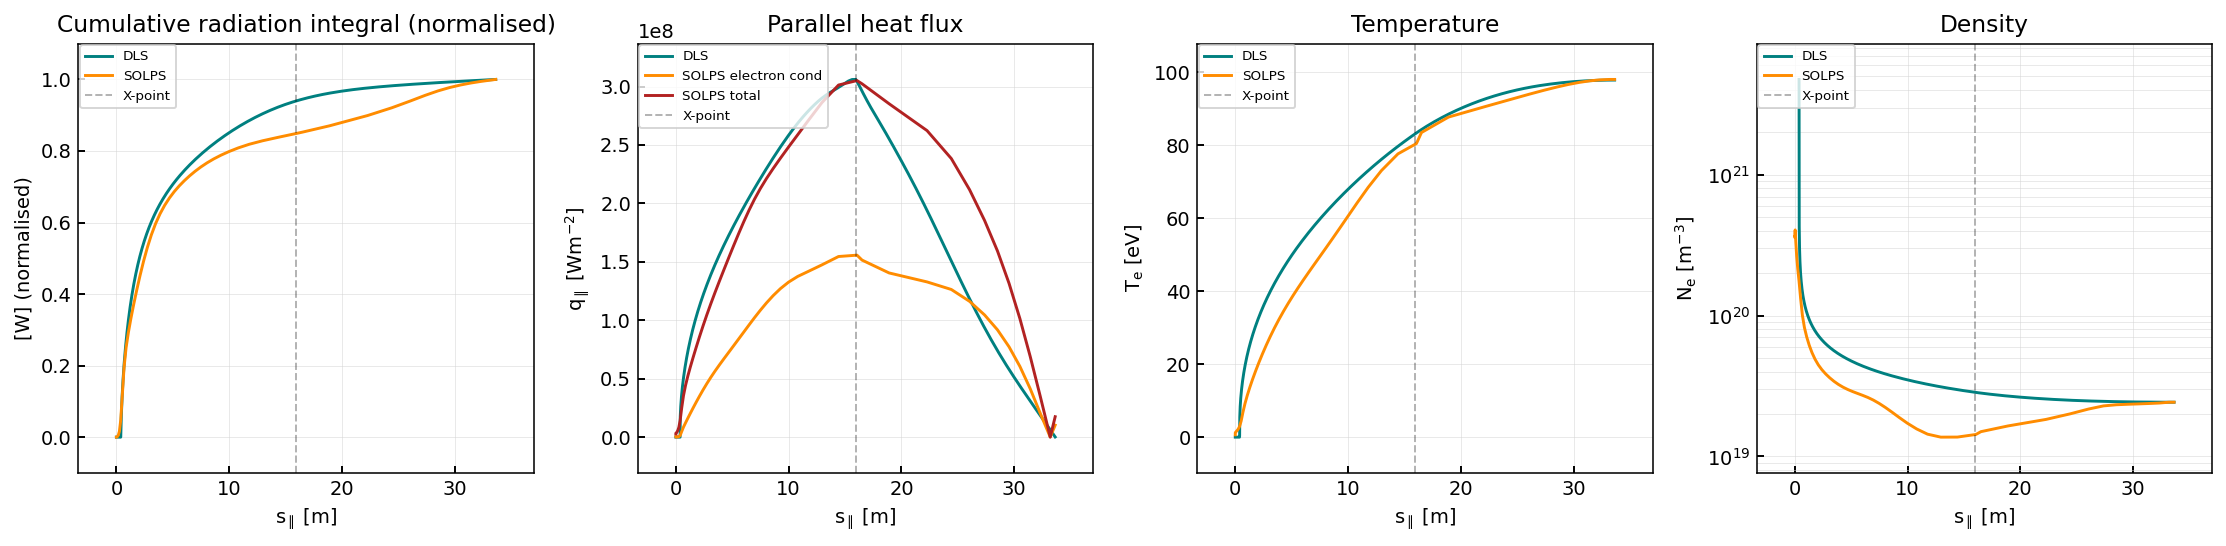

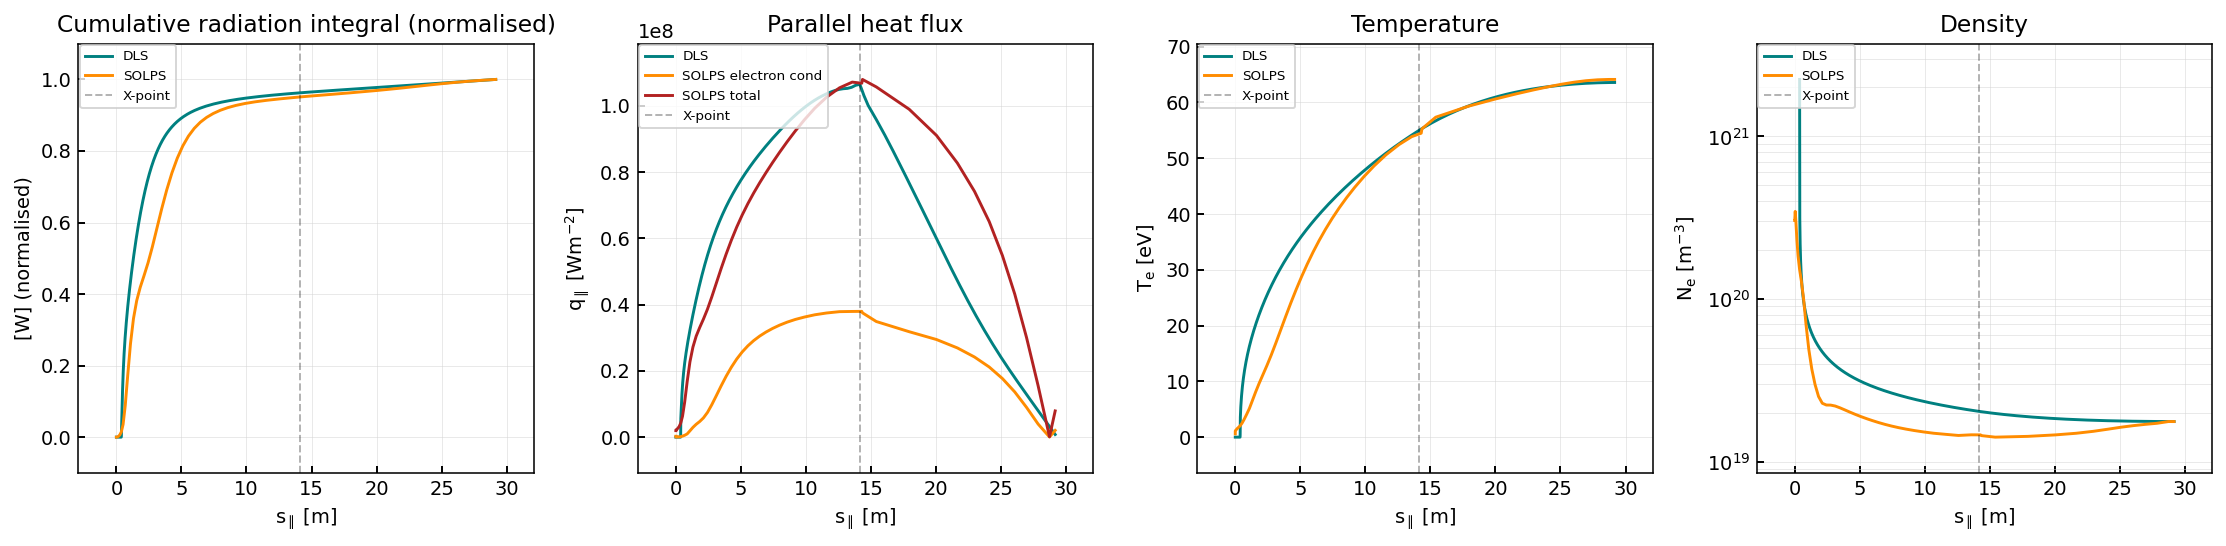

In [17]:
study = "fit_curve_kappa"
cvar = "impurity_frac"
region = "outer_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_outer[study] = {}

hflux_corrections = [1.03, 1.06, 1.01]
kappa_corrections = [0.70, 0.90, 1.28]

for idx, i in enumerate([1,2,4]):
    input = {
        "Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        # "kappa0" : slc.extract_kappa0(sepadd = sepadd, region = region, total_hflux = True, skip_xpoint = False, print_kappa = True),
        "kappa0" : 2500 * kappa_corrections[idx]
    }

    comps_outer[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[idx])  
    comps_outer[study][i].plot(["Cumrad", "qpar", "Te", "Ne"], normalise_radiation = True, radiation_per_area = False)
    
    hflux_factor, kappa_factor = get_correction_factors(comps_outer[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[idx]:.2f}")
    print(f"  Kappa factor for sepadd {i}: {kappa_factor * kappa_corrections[idx]:.2f}")


In [104]:
comps_outer.keys()

dict_keys(['fit_curve_kappa'])

Text(0.5, 1.0, 'Static pressure')

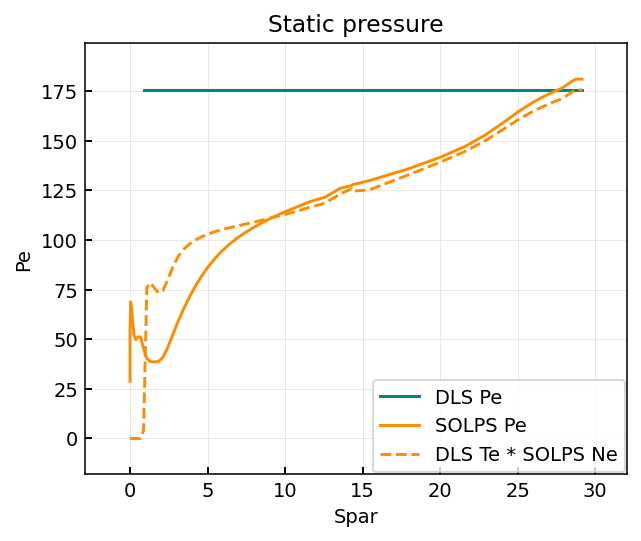

In [115]:
comp = comps_outer["fit_curve_kappa"][4]

fig, ax = plt.subplots()


Te_dls = comp.dls["Te"]
Ne_solps = comp.solps["Ne"]
Spar_dls = comp.dls["Spar"]
Spar_solps = comp.solps["Spar"]

Te_dls_interp = [sp.interpolate.interp1d(Spar_dls, Te_dls, kind = "linear", fill_value = "extrapolate")(pos) for pos in Spar_solps]

ax.plot(comp.dls["Spar"], comp.dls["Pe"], label = "DLS Pe", c = "teal")
ax.plot(comp.solps["Spar"], comp.solps["Pe"], label = "SOLPS Pe", c = "darkorange")
ax.plot(comp.solps["Spar"], Te_dls_interp * comp.solps["Ne"] * constants("q_e"), label = "DLS Te * SOLPS Ne", c = "darkorange", ls = "--")
ax.legend()
ax.set_ylabel("Pe")
ax.set_xlabel("Spar")
ax.set_title("Static pressure")

## Plot outer

In [128]:
comps_outer.keys()

dict_keys(['adas_curve', 'fit_curve', 'fit_curve_kappa'])

In [131]:
comps_outer["adas_curve"][2].dls.keys()

Index(['Qrad', 'Spar', 'Spol', 'Te', 'qpar', 'Btot', 'cz', 'Ne', 'Xpoint',
       'qradial', 'Prad_per_area', 'Prad_per_area_cum',
       'Prad_per_area_cum_norm', 'Prad_cum', 'Prad_cum_norm', 'Pe', 'Ne_sq_cz',
       'qpar_cond_frac'],
      dtype='object')

In [39]:
handles_xpoint

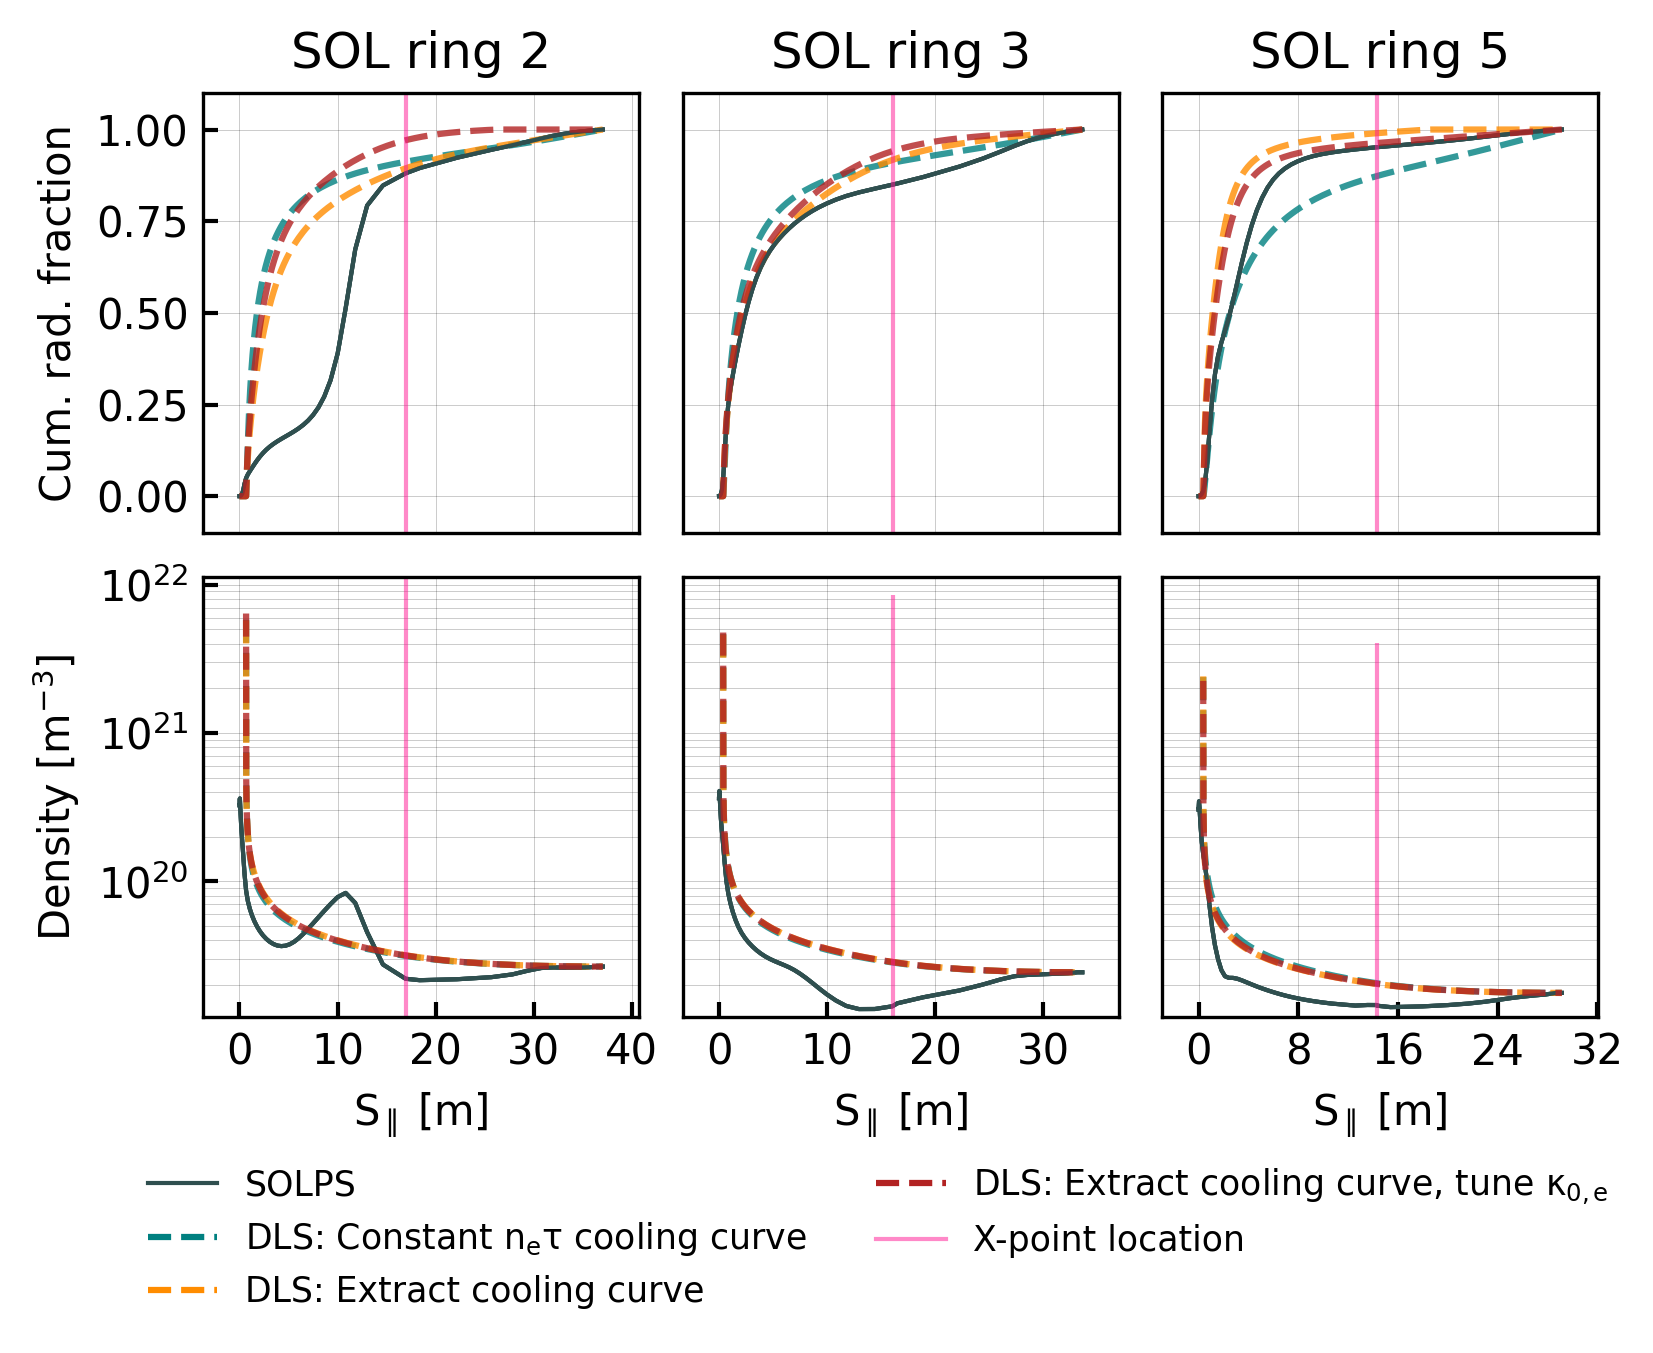

In [86]:
fig, axes = plt.subplots(2, 3, figsize = (6,4), dpi = 300, sharey = False)

study_choice = ['adas_curve', 'fit_curve', 'fit_curve_kappa']
pc = plot_comparison(comps_outer, studies = study_choice)
pc.plot("Prad_cum_norm", axes[0,:])
pc.plot("Ne", axes[1,:])

axes[0,0].set_title("SOL ring 2")
axes[0,1].set_title("SOL ring 3")
axes[0,2].set_title("SOL ring 5")

handles = pc.make_legend_elements()
handles_xpoint = [pc.make_legend_elements()[-1]]

for i in [1,2,3]:
    handles[i].set_label("DLS: " + handles[i].get_label())
handles[-1].set_label("X-point location")

axes[0,0].set_ylabel("Cum. rad. fraction")
axes[1,0].set_ylabel("Density [$m^{-3}$]")

for row in range(2):
    for col in [1,2]:
        axes[row, col].sharey(axes[row,0])
        axes[row, col].tick_params(axis="y", left = False, labelleft = False)
        axes[row, col].set_ylabel("")
        
for col in range(3):
    axes[0, col].set_xlabel("")
    axes[0, col].tick_params(axis = "x", bottom = False, labelbottom = False)
# axes[0,1].get_shared_y_axes().join(axes[0,0], axes[0,1])

voffset = 0.2
fig.legend(handles = handles, ncols = 2, bbox_to_anchor = (0.5, -0.2 + voffset), loc = "upper center", frameon = False, fontsize = "small")
# fig.legend(handles = handles_xpoint, ncols = 1, bbox_to_anchor = (0.073, -0.45 + voffset), loc = "upper left", frameon = False)
fig.subplots_adjust(wspace = 0.1)
fig.subplots_adjust(hspace = 0.1)

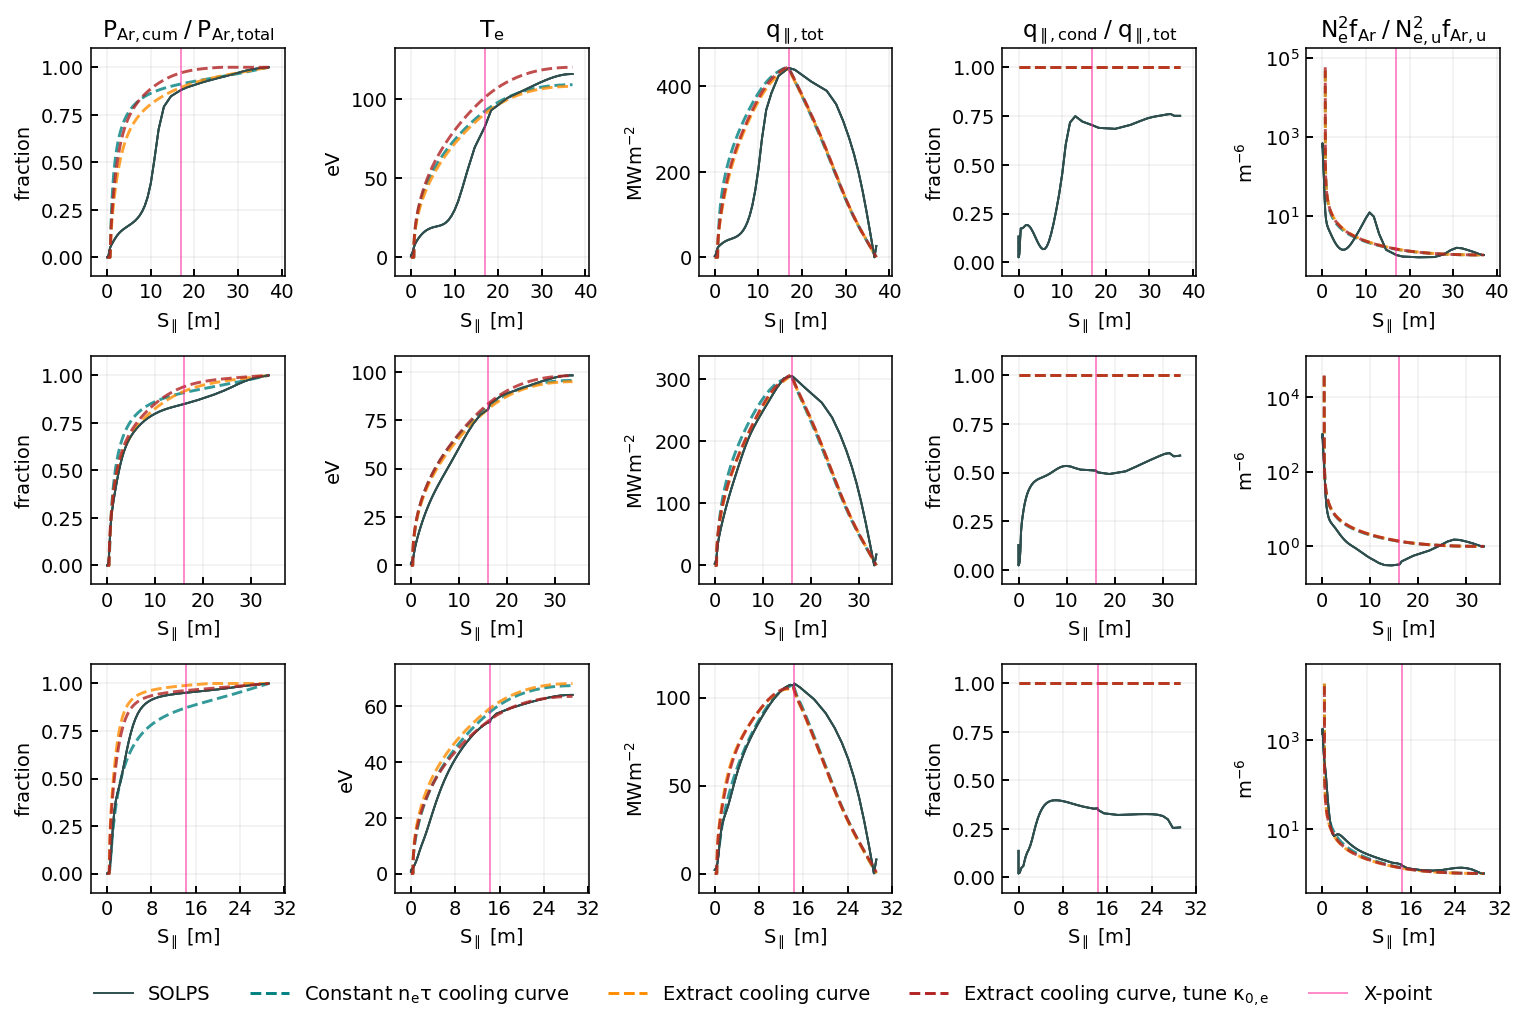

In [19]:
study_choice = ['adas_curve', 'fit_curve', 'fit_curve_kappa']
pc = plot_comparison(comps_outer, studies = study_choice)

param = "Te"

fig, axes = plt.subplots(3, 5, figsize = (11,7), sharey = False)

pc.plot("Prad_cum_norm", axes[:,0])
pc.plot("Te", axes[:,1])
pc.plot("qpar", axes[:,2])
pc.plot("qpar_cond_frac", axes[:,3])
pc.plot("Ne_sq_cz", axes[:,4], normalise = True)

titlesize = "large"
axes[0,0].set_title(r"$P_{Ar,cum}\ /\ P_{Ar,total}$", fontsize = titlesize)
axes[0,1].set_title(r"$T_e$", fontsize = titlesize)
axes[0,2].set_title(r"$q_{\parallel, tot}$", fontsize = titlesize)
axes[0,3].set_title(r"$q_{\parallel, cond}\ /\ q_{\parallel, tot}$", fontsize = titlesize)
axes[0,4].set_title("$N_{e}^{2}f_{Ar}\ /\ N_{e,u}^{2}f_{Ar,u}$", fontsize = titlesize)


fig.tight_layout()
fig.legend(handles = pc.make_legend_elements(), ncols = 2+len(study_choice), bbox_to_anchor = (0.5, 0), loc = "upper center", frameon = False)
# plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_DLSresults_outer.pdf", format = "pdf", bbox_inches = "tight")

In [150]:
ratio.iloc[-3]

1.3315630014503557

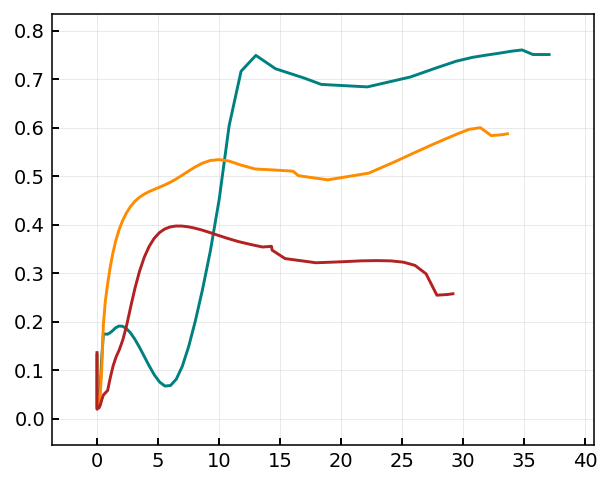

In [168]:
comps = comps_outer["adas_curve"]
fig, ax = plt.subplots()

for i in comps.keys():
    comp = comps[i]

    solps = comp.solps
    tot = solps["fhx_total"]
    cond = solps["fhex_cond"]
    ratio = cond/tot
    ratio.iloc[-2] = np.mean([ratio.iloc[-3], ratio.iloc[-1]])

    # ax.plot(solps["Spar"], ratio)
    ax.plot(solps["Spar"], solps["qpar_cond_frac"])

# Run inner

In [26]:
comps_inner = {}

### With  ADAS curve

Solving...2.52...Complete in 0.9 seconds
  Hflux factor for sepadd 1: 1.10
Solving...0.81...Complete in 1.4 seconds
  Hflux factor for sepadd 2: 1.14
Solving...0.00...Complete in 0.9 seconds
  Hflux factor for sepadd 3: 1.13


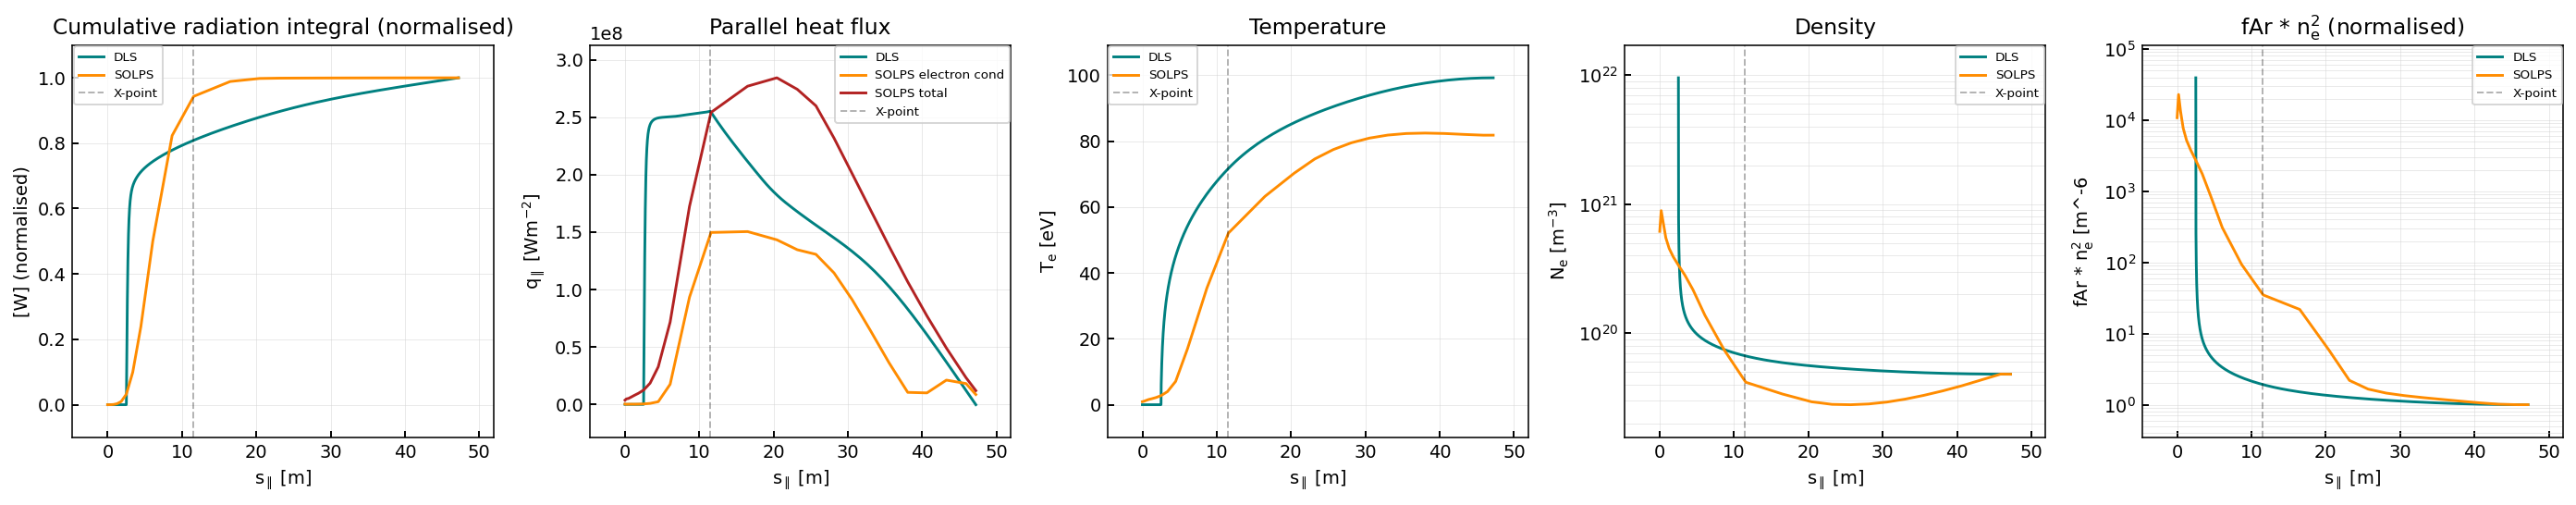

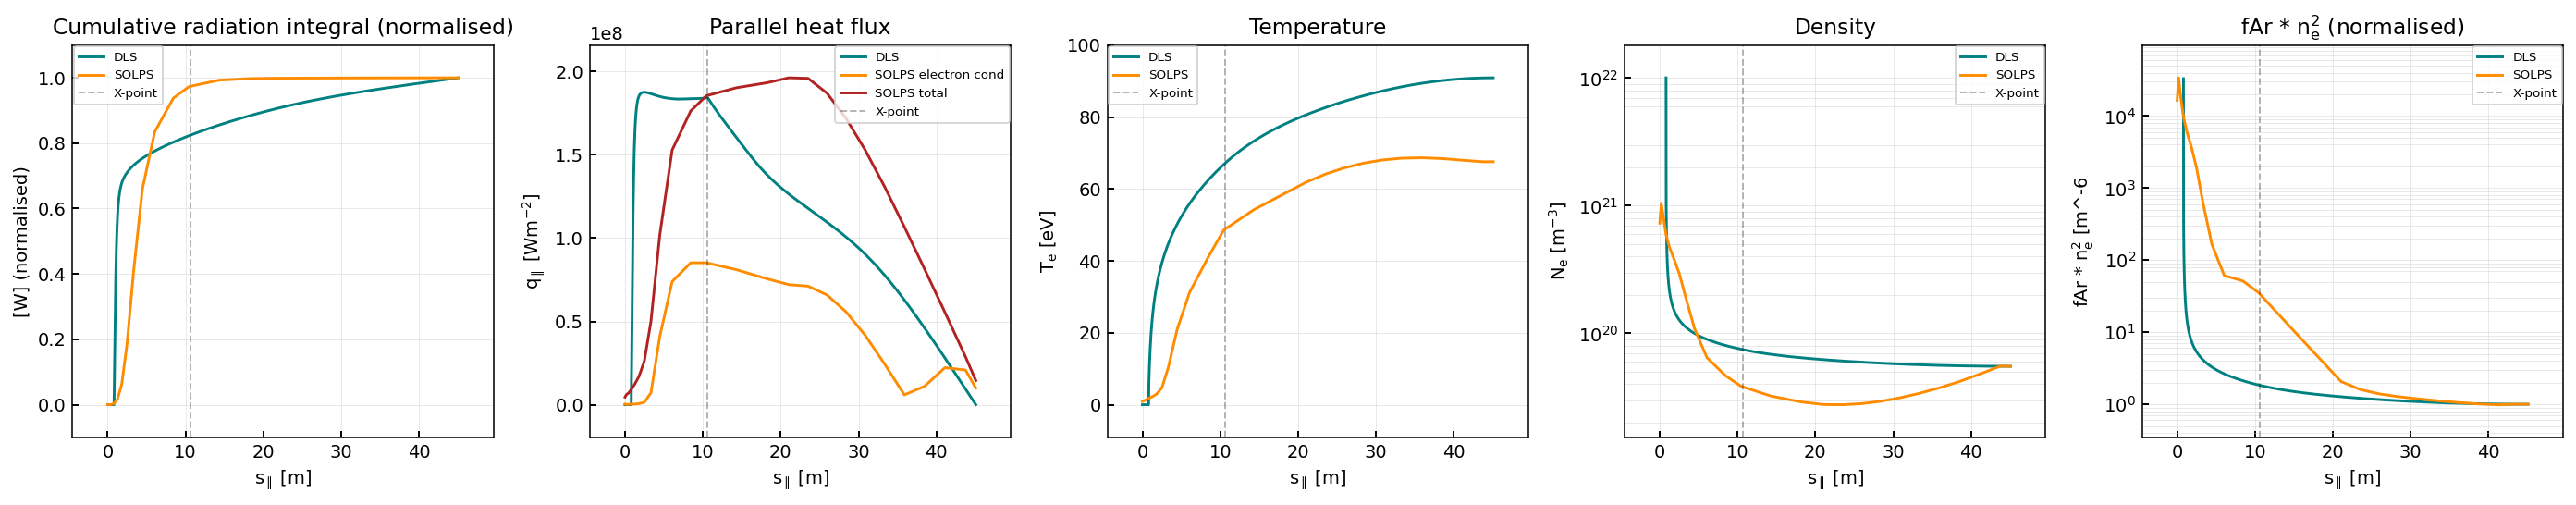

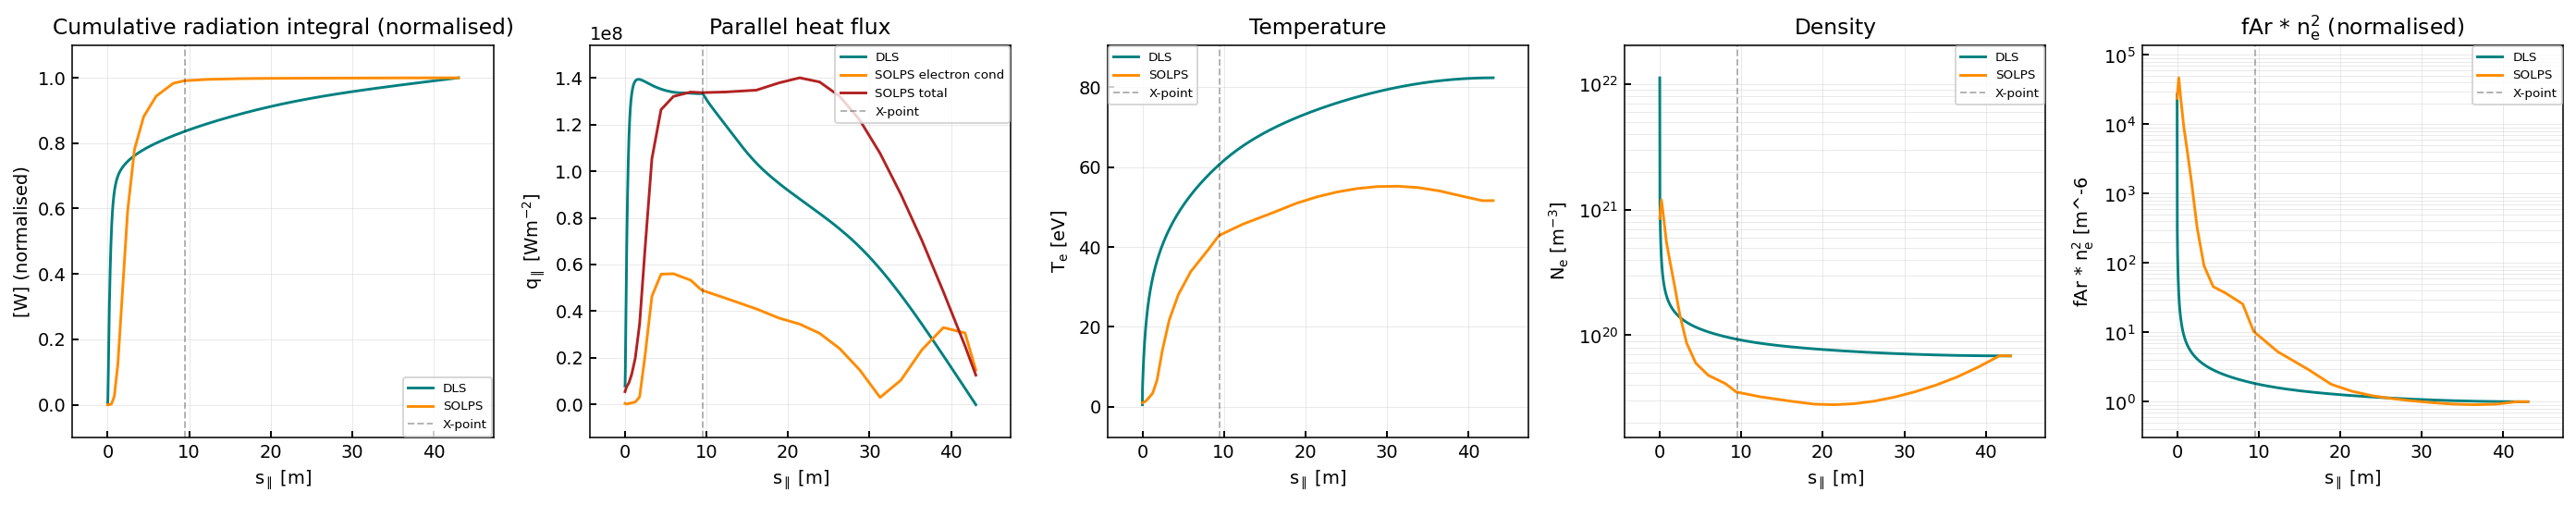

In [201]:
study = "adas_curve"
cvar = "impurity_frac"
region = "inner_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_inner[study] = {}

hflux_corrections = {0: 1, 1: 1.10, 2: 1.13, 3: 1.13, 4: 1.14}
kappa_corrections = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}

for i in [1,2,3]:
    input = {
        # "Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "Lfunc" : curves["Ar"][1e19],
        "kappa0" : 2500 * kappa_corrections[i],
    }

    comps_inner[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_inner[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False, legend_loc = "best")
    
    hflux_factor, kappa_factor = get_correction_factors(comps_inner[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### With fitted curve

Solving...2.52...Complete in 1.3 seconds
  Hflux factor for sepadd 1: 0.92
Solving...0.81...Complete in 0.6 seconds
  Hflux factor for sepadd 2: 0.95
Solving...0.00...Complete in 0.5 seconds
  Hflux factor for sepadd 3: 0.95


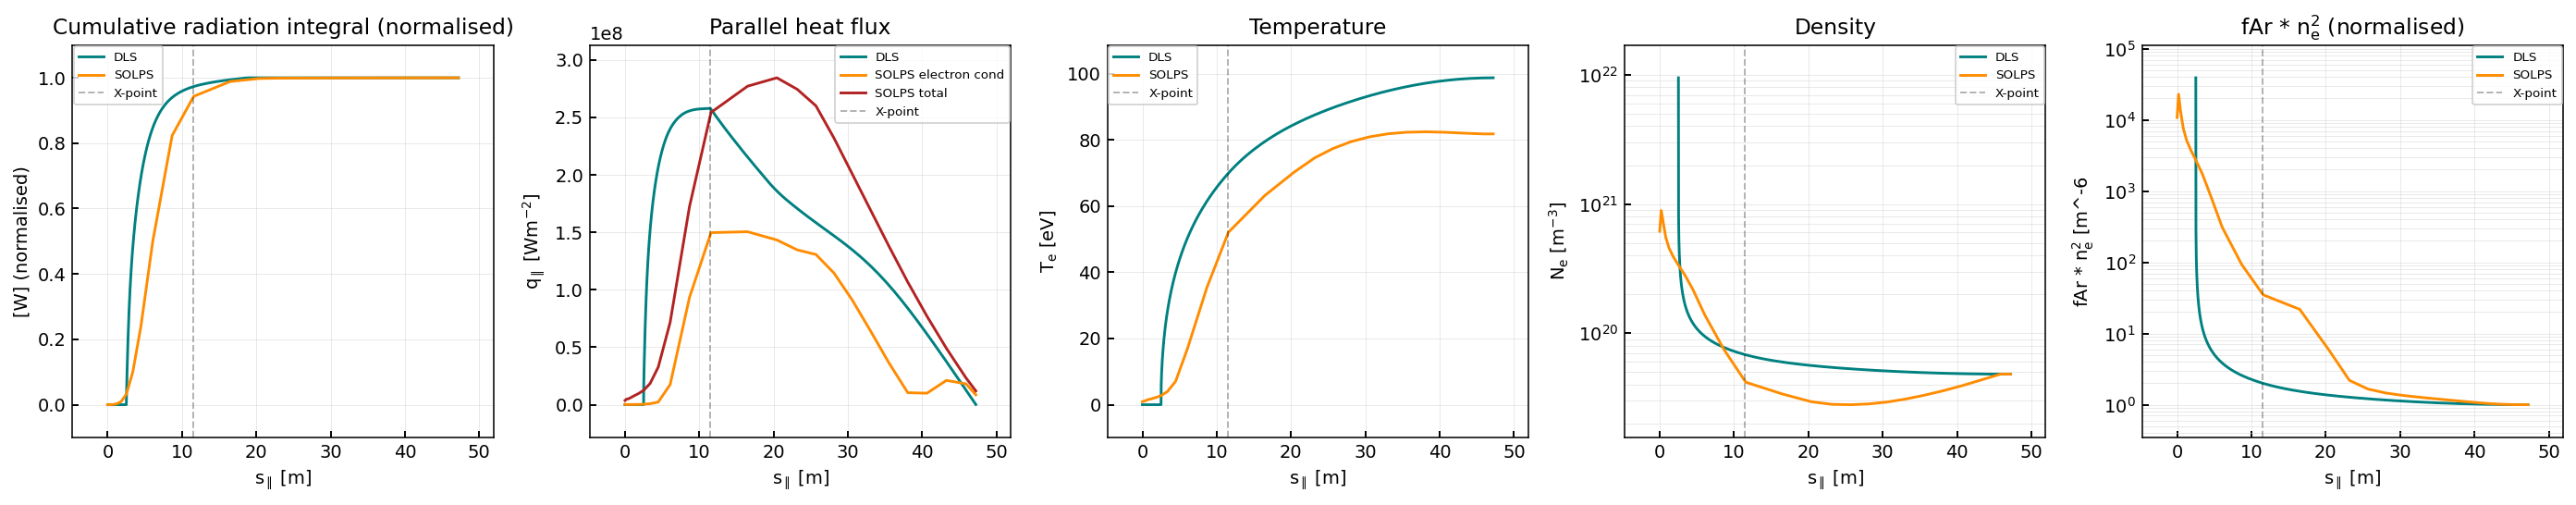

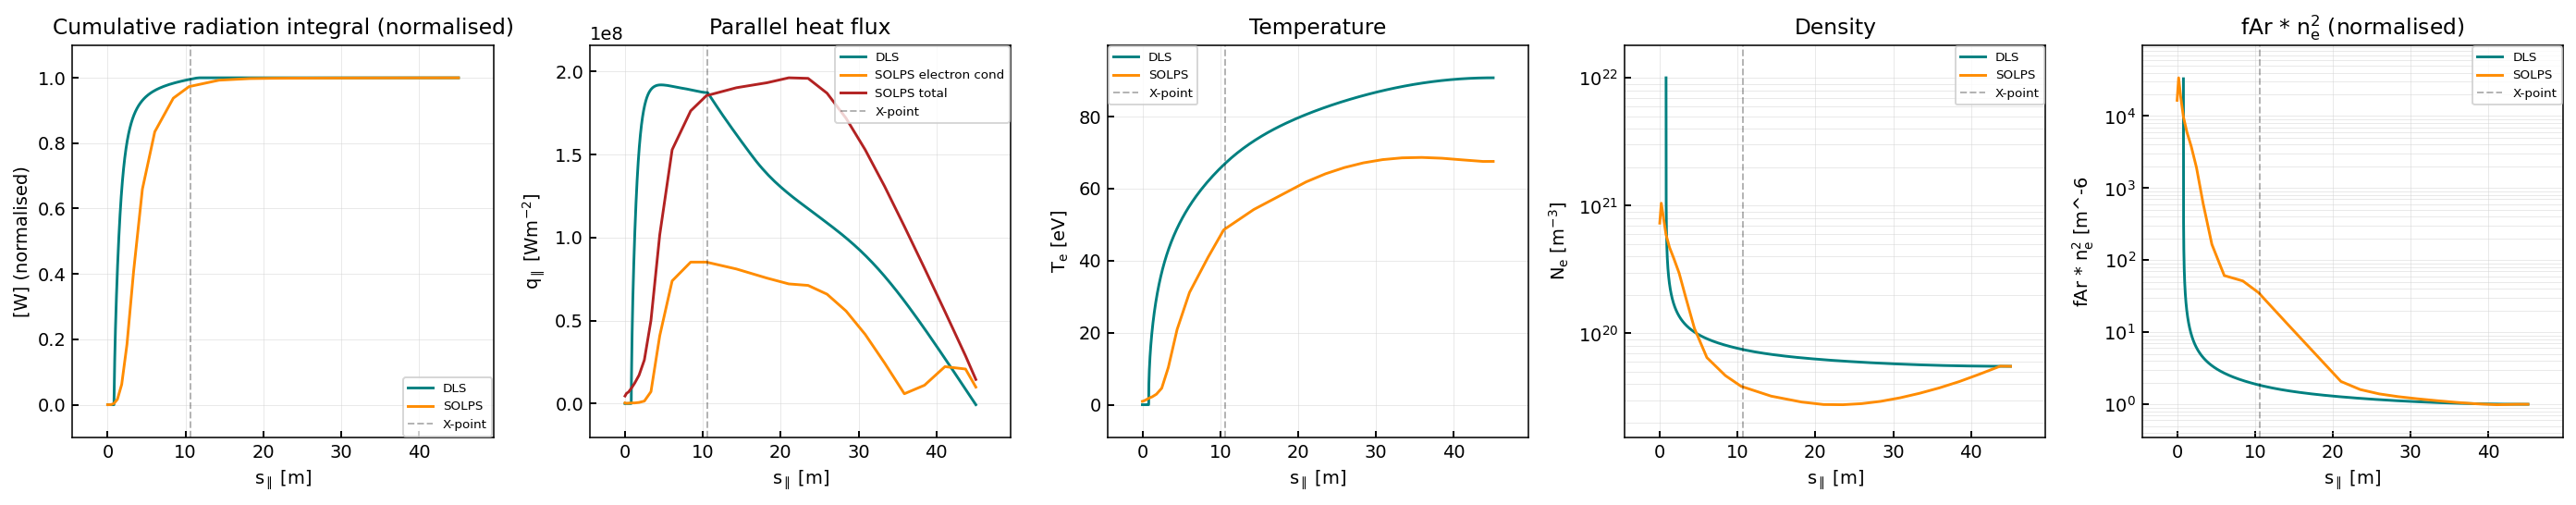

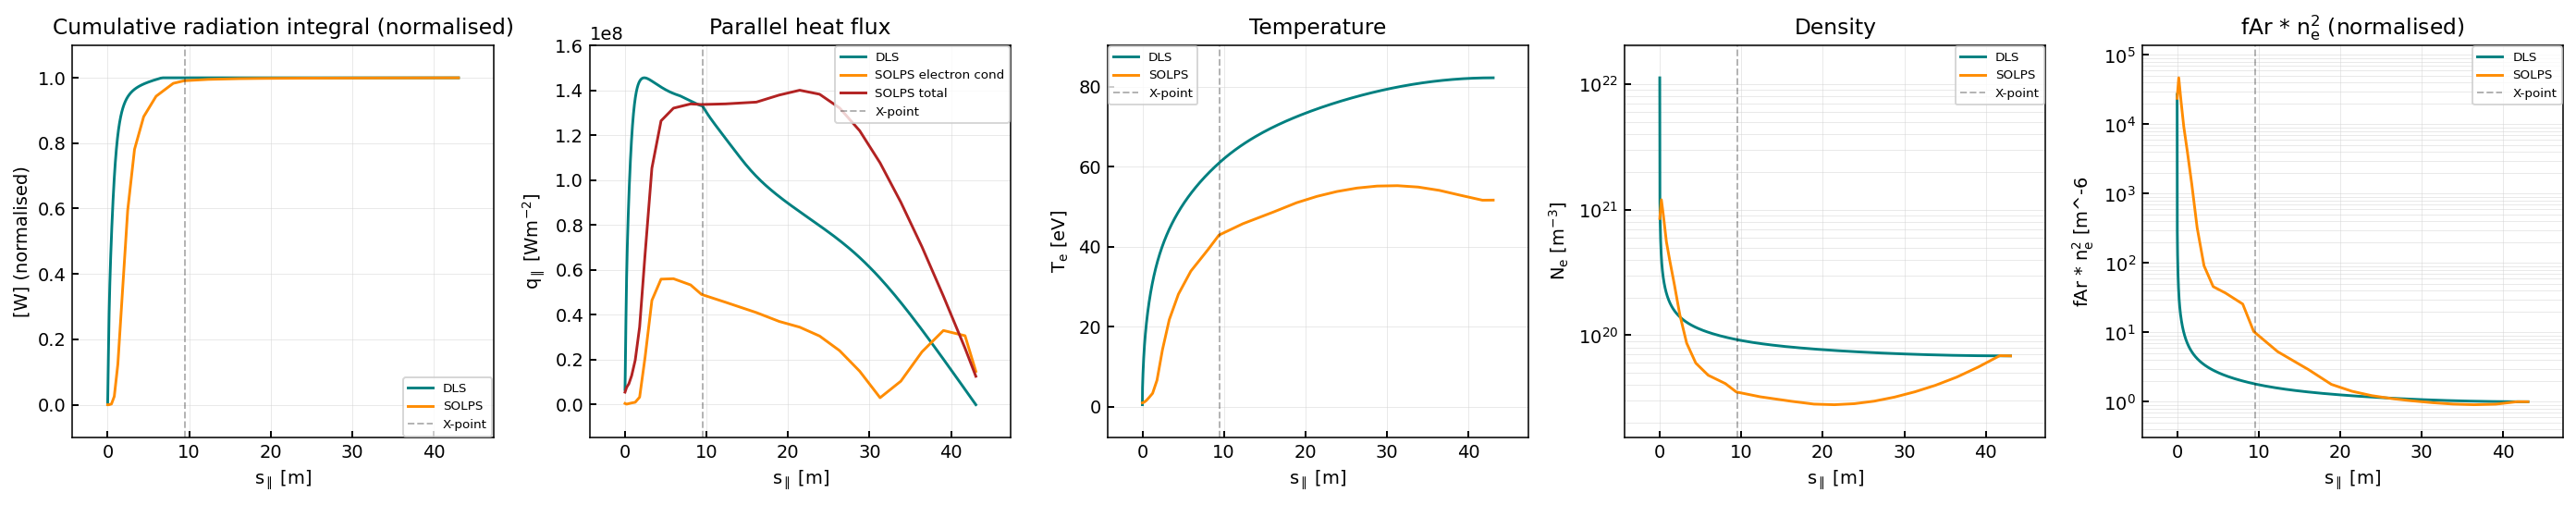

In [202]:
study = "fit_curve"
cvar = "impurity_frac"
region = "inner_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_inner[study] = {}

hflux_corrections = {0: 1, 1: 0.93, 2: 0.96, 3: 0.95, 4: 0.8}
kappa_corrections = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1}

for i in [1,2,3]:
    input = {
        "Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "kappa0" : 2500 * kappa_corrections[i],
    }
    
    comps_inner[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_inner[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False, legend_loc = "best")

    hflux_factor, kappa_factor = get_correction_factors(comps_inner[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")


### Fit curve, kappa

Solving...2.52...Complete in 1.3 seconds
  Hflux factor for sepadd 1: 0.98
  Kappa factor for sepadd 1: 1.79
Solving...0.81...Complete in 1.0 seconds
  Hflux factor for sepadd 2: 1.02
  Kappa factor for sepadd 2: 2.52
Solving...0.00...Complete in 1.2 seconds
  Hflux factor for sepadd 3: 1.02
  Kappa factor for sepadd 3: 3.71


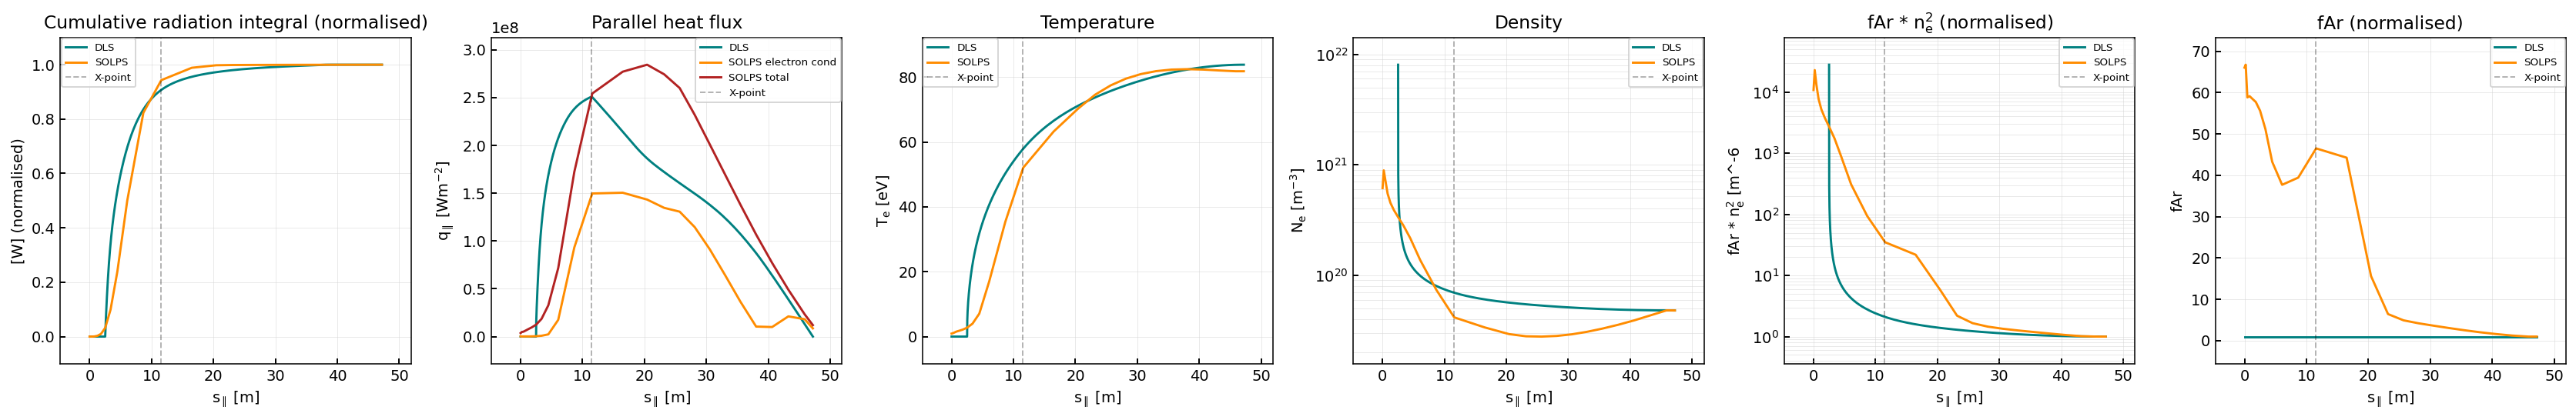

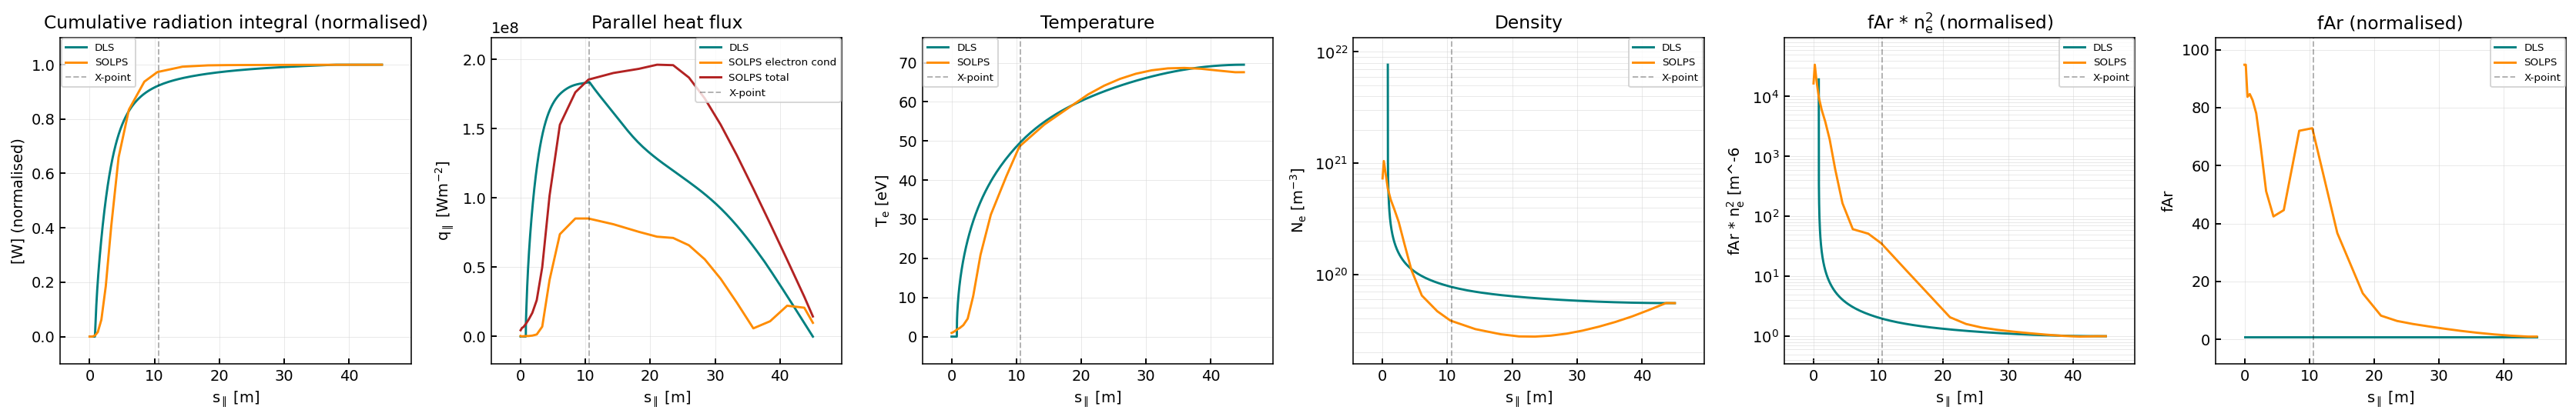

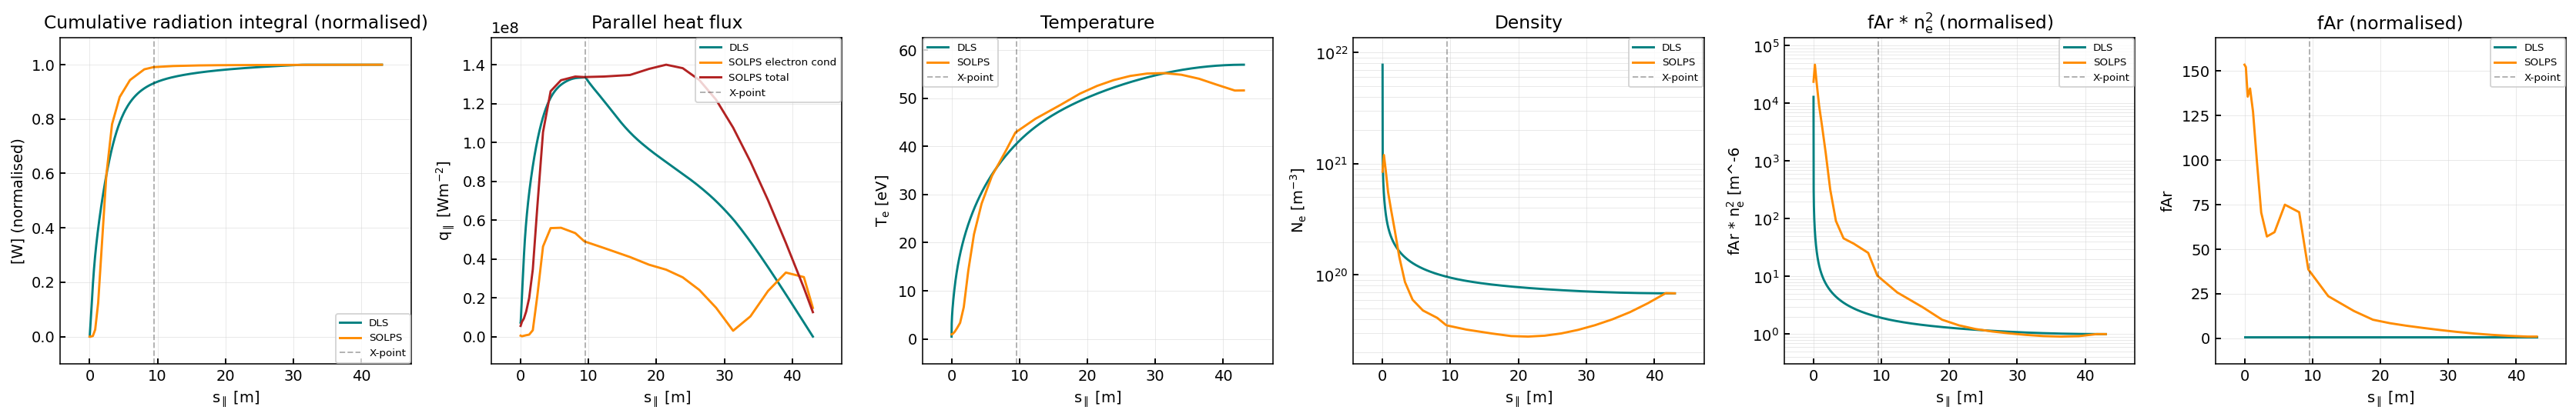

In [206]:
study = "fit_curve_kappa"
cvar = "impurity_frac"
region = "inner_lower"
# case = '100MW_inner_arpuff'
case = "100MW_innerar_midplanepuff"
comps_inner[study] = {}

hflux_corrections = {0: 1, 1: 0.97, 2: 1.01, 3: 1.02, 4: 0.8}
kappa_corrections = {0: 1.13, 1: 1.73, 2: 2.46, 3: 3.49, 4: 3.59}

for i in [1,2,3]:
    input = {
        "Lfunc" : store_slc[case].extract_cooling_curve("Ar", region, sepadd = i, plot = False, ne_effect = False, cz_effect = False),
        "kappa0" : 2500 * kappa_corrections[i],
    }

    comps_inner[study][i] = run_DLS(input, store_slc[case],  cvar, region, i, hflux_corr = hflux_corrections[i])  
    comps_inner[study][i].plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz", "cz"], normalise_radiation = True, radiation_per_area = False, legend_loc = "best")
    
    hflux_factor, kappa_factor = get_correction_factors(comps_inner[study][i])
    print(f"  Hflux factor for sepadd {i}: {hflux_factor * hflux_corrections[i]:.2f}")
    print(f"  Kappa factor for sepadd {i}: {kappa_factor * kappa_corrections[i]:.2f}")


In [204]:
comps_inner

{'fit_curve': {1: <DLS.postprocess.compare_SOLPS_DLS at 0x1ace24fa470>,
  2: <DLS.postprocess.compare_SOLPS_DLS at 0x1acd347a680>,
  3: <DLS.postprocess.compare_SOLPS_DLS at 0x1acd74097b0>},
 'fit_curve_kappa': {1: <DLS.postprocess.compare_SOLPS_DLS at 0x1acd92e1180>,
  2: <DLS.postprocess.compare_SOLPS_DLS at 0x1acd9f7c910>,
  3: <DLS.postprocess.compare_SOLPS_DLS at 0x1ace2329030>},
 'adas_curve': {1: <DLS.postprocess.compare_SOLPS_DLS at 0x1ace25a1cf0>,
  2: <DLS.postprocess.compare_SOLPS_DLS at 0x1acd618c8e0>,
  3: <DLS.postprocess.compare_SOLPS_DLS at 0x1acd3787f40>}}

# Plot inner

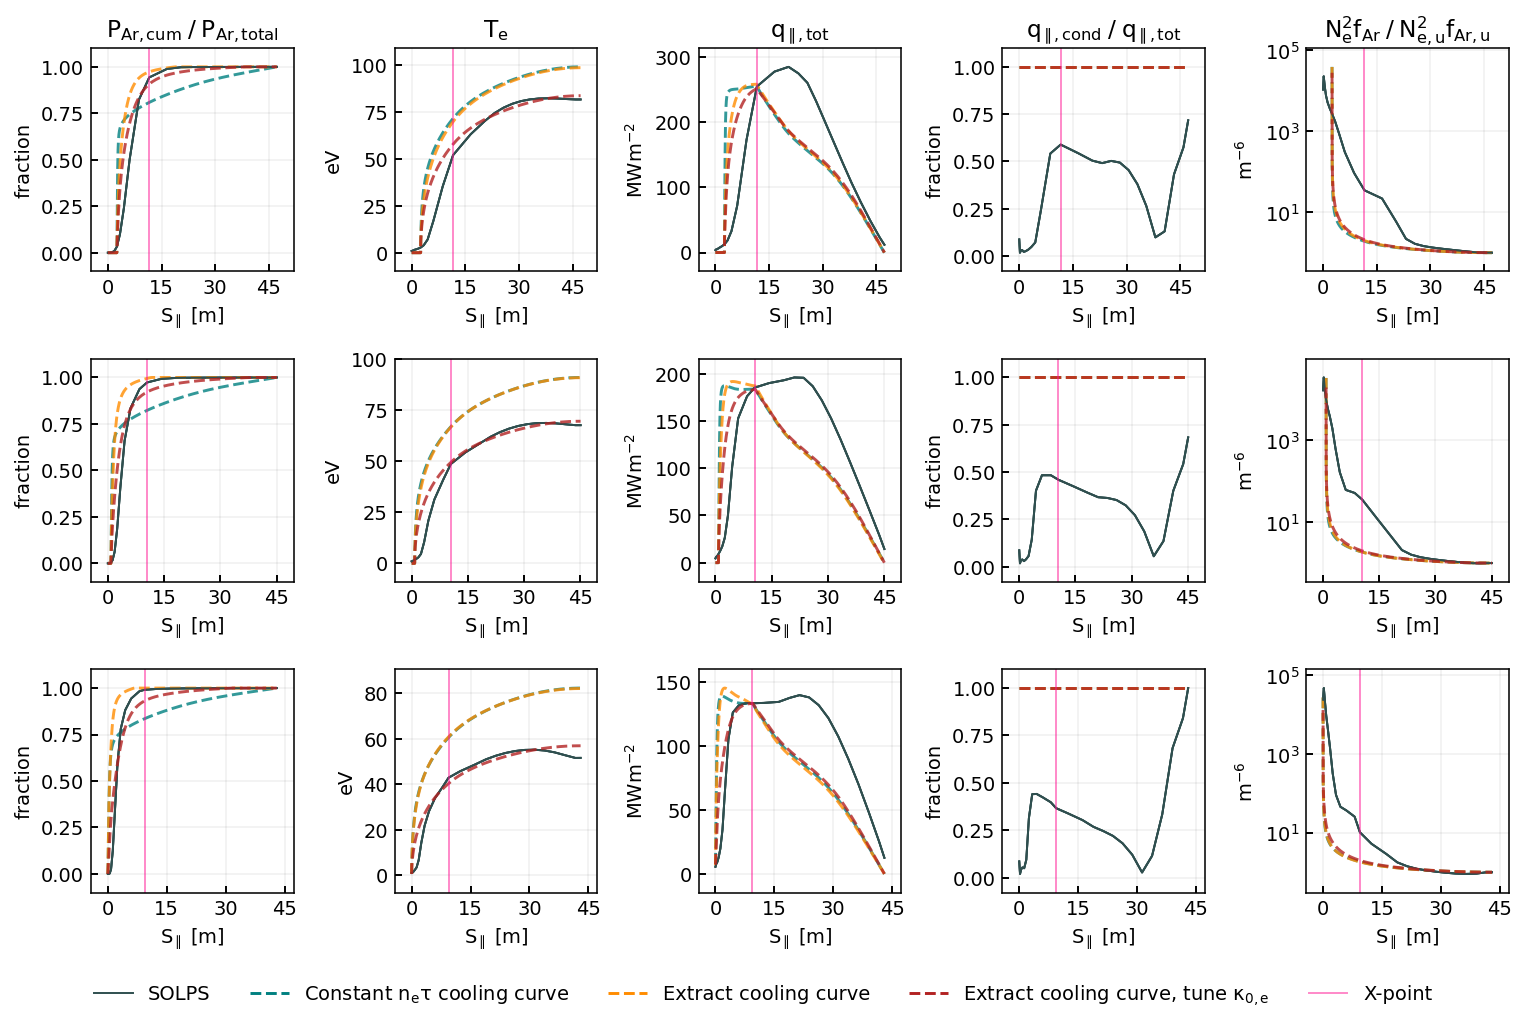

In [205]:
study_choice = ['adas_curve', 'fit_curve', 'fit_curve_kappa']
pc = plot_comparison(comps_inner, studies = study_choice)

param = "Te"

fig, axes = plt.subplots(3, 5, figsize = (11,7), sharey = False)

pc.plot("Prad_cum_norm", axes[:,0])
pc.plot("Te", axes[:,1])
pc.plot("qpar", axes[:,2])
pc.plot("qpar_cond_frac", axes[:,3])
pc.plot("Ne_sq_cz", axes[:,4], normalise = True)

titlesize = "large"
axes[0,0].set_title(r"$P_{Ar,cum}\ /\ P_{Ar,total}$", fontsize = titlesize)
axes[0,1].set_title(r"$T_e$", fontsize = titlesize)
axes[0,2].set_title(r"$q_{\parallel, tot}$", fontsize = titlesize)
axes[0,3].set_title(r"$q_{\parallel, cond}\ /\ q_{\parallel, tot}$", fontsize = titlesize)
axes[0,4].set_title("$N_{e}^{2}f_{Ar}\ /\ N_{e,u}^{2}f_{Ar,u}$", fontsize = titlesize)

fig.tight_layout()
fig.legend(handles = pc.make_legend_elements(), ncols = 2+len(study_choice), bbox_to_anchor = (0.5, 0), loc = "upper center", frameon = False)
plt.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\STEP_DLSresults_inner.pdf", format = "pdf", bbox_inches = "tight")

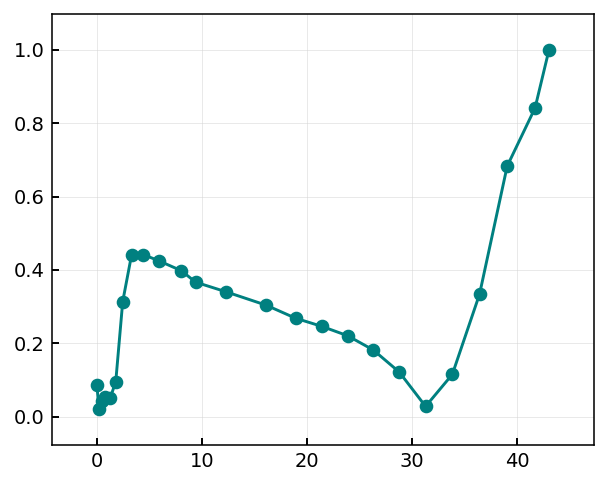

In [200]:
df = comps_inner["adas_curve"][3].solps

cond = np.minimum(df["qpar"].abs(), df["qpar_cond"].abs())
ratio = cond.abs() / df["fhx_total"].abs()
ratio.iloc[-2] = np.mean([ratio.iloc[-3], ratio.iloc[-1]])

fig, ax = plt.subplots()
# ax.plot(df["Spar"], df["fhx_total"].abs())
# ax.plot(df["Spar"], df["fhex_cond"].abs())
ax.plot(df["Spar"], ratio, marker = "o")